Description: Datasets modification framework using cluster analysis

Author: Jiří Setinský

Date: 2.5. 2023

Contact: xsetin00@stud.fit.vutbr.cz



# Dependencies



In [82]:

#!pip install h2o 
#!pip install joblib -U

#!pip install yellowbrick

import pandas as pd
import numpy as np
import sys
import h2o
from h2o.estimators import H2OKMeansEstimator
from sklearn.neighbors import KNeighborsClassifier
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree
plt.style.use('default')
import math
import itertools
from abc import ABC, abstractmethod
import sklearn.metrics as metrics
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans,MeanShift,AgglomerativeClustering, MiniBatchKMeans
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import classification_report
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from joblib import dump, load
from joblib import Parallel, delayed
from imblearn.under_sampling import RandomUnderSampler,CondensedNearestNeighbour, NearMiss, EditedNearestNeighbours,RepeatedEditedNearestNeighbours,InstanceHardnessThreshold,NeighbourhoodCleaningRule,TomekLinks,ClusterCentroids,OneSidedSelection,AllKNN
from yellowbrick.cluster import KElbowVisualizer

In [83]:
plt.style.use('default')

In [84]:
import os
os.environ['JAVA_HOME'] = '/home/netmon/xsetin00/jdk-17'
os.environ['PATH'] = '/home/netmon/xsetin00/jdk-17/bin:' + os.environ['PATH']

print(os.environ['PATH'])

/home/netmon/xsetin00/jdk-17/bin:/home/netmon/xsetin00/jdk-17/bin:/home/netmon/xsetin00/jdk-17/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin


# Class definitions

## Dataset class

In [85]:
class Dataset():
  
  def __init__(self, path, label, use_case, class_values,to_drop=[]):
    self.path = path
    self.label = label
    self.use_case = use_case
    self.pos_value=class_values[0]
    self.neg_value=class_values[1]
    to_drop.append(label)
    self.to_drop=to_drop
    self.total_acc={}
  
  # Rename class values
  def new_classes(self,label):
    if label == self.pos_value:
        return 1
    else:
        return 0

  # Load data
  def load(self):
    self.csv_data=pd.read_csv(self.path)
    label_encoder = LabelEncoder()
    self.csv_data[self.label] = label_encoder.fit_transform(self.csv_data[self.label])
    scaler=StandardScaler()
    features=self.csv_data.drop(self.label, axis=1).columns
    self.csv_data[features]=scaler.fit_transform(self.csv_data[features])

    return self.csv_data
  
  # Set internal data
  def set_data(self,data):
    self.csv_data=data
  
  # Get label data for current class
  def get_label(self,data=None):
    if data is None:
      return self.csv_data[self.label][self.csv_data[self.label]==self.flag].reset_index(drop=True)
    return data[self.label][data[self.label]==self.flag].reset_index(drop=True)

  # Get features data for current class
  def get_features(self,data=None):
    if data is None:
      return self.csv_data[self.csv_data[self.label]==self.flag].drop(columns=self.to_drop,errors="ignore").reset_index(drop=True)
    return data[data[self.label]==self.flag].drop(columns=self.to_drop,errors="ignore").reset_index(drop=True)
  
  # Get label data for all classes
  def get_all_label(self):
    return self.csv_data[self.label].reset_index(drop=True)

  # Get features data for all classes
  def get_all_features(self):
    return self.csv_data.drop(columns=self.to_drop,errors="ignore").reset_index(drop=True)

  # Set context to current class
  def set_class(self,flag):
    self.flag=flag
    self.y=self.get_label()
    self.X=self.get_features()
  
  # Get class balance
  def class_balance(self,data=None):
    if data is None:
      data=self.get_all_label()
    pos=data[data==1].shape[0]
    neg=data.shape[0]-pos
    return {0:neg,1:pos,'all':data.shape[0]}

  # Correlation with class
  def get_corr_analysis(self):
    correlation_with_class=self.csv_data.drop(columns=[self.label]).corrwith(self.csv_data[self.label],method='spearman').reset_index()
    #print(correlation_with_class)
    correlation_with_class.columns=["atrr","corr"]
    
    corr_pos=correlation_with_class[correlation_with_class["corr"] >= 0.3]
    corr_neg=correlation_with_class[correlation_with_class["corr"] <= -0.3]

    self.class_corr=pd.concat([corr_pos,corr_neg],axis=0).reset_index(drop=True)
    #class_corr.to_csv('/content/drive/My Drive/Cluster/correlation_dga.txt',header=False)
    #self.class_corr=pd.read_csv('xsetin00/correlation_dga.txt',header=None,names=["atrr","corr"])##
    return self.class_corr
    
  # Get correlation pairs with opposite coefficient
  def get_corr_pairs(self):
    #self.class_corr=pd.read_csv('/content/drive/My Drive/Cluster/correlation_dga.txt',header=None,names=["atrr","corr"])
    pos_corr=list(self.class_corr[self.class_corr["corr"]>0]["atrr"])
    neg_corr=list(self.class_corr[self.class_corr["corr"]<0]["atrr"])

    self.corr_pairs=list(itertools.product(pos_corr,neg_corr))+list(itertools.product(neg_corr,pos_corr))
    return self.corr_pairs
  
  # Classify only one class with given model
  def dataset_acc(self,clf,label):
    self.set_class(label)
    pred=clf.predict(self.X)
    ######print(classification_report(self.data.y,pred))#Data["is_doh"], pred))
    self.total_acc[label]=metrics.accuracy_score(self.y,pred)
    ######metrics.ConfusionMatrixDisplay(metrics.confusion_matrix(self.data.y, pred) ).plot();
    #return self.total_acc
    return f"Accuracy for class {label} is {self.total_acc[label]}"
    
  # Save data to csv
  def save(self,path,header=True,sep=','):
      self.csv_data.to_csv(path,header=header,sep=sep,index=False)  

## Modifier class

In [86]:
class Modifier(Dataset):

    def __init__(self,new_path,label,use_case,class_values,to_drop=[]):
        super().__init__(new_path,label,use_case,class_values,to_drop)
        self.newdata=pd.DataFrame()
        self.improvement=0

    # Update csv data with new data 
    def update_csv(self):
        self.csv_data=self.newdata
        self.newdata=pd.DataFrame()

    # Set new data  
    def set_newdata(self,X=pd.DataFrame(),y=pd.DataFrame()):
        self.newdata=pd.concat([X,y],axis=1)

    # Save new data to csv
    def save_new(self,path,append=False):
      self.newdata.to_csv(path,index=False,mode='a' if append else 'w',header=(not append))

    def sample(self,cluster_id,frac,model,style="random"):
        data_to_sample=model.result_new[model.result_new["predict"]==cluster_id]
        if style == "random":
            sampled_data=data_to_sample.sample(frac=frac,random_state= np.random.RandomState())#ranmagic,random_state=42)
        else:
            print(model.coeffs,model.centers)
            centroid=model.centers
            print(centroid)
            cluster_data=data_to_sample.join(self.X)
            print(cluster_data)
            cluster_data.pop("predict")
            prep_data=model.prep.transform(cluster_data)
            print(prep_data)
            distances = list(map(lambda x: np.linalg.norm(x - centroid),prep_data))
            print(distances)
            print(math.ceil(frac*data_to_sample.shape[0]))
            sampled_data = np.argsort(distances)[:math.ceil(frac*data_to_sample.shape[0])]
            sampled_data =pd.DataFrame(sampled_data,columns=["predict"],index=sampled_data)
            
        #print(sampled_data)
        return sampled_data
    
    # Extract demanded data from each cluster based on weight vector
    def extract(self,cluster_model,reduced_amount,oversample=True):
        self.set_class(cluster_model.class_number)
        cluster_model.data.set_class(cluster_model.class_number)
        cluster_model.predict(self)
        self.get_data_amount(cluster_model,reduced_amount,oversample)
        print("POTENTIAL AMOUNT",self.potential_amount)
        print("REDUCED AMOUNT",reduced_amount)
        aug_weight=min(reduced_amount/self.potential_amount,1)
        new_data_sampled=pd.DataFrame()
        for cluster_id,coeff in cluster_model.coeffs.items():
           
            final_frac=min(coeff*self.weight,1)*aug_weight
            data_to_sample=self.sample(cluster_id,final_frac,cluster_model,style="random")
            
            new_data_sampled=pd.concat([new_data_sampled,data_to_sample])

        new_data_sampled=new_data_sampled.join(self.X)
        new_data_sampled=new_data_sampled.join(self.y)
        new_data_sampled.pop("predict")
        #print(new_data_sampled)
        print("Extracted data",cluster_model.class_number," - ",new_data_sampled.shape[0])
        #self.newdata=pd.concat([self.newdata,new_data_sampled])
        return new_data_sampled


    # Find potential amount of data to extract 
    def get_data_amount(self,model,total_demand,oversample):
        self.potential_amount=0
        clusters,counts=np.unique(model.result_new,return_counts=True)

        for cluster,amount in zip(clusters,counts):
            self.potential_amount+=model.coeffs[cluster]*amount

        self.potential_amount=int(self.potential_amount)
        reduce_ratio=total_demand/self.potential_amount
        if reduce_ratio > 1 and oversample:
            self.weight=reduce_ratio*1.11
            self.potential_amount=int(sum([(min(model.coeffs[cluster]*self.weight,1))*amount for cluster,amount in zip(clusters,counts)]))
        else:
            self.weight=1

    # Plot class balance
    def plot_balance(self,title,data=None):
        if data is None:
            data=self.get_all_label()
        ax=data.value_counts().plot.pie(title=f"{title}\n\n"+"{:,}".format(data.shape[0]),autopct='%1.1f%%')
        fig=ax.get_figure()
        #fig.savefig(f"xsetin00/{self.use_case}/{title}.png",dpi=500)
        plt.show()

    # Plot classification report
    def plot_report(self,report,title):

        ax=sns.heatmap(report.iloc[:-1, :].T, annot=True,fmt='.4f')
        #total_acc=metrics.accuracy_score(y,pred)
        plt.yticks(rotation=0)
        plt.title(title) 
        #report.transpose().to_latex(f"xsetin00/{self.use_case}/{title} report.tex",float_format="{:.4f}".format,caption=title,label=f"tab:{title}")
        #ax.get_figure().savefig(f"xsetin00/{self.use_case}/{title} report.png",dpi=500)
        plt.show()

    # Compare model on old data between model on clustered data
    def compare_models(self,old,new,test_data,compared_model="Clustered"):

        X_train=self.newdata.drop(columns=self.label).reset_index(drop=True)
        y_train=self.newdata[self.label].reset_index(drop=True)
        new.fit(X_train,y_train)

        self.cnt_old=self.class_balance(self.get_all_label())
        print("Old dataset balance",self.cnt_old)
        self.plot_balance("Old dataset balance",self.get_all_label())

        self.cnt_new=self.class_balance(y_train)
        print(f"{compared_model} dataset balance",self.cnt_new)
        self.plot_balance(f"{compared_model} dataset balance",y_train)


        print("Reduction ratio",100-self.cnt_new['all']/self.cnt_old['all']*100)
        X=test_data.get_all_features()
        y=test_data.get_all_label()

        pred_old = old.predict(X)
        report_old=pd.DataFrame(classification_report(y,pred_old,digits=4,output_dict=True))
        self.plot_report(report_old,"Old model")
        self.plot_matrix(y,pred_old,"Old model CM")


        pred_new = new.predict(X)
        report_new=pd.DataFrame(classification_report(y,pred_new,digits=4,output_dict=True))
        self.plot_report(report_new,f"{compared_model} model")
        self.plot_matrix(y,pred_old,f"{compared_model} model CM")


        f1_old=metrics.f1_score(y,pred_old,average="weighted")
        f1_new=metrics.f1_score(y,pred_new,average="weighted")
        #print(f1_old,f1_new)
        space_to_improve=1-f1_old
        self.improvement=(f1_new-f1_old)/space_to_improve*100
        print("Improvement",self.improvement)

        return classification_report(y,pred_new,digits=4,output_dict=True)

    # Apply existing methods for data modification 
    def apply_imbalanced_lib(self,sampler,prep=False):
        X_old=self.get_all_features()
        y_old=self.get_all_label()
        if prep:
            pipe=make_pipeline(StandardScaler(),VarianceThreshold())
            X_res, y_res = sampler.fit_resample(pipe.fit_transform(X_old), y_old)
            X_res=pipe.inverse_transform(X_res)
            X_res=pd.DataFrame(X_res, columns = X_old.columns)
        else:
            X_res, y_res = sampler.fit_resample(X_old, y_old)
            
        self.set_newdata(X_res, y_res)

    # Model results to export
    def prepare_model_result(self,report,method,dataset,metric='default'):
        #Methods OA Precision Recall F measure
        return pd.DataFrame({'Dataset':dataset, 'Method':method,'Metric':metric, 'Acc':report['accuracy'], 'Precision':report['weighted avg']['precision'], 'Recall':report['weighted avg']['recall'], 'F1':report['weighted avg']['f1-score'],"Impr":self.improvement,"Support_0":str(self.cnt_new[0]),"Support_1":str(self.cnt_new[1])},index=[0])

    # Plot confusion matrix
    def plot_matrix(self,y,pred,title):
        matrix=metrics.ConfusionMatrixDisplay( metrics.confusion_matrix(y, pred) )
        matrix.plot()
        plt.show()
        # fig=matrix.figure_
        # fig.set_figwidth(8)
        # fig.set_figheight(8)  
        # fig.savefig(f"xsetin00/{self.use_case}/{title}.png",dpi=500)


## Cluster class

In [87]:
class Cluster():
  
  def __init__(self):
    self.data = []
    self.report = {}
  
  # Append row to cluster
  def add_data(self, row):
    self.data.append(row)

  # Convert data to numpy array
  def data_to_array(self,columns):
    self.collumns=np.array(columns)
    self.array = np.array(self.data)

  # Get accuracy of cluster 
  def classify_cluster(self, classifier, label):
    pred = classifier.predict(pd.DataFrame(self.array, columns=self.collumns))
    y_gen = np.repeat(label, self.array.shape[0])
    self.report["acc"] = metrics.accuracy_score(y_gen, pred)

  # Variance of cluster's features
  def variance(self):
    self.report["var"] = np.var(self.array, axis=0)

  # Mean of cluster's features
  def get_mean(self):
    self.mean = np.mean(self.array, axis=0)
    self.report["mean"] = self.mean

  # Deviation of cluster's features
  def diff(self, original_mean, min_val, max_val):
    # average deviation of features
    diff = self.mean - original_mean
    # get maximal difference
    lower_min = np.abs(original_mean - min_val)
    lower_max = np.abs(original_mean - max_val)

    diff_result = np.zeros_like(diff)

    for i, value in enumerate(diff):
        if value == 0:
            diff_result[i] = 0
        else:
            if value < 0:
                diff_result[i] = value / lower_min[i]
            else:
                diff_result[i] = value / lower_max[i]

    self.report["dev"] = diff_result
    #print("DEVIATION",self.report['dev'])

  # Correlation of cluster's features
  def correlation(self):
    pairs_to_drop = set()
    dataframe=pd.DataFrame(self.array,columns=self.collumns)
    cols = dataframe.columns
    for i in range(0, dataframe.shape[1]):
      for j in range(0, i+1):
        pairs_to_drop.add((cols[i], cols[j]))
    out=dataframe.corr(method='spearman').unstack().drop(labels=pairs_to_drop).sort_values().dropna()
    ######print(out.to_string())
    self.report["corr"]=out
    #self.report["corr"] = np.corrcoef(self.array.)
    #print("CORRELATION",self.report['corr'])

  # Size of cluster
  def size(self):
    self.report["size"] = self.array.shape[0]

  # Relative size of cluster
  def inv_amount(self, original_size):
    self.amount_ratio = self.report["size"] / original_size
    self.inv_amount_ratio = 1 - self.amount_ratio

  # Average deviation of cluster's features
  def diff_deviation(self):
    self.extreme_deviation = self.report["dev"][np.logical_or(self.report["dev"] < -50, self.report["dev"] > 50)]
    self.mean_deviation = np.mean(np.abs(self.report["dev"]))

    extreme_deviation_cnt = len(self.extreme_deviation)
    self.ratio_extreme_deviation = extreme_deviation_cnt / len(self.report["dev"])

  # Adversial distance of cluster's features
  def adversial(self, data):
    #corr_pos = self.report["corr"][self.report["corr"] >= 0.75]
    corr_neg = self.report["corr"][self.report["corr"] <= -0.3]
    self.adversial_distance = 0
    corr_cnt = 0

    if corr_neg.shape[0] != 0:
        for i in range(corr_neg.shape[0]):
            corr = corr_neg[i]
            if corr in data.corr_pairs:
                corr_cnt += 1
                first = corr[0]
                second = corr[1]
                self.adversial_distance += np.abs(self.report["dev"][np.where(self.collumns==first)] - self.report["dev"][np.where(self.collumns==second)])
        if corr_cnt != 0:
            self.adversial_distance /= corr_cnt * 2
            self.adversial_distance = 1 - self.adversial_distance
  
  # Similarity of cluster's features to another class           
  def similarity(self,data):
    neg_attr=list(data.class_corr[data.class_corr["corr"]<0]["atrr"])
    pos_attr=list(data.class_corr[data.class_corr["corr"]>0]["atrr"])
    #print(data.class_corr)
    sim_neg=0
    sim_pos=0

    for attr in neg_attr:
      sim_neg+=self.report["dev"][np.where(self.collumns==attr)[0][0]]
    if len(neg_attr) != 0:
      sim_neg=(sim_neg/len(neg_attr)+1)/2#no%
    
    
    for attr in pos_attr:
        sim_pos+=self.report["dev"][np.where(self.collumns==attr)[0][0]]
    if len(pos_attr) != 0:
      sim_pos=(sim_pos/len(pos_attr)+1)/2#no%
    

    if data.flag:
      sim_pos=1-sim_pos#no%
    else:
      sim_neg=1-sim_neg#no%
    self.sim=(sim_neg+sim_pos)/2
    ######print("similarity",self.sim) 

  # Relative deviation of cluster's accuracy
  def acc_deviation(self,total_acc,min_acc,max_acc):
    relative_deviation_acc=total_acc-self.report["acc"]
    
    self.acc_ratio=(relative_deviation_acc-min_acc)/(max_acc-min_acc)#no%*100
  
  # Get components to cluster score
  def get_score(self):
    #self.score=(self.mean_deviation+self.ratio_extreme_deviation+self.adversial_distance+self.sim+self.acc_ratio)/5
    self.scoredf=pd.DataFrame({"acc_ratio":self.acc_ratio,"mean_deviation":self.mean_deviation,"ratio_extreme_dev":self.ratio_extreme_deviation,"adversial_distance":self.adversial_distance,"sim":self.sim},index=[0]) # self.inv_amount_ratio+
    ######print("FINAL",self.score,"\n")
    return self.scoredf

## Model classes

In [88]:
class Model(ABC):
 
  def __init__(self,strict=False):
    self.result=None
    self.size=0
    self.data=None
    self.clusters={}
    self.classifier=None
    self.score=[]
    self.strict=strict

  # Abstract methods for individual models
  @abstractmethod
  def train(self):
    pass
  
  @abstractmethod
  def predict(self,data):
    pass

  @abstractmethod
  def perf(self):
    pass

  @abstractmethod
  def load(self):
    pass

  @abstractmethod
  def save(self):
    pass

  # Dvide data to clusters
  def divide_data(self):
  
    # init dictionary for individual clusters
    for x in range(0,self.size):
      self.clusters[f'cluster{x}']=Cluster()
      #self.report[f'cluster{x}']={}

    # insert clustered data to predicted cluster
    for i,row in enumerate(self.data.X.to_numpy()):
      self.clusters[f'cluster{self.result.values[i][0]}'].add_data(row)

  # Compute statistical metrics for each cluster
  def statistical_report(self):
    s = pd.Series([self.data.flag])
    original_mean=self.data.X.mean()
    original_min=self.data.X.min()
    original_max=self.data.X.max()
   
    self.data.get_corr_analysis()
    self.data.get_corr_pairs()
    

    for cluster in self.clusters:
      # number of cluster
      ######print(color.BOLD + color.RED+ cluster+ color.END)

      # dataframe for effective metrics computation
      self.clusters[cluster].data_to_array(self.data.X.columns)#self.data.X.columns
      
      # classify cluster
      self.clusters[cluster].classify_cluster(self.classifier,s)

      # variance of features
      #self.clusters[cluster].variance()
    
      # average of features
      self.clusters[cluster].get_mean()
      
      #difference of features
      self.clusters[cluster].diff(original_mean,original_min,original_max)
      
      # correlation of features
      self.clusters[cluster].correlation()

      # size of cluster
      self.clusters[cluster].size()
  
  # Compute components of cluster score
  def compute_score(self):
    accs_dev=list(map(lambda x: self.data.total_acc[self.class_number]-x[1].report["acc"],list(self.clusters.items())))
    max_acc=max(accs_dev)
    min_acc=min(accs_dev)
    self.score_elements=pd.DataFrame()
    self.amount=[]
    

    #print(self.report['cluster0']["dev"])
    for cluster in self.clusters:

      ######print(cluster)    
      # amount of data in cluster
      self.clusters[cluster].inv_amount(self.data.X.shape[0])

      # pick up most deviated clusters 
      self.clusters[cluster].diff_deviation()
      
      # check if negativly correlated attrr are adversarial
      self.clusters[cluster].adversial(self.data)
      
      #similarity to another class
      self.clusters[cluster].similarity(self.data)

      # acc deviation
      self.clusters[cluster].acc_deviation(self.data.total_acc[self.class_number],min_acc,max_acc)
      
      # make one metrics, always percenatge, complement of acc, maybe normalize to 0,1 by averaging
      self.score_elements=pd.concat([self.score_elements,self.clusters[cluster].get_score()])
      self.amount.append(self.clusters[cluster].amount_ratio)
    
    self.score_elements.reset_index(inplace=True,drop=True)
    #print(self.score_elements)
    

    # make one metrics, always percenatge, complement of acc, maybe normalize to 0,1 by averaging
    self.final_score()
    self.score_data=self.get_results()
  
  # Remove constant and uncorrelated components from score
  def final_score(self):
    #print(self.score_elements)
    corr=self.score_elements.drop(columns=['acc_ratio']).corrwith(self.score_elements['acc_ratio'],method="spearman").reset_index()
    corr.columns=["atr","corr"]
    #print(corr)
    without_na=corr.fillna(value=-1)
    drop=without_na[without_na['corr']<=0 ]['atr'].to_list()
    #print(drop)
    final_elements=self.score_elements.drop(columns=drop)
    #print(final_elements)
    final_elements['score']=final_elements.mean(axis=1)
    #print(final_elements)
    self.score=final_elements['score'].fillna(value=1)
    #self.score=self.score_elements.drop(columns=['acc_ratio']).mean(axis=1)
   
  
  # Normalize score and get weight vector
  def get_results(self):
    
    acc_dev=[]
    amount=[]
    coeff=[]
    relative_amount=[]
    acc=[]

    # 2sigma threshold
    #print(self.score)
    #print([self.score.mean() - 2 * self.score.std(), self.score.mean() + 2 * self.score.std()])
    two_sigma_threshold=self.score.mean() + 2 * self.score.std()
    if self.score.max() > two_sigma_threshold:
      #print("APPLY 2SIGMA")
      sorted_score=self.score.sort_values(ascending=False).reset_index(drop=True)
      #print(sorted_score)
      max_score=sorted_score[1]
      second=sorted_score[2]
      #print(max_score)
    else:
      max_score=max(self.score)
      second=max_score
    
    min_score=min(self.score)
    interval_score=max_score-min_score
    min_amount=min(self.amount)
    max_amount=max(self.amount)
    interval_amount=max_amount-min_amount
    for cluster,score in zip(self.clusters,self.score):
      
      # relative score
      if interval_score == 0:
        coeff.append(1)
      else:
        rel_score=(score-min_score)/(interval_score)
        if rel_score == 1:
          #print(((second-min_score)/(interval_score)+1)/2)
          rel_score=((second-min_score)/(interval_score)+1)/2
        else:
          rel_score=min(rel_score,1)
        if self.strict:
          new_score=rel_score*0.8+0.2
        else:
          new_score=rel_score/2+0.5


        # relative amount
        #rel_amount=(self.clusters[cluster].amount_ratio-min_amount)/(interval_amount*2)+0.5
        #relative_amount.append(rel_amount)
        
        coeff.append(new_score)
      
      
      amount.append( self.clusters[cluster].amount_ratio)
      #red.append(self.clusters[cluster].report['red'])
      acc.append(self.clusters[cluster].report['acc'])
      acc_dev.append(self.clusters[cluster].acc_ratio)
      
    #return pd.DataFrame({"score":self.score,"relative score":relative_score,"amount_rel":relative_amount,"coeff":coeff,"podil dat":amount,"inv_acc":acc_dev,"acc":acc})
    return pd.DataFrame({"score":self.score,"weight":coeff,"amount":amount})

  # Plot results of score computation 
  def plot_results(self,description):
    #self.score_elements.plot.bar(figsize=(9,7))
    #plt.show()
    #plt.clf()
    #sns.regplot(x="acc_ratio",y="mean_deviation",data=self.score_elements,ci=None)
    #plt.show()

    print("TOTAL ACC",self.data.total_acc[self.class_number])
    ax=self.score_data.plot.bar(figsize=(9,7))
    #ax.set(xlabel='Clusters', ylabel='Value',fontsize=15)
    plt.xlabel('Shluky', fontsize=15)
    plt.ylabel('Hodnota', fontsize=15)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    ax.set_title(description,fontsize=20)
    fig=ax.get_figure()
    plt.show()
    plt.clf()
    #ax=sns.regplot(x="score",y="inv_acc",data=self.score_data,ci=None)
    #plt.show()
    #fig.savefig(f"xsetin00/{self.data.use_case}/{description}.png",dpi=500)
  
  # Save weight vector for next step
  def save_report(self):
    self.coeffs=self.score_data['weight']
    self.coeffs=self.coeffs.rename("coeffs")
    #print(self.coeffs)

  # Run whole analysis
  def cluster_analysis(self,pca=False,description="None description"):
    if pca:
      self.prep=make_pipeline(StandardScaler(),VarianceThreshold(),PCA(n_components='mle'))
    else:
      self.prep=make_pipeline(StandardScaler(),VarianceThreshold())
    self.pca=pca
    self.train()
    self.perf()
    self.divide_data()
    self.statistical_report()
    self.compute_score()
    self.plot_results(description)
    self.save_report()

# Class for H2O framework
class H2O_model(Model):

  def __init__(self, data, classifier,class_number,strict=False):
    super().__init__(strict)
    self.data=data
    self.classifier=classifier
    self.class_number=class_number
    self.data.set_class(class_number)

    # model inicializaton
    self.model=H2OKMeansEstimator( k=10,
                              estimate_k=True,
                              standardize=False,
                              max_iterations = 100)#ranmagic
  
  # Train H2O cluster model
  def train(self):
    # create h2o data frame
    inner_data = h2o.H2OFrame(self.prep.fit_transform(self.data.X.to_numpy()))
    
    # create model for kmeans algorithm
    self.model.train(training_frame=inner_data)

    self.size=len(self.model.size())

    tmp=self.model.predict(inner_data)
    self.result=tmp.as_data_frame(use_pandas=True, header=True)
    self.centers=self.model.centers().as_data_frame(use_pandas=True, header=True)
  
  # Cluster data
  def predict(self,data):
    if data is self.data:
      #print("SAME DATA")
      self.result_new=self.result
    else:
      h2o_frame=h2o.H2OFrame(self.prep.fit_transform(data.X))
      tmp=self.model.predict(h2o_frame)
      self.result_new=tmp.as_data_frame(use_pandas=True, header=True)
   
  # Show model metrics
  def perf(self):
    print(self.model.model_performance())
  
  # Save model
  def save(self,path):
    h2o.save_model(model=self.model, path=path, force=True)
  
  # Load model
  def load(self,path):
    self.model=h2o.load_model(path)

# Class for Sklearn framework
class Sklearn_model(Model):

  def __init__(self, data, classifier,class_number,model='kmeans',index='bouldin',strict=False):
    super().__init__(strict)
    self.data=data
    self.classifier=classifier
    self.class_number=class_number
    self.data.set_class(class_number)
    self.model_name=model
    self.max_k=10
    self.optimal_ks={}
    self.index=index
    self.criterion =min(0.02 + 10. / self.data.X.shape[0] + 2.5 / pow(self.data.X.shape[1], 2), 0.8)

    # Models initialization
    if self.model_name == 'kmeans':
      self.models=[KMeans(n_clusters=i,max_iter=100,n_init="auto") for i in range(1,self.max_k+1)]#ranmagic
    elif self.model_name == 'mean_shift':
       self.models=[MeanShift()]
    elif self.model_name == 'aglomerative':
       self.models=[AgglomerativeClustering(n_clusters=i, linkage="ward") for i in range(1,self.max_k+1)]

  # Visualize methods for K estimation
  def visualize(self,data):
    #metrics=['calinski_harabasz','silhouette','elbow']

    model = MiniBatchKMeans(max_iter=100,n_init="auto")#ranmagic
    # k is range of number of clusters.
    if self.index == 'elbow':
      visualizer = KElbowVisualizer(model, k=(3,10), timings=False )
    else:
      visualizer = KElbowVisualizer(model, k=(3,10) ,metric=self.index, timings=False )
    # Fit the data to the visualizer
    visualizer.fit(data.copy())
            
    visualizer.show()#outpath=f"xsetin00/{self.data.use_case}/{self.index}{self.class_number}.pdf")  
    self.optimal_ks[self.index]=visualizer.elbow_value_
    #plt.savefig(f"xsetin00/{self.data.use_case}/{self.index}.png",dpi=100)
    plt.show()
    plt.style.use('default')

  # K estimation methods with iteration stop criterion
  def pre(self,data):
    models=[MiniBatchKMeans(n_clusters=i,max_iter=100,n_init="auto") for i in range(1,self.max_k+1)]#ranmagic
    model_old = models[0]
    model_old.fit(data)
   
    
    distorsions = []
    bouldin_score=[]
    if self.index=='PRE':
        print("CRIT",self.criterion)
        distorsions.append(model_old.inertia_)
        print("SSE",model_old.inertia_)
    k=2
    for model in models[1:]:
        model.fit(data)
        bouldin_score.append(davies_bouldin_score(data, model.labels_))
        if self.index=='PRE':
          distorsions.append(model.inertia_)
          print("SSE",model.inertia_)
          PRE=(distorsions[k-2]-distorsions[k-1])/distorsions[k-2]
          print("PRE",PRE,k)
          k+=1
          if PRE < self.criterion:
            break
        model_old=model
    
    sorted=bouldin_score.copy()
    sorted.sort()
    self.optimal_ks['bouldin']=bouldin_score.index(sorted[0])+2
    if self.optimal_ks['bouldin'] == 2:
      self.optimal_ks['bouldin']=bouldin_score.index(sorted[1])+2

    if self.index=='PRE':
        self.optimal_ks['PRE']=len(np.unique(model_old.labels_)) 
        fig = plt.figure(figsize=(15, 5))
        plt.plot(range(1, len(distorsions)+1), distorsions)
        plt.grid(True)
        plt.title('Elbow curve')
        plt.show()
    else:
        plt.plot(range(2, len(bouldin_score)+2), bouldin_score, linestyle='--', marker='o', color='b');
        plt.xlabel('K');
        plt.ylabel('Davies Bouldin score');
        plt.title('Davies Bouldin score vs. K');
        #plt.savefig(f"xsetin00/{self.data.use_case}/bouldin{self.class_number}.pdf")
        plt.show()

  # Estimate K with demanded method
  def estimate_k(self,data):
    if self.index in ['PRE','bouldin']:
      self.pre(data)
    else:
      self.visualize(data)
    
    self.size=self.optimal_ks[self.index]

  # Train Sklearn model
  def train(self):
    print(self.data.X.shape)
    prep_data=self.prep.fit_transform(self.data.X)
    print(prep_data.shape)
    self.estimate_k(prep_data)
    self.model=self.models[self.size-1]
    self.model.fit(prep_data)
    self.result=pd.DataFrame(self.model.labels_,columns=["predict"])
    self.centers=self.model.cluster_centers_

  # Cluster data 
  def predict(self,data):
    if self.model_name=='aglomerative' or data is self.data:
        self.result_new=self.result
    else:
        self.result_new=pd.DataFrame(self.model.predict(self.prep.fit_transform(data.X)),columns=["predict"])
  
  # Show model metrics
  def perf(self):
    print("Final K parameter:",self.size)
    if self.index=='PRE':
      print("SSE",self.model.inertia_)
  
  # Save model
  def save(self,path):
    dump(self.model,path)
  
  # Load model
  def load(self,path):
    self.model=load(path)
  
    

# Dataset reduction and merging

### Prepare datasets

In [89]:
# For saving results 
framework_result=pd.DataFrame()
output_directory="xsetin00/Data/reduced_datasets/"

In [90]:
# Description of experiment
text='reduction'

In [91]:
# Define context of applied use case

def prep_data(use_case,data,label):
        class_values=data[1]#(True,False)#("dga",'legit')

        # datasets paths
        old_data_path = f"xsetin00/Data/refdata/{data[0]}.csv"#"REFDATA/data/

        # old data init
        old_data=Modifier(f"{old_data_path}",label,use_case,class_values,to_drop=[])
        old_data.load()
        classcol=old_data.csv_data.pop("Class")
        cat=old_data.csv_data.select_dtypes(exclude=['floating'])
        num=old_data.csv_data.select_dtypes(include=['floating'])
        scaler=StandardScaler()
        if not num.empty:
                num=pd.DataFrame(scaler.fit_transform(num),columns=num.columns)
        
        label_encoder = LabelEncoder()
        encoded=cat.apply(label_encoder.fit_transform)
        dfs = [num, encoded, classcol]
        non_empt_dfs = [df for df in dfs if not df.empty]
        old_data.csv_data=pd.concat(non_empt_dfs,axis=1)
        from sklearn.utils import shuffle
        old_data.csv_data=shuffle(old_data.csv_data,random_state=42)
        #old_data.save(f"refdatanoh/{data[0]}.csv",False,'\t')
        
        print(old_data.class_balance(old_data.csv_data[label]))
      
        folds=5
        kf = KFold(n_splits=folds,shuffle=False,random_state=None)
        indexs=[]
        for train_index, test_index in kf.split(old_data.csv_data): 
                indexs.append((train_index,test_index))

        test_data=Dataset(None,label,use_case,class_values)

     

        return old_data,test_data,indexs

In [92]:
def prep_models(train_data,test_data,use_case,dumb_ratio=0.99,knn=1,model_type="knn"):
    # Creating and eventually training classifier
    clf_types=['old','dumb','clustered','compare']
    clfs={}  
    result=pd.DataFrame()
    for clf_type in clf_types:

        #clfs[clf_type] = DecisionTreeClassifier(random_state=42)
        if model_type=="knn":
            clfs[clf_type]=KNeighborsClassifier(n_neighbors=knn)#KNeighborsClassifier(n_neighbors=knn) #AdaBoostClassifier(
                # estimator=DecisionTreeClassifier(max_depth=6,criterion='entropy',random_state=42,max_features=None),n_estimators=5,algorithm='SAMME.R',random_state=42
                # )
        elif model_type=="tree":
            clfs[clf_type]=DecisionTreeClassifier(random_state=42)
            
        if clf_type == 'old':
            clfs[clf_type].fit(train_data.get_all_features(), train_data.get_all_label())
            pred=clfs[clf_type].predict(test_data.get_all_features())
            report=classification_report(test_data.get_all_label(),pred,digits=4,output_dict=True)
            train_data.cnt_new=train_data.class_balance(train_data.get_all_label())
            train_data.improvement=0
            tmp=train_data.prepare_model_result(report,text+" 1",use_case,clf_type+" "+str(knn))
            result=pd.concat([result,tmp])
        elif clf_type == 'dumb':
            # just small sample to train classifier
            dumb_X_train, _, dumb_y_train, _ = train_test_split(train_data.get_all_features(), train_data.get_all_label(), test_size=dumb_ratio, random_state=42, shuffle=True, stratify=train_data.get_all_label())#0.99#0.8
            clfs[clf_type].fit(dumb_X_train, dumb_y_train)
        else:
            continue    

        pred=clfs[clf_type].predict(test_data.get_all_features())
        print(clf_type,classification_report(test_data.get_all_label(),pred,digits=4))
    # Get overall accuracy of classifier for each class
    acc_vector=[(train_data,clfs["dumb"],0),(train_data,clfs["dumb"],1)]
    #Parallel(n_jobs=1,backend="threading")([delayed(data[0].dataset_acc)(data[1],data[2]) for data in acc_vector])
    [data[0].dataset_acc(data[1],data[2]) for data in acc_vector]
    return clfs,result

In [38]:
# Define context of applied use case
use_case="DOH"
label="is_doh"#class
class_values=(True,False)#(True,False)#("dga",'legit')
merging=True # if true, new data is merged with old data, if false, old data is just reduced

# datasets paths
old_data_path = "/srv/data/pesekja8/datasets/generated_data.csv"#"/srv/data/pesekja8/datasets/generated_data.csv"#"xsetin00/DGA/train_dataset.csv"#"xsetin00/doh_test_analyze_3M.csv"#"/srv/data/pesekja8/datasets/generated_data.csv" # "/srv/data/pesekja8/datasets/doh_paper.csv"
new_data_path = "xsetin00/doh_test_analyze_3M.csv"
test_size=0.2

# old data init
old_data=Modifier(f"{old_data_path}",label,use_case,class_values,to_drop=['domain'])
old_data.load()
print(use_case,"old data")
print(old_data.class_balance(old_data.csv_data[label]))
X_train_old, X_test_old, y_train_old, y_test_old = train_test_split(old_data.get_all_features(), old_data.get_all_label(), test_size=test_size, random_state=42, shuffle=True, stratify=old_data.get_all_label())#995
old_data.set_data(pd.concat([X_train_old,y_train_old],axis=1))
print(old_data.class_balance(old_data.csv_data[label]))

# new data init
if merging:
    new_data=Modifier(f"{new_data_path}",label,use_case,class_values,to_drop=['Dataset'])
    new_data.load()
    print(use_case,"new data")
    print(new_data.class_balance(new_data.csv_data[label]))
    X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(new_data.get_all_features(), new_data.get_all_label(), test_size=test_size, random_state=42, shuffle=True, stratify=new_data.get_all_label())
    new_data.set_data(pd.concat([X_train_new,y_train_new],axis=1))
    print(new_data.class_balance(new_data.csv_data[label]))
else:
    X_test_new, y_test_new = pd.DataFrame(),pd.DataFrame()
    
#old_data.set_data(pd.concat([old_data.csv_data,new_data.csv_data],axis=0))
#print("just reduction",old_data.class_balance(old_data.csv_data[label]))

ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

#### Testing data

In [56]:
# Creating testing data
if merging:
    X_test=pd.concat([X_test_old,X_test_new])
    y_test=pd.concat([y_test_old,y_test_new])   
else:
    X_test=X_test_old
    y_test=y_test_old
test_data=Dataset(_,label,use_case,class_values)
test_data.set_data(pd.concat([X_test,y_test],axis=1))
test_data.csv_data

At1    At2  Class
3248 -0.0753  0.267      1
4463  0.9240  0.861      0
2556 -0.4840  0.615      1
4348  0.8690  0.576      0
3704  1.3700  1.450      1
...      ...    ...    ...
2708 -0.9920  1.400      0
4446  0.9410  1.460      0
2340  0.8200 -0.514      1
274   1.3300  1.420      1
3452 -0.6520 -1.540      0

[1060 rows x 3 columns]

### Classifiers training

In [57]:
# Creating and eventually training classifier
if merging:
    clf_types=['old','dumb','clustered','compare','new']
else:
    clf_types=['old','dumb','clustered','compare']
clfs={}  
for clf_type in clf_types:

    #clfs[clf_type] = DecisionTreeClassifier(random_state=42)
    clfs[clf_type]=KNeighborsClassifier(n_neighbors=1)#AdaBoostClassifier(
        # estimator=DecisionTreeClassifier(max_depth=6,criterion='entropy',random_state=42,max_features=None),n_estimators=5,algorithm='SAMME.R',random_state=42
        # )
    if clf_type == 'old':
        clfs[clf_type].fit(X_train_old, y_train_old)
    elif clf_type == 'dumb':
        # just small sample to train classifier
        dumb_X_train, _, dumb_y_train, _ = train_test_split(X_train_old, y_train_old, test_size=0.99, random_state=42, shuffle=True, stratify=y_train_old)#0.99#0.8
        clfs[clf_type].fit(dumb_X_train, dumb_y_train)
    elif clf_type == 'new':
        clfs[clf_type].fit(X_train_new, y_train_new)
    else:
        continue    

    pred=clfs[clf_type].predict(X_test)
    print(clf_type,classification_report(y_test,pred,digits=4))



old               precision    recall  f1-score   support

           0     0.8669    0.8684    0.8676       585
           1     0.8376    0.8358    0.8367       475

    accuracy                         0.8538      1060
   macro avg     0.8522    0.8521    0.8522      1060
weighted avg     0.8537    0.8538    0.8538      1060

dumb               precision    recall  f1-score   support

           0     0.8038    0.8615    0.8317       585
           1     0.8129    0.7411    0.7753       475

    accuracy                         0.8075      1060
   macro avg     0.8084    0.8013    0.8035      1060
weighted avg     0.8079    0.8075    0.8064      1060



#### Classify individual classes

In [58]:
# Get overall accuracy of classifier for each class
if merging:
    acc_vector=[(old_data,clfs["dumb"],0),(old_data,clfs["dumb"],1),(new_data,clfs["old"],0),(new_data,clfs["old"],1)]
else:
    acc_vector=[(old_data,clfs["dumb"],0),(old_data,clfs["dumb"],1)]
#Parallel(n_jobs=1,backend="threading")([delayed(data[0].dataset_acc)(data[1],data[2]) for data in acc_vector])
[data[0].dataset_acc(data[1],data[2]) for data in acc_vector]



['Accuracy for class 0 is 0.8867037195382642',
 'Accuracy for class 1 is 0.7958968963703315']

#### Classify on test dataset

In [76]:
# Run classifier on testing data   
for clf_type in ["old",'new']:#clf_types:
    pred=clfs[clf_type].predict(X_test)
    report=classification_report(y_test,pred,digits=4,output_dict=True)
    old_data.cnt_new=old_data.class_balance(y_train_old)
    old_data.improvement=0
    tmp=old_data.prepare_model_result(report,text,use_case,clf_type)
    framework_result=pd.concat([framework_result,tmp])
framework_result    

Dataset   Method Metric       Acc  Precision    Recall        F1  Impr   
0     DOH  merging    old  0.729436   0.767998  0.729436  0.692035     0  \
0     DOH  merging    new  0.852488   0.866056  0.852488  0.854321     0   

  Support_0 Support_1  
0   1352542    228729  
0   1352542    228729

### Apply clustering

#### Analyze and extract

In [93]:
# Analyze and extract one class and one dataset at a time
def modification_one(label,data,clf,undersample,metric='elbow',alg="kmeans",desc=""):
    
    # class reduction
    if alg=="h2o":
        cluster_model=H2O_model(data,clf,label)
        
    else:
        cluster_model=Sklearn_model(data,clf,label,model=alg,index=metric)
   
    cluster_model.cluster_analysis(pca=True,description=desc+" - "+str(label))

    
    extracted_data=data.extract(cluster_model,undersample,oversample=True)
    
    #del cluster_model
    return pd.DataFrame(extracted_data)


#### Prepare input vector for clustering

In [94]:
# Function to define parameters data modifcation
def get_params(red=1,neg_label=None,pos_label=None,old_data=None,new_data=None,clfs=None,merging=False):
    if pos_label is not None:
        reduction=(pos_label+neg_label)/old_data.csv_data.shape[0]
        tmp=neg_label/(pos_label+neg_label)
        label_weights=[tmp,1-tmp]
    else:
        reduction=red
        label_weights=[0.5,0.5]
    if merging:
        style=[('Old',old_data,clfs['dumb']),('New',new_data,clfs['old'])]
    else:
        style=[('Old',old_data,clfs['dumb'])]

    input_vector=[]
    for dataset_type,data,clf in style:
        desc=dataset_type+" data analysis"
        for label in [0,1]:
            if len(style) == 1: # only one dataset
                dataset_weights={"Old":1}
            else:
                #reduce_coeff=min(max(math.floor((new_data.total_acc[label]/old_data.total_acc[label])*10)/10,0.2),0.8)
                reduce_coeff=min(max(new_data.total_acc[label]/(new_data.total_acc[label]+old_data.total_acc[label]),0.2),0.8)
                # balance_old=old_data.class_balance()
                # balance_new=new_data.class_balance()
                # amount_coeff=balance_old[label]/(balance_new[label]+balance_old[label])
                # dataset_weights={"Old":(reduce_coeff+amount_coeff)/2,"New": ((1-reduce_coeff)+(1-amount_coeff))/2}
                dataset_weights={"Old":reduce_coeff,"New": 1-reduce_coeff}
                #print(dataset_weights)

            demanded_amount=int(old_data.csv_data.shape[0]*reduction*label_weights[label]*dataset_weights[dataset_type])#263545
            print(desc+" - "+str(label),"To be extracted - ",demanded_amount)
            input_vector.append((label,data,clf,demanded_amount,desc))
    return input_vector, 2*len(style), reduction

##### Viszualize

In [56]:
def vizualize(train,test):
    print("Train")
    print(train)
    print("Test")
    print(test)

    sns.pairplot(train,hue='Class')
    # fig, ax = plt.subplots()
    # print(train[:, 0])
    # # Plot train dataset
    # ax.scatter(train[:, 0], train[:, 1], c='blue', label='Train', marker='o')

    # # Plot test dataset
    # ax.scatter(test[:, 0], test[:, 1], c='red', label='Test', marker='s')

    # # Set labels and title
    # ax.set_xlabel('Feature 1')
    # ax.set_ylabel('Feature 2')
    # ax.set_title('Scatter Matrix')

    # # Add legend
    # ax.legend()

    # Show the plot
    plt.show()
    

#### Run modification process

{0: 145, 1: 200, 'all': 345}
old               precision    recall  f1-score   support

           0     0.5938    0.5938    0.5938        32
           1     0.6486    0.6486    0.6486        37

    accuracy                         0.6232        69
   macro avg     0.6212    0.6212    0.6212        69
weighted avg     0.6232    0.6232    0.6232        69

dumb               precision    recall  f1-score   support

           0     0.4118    0.4375    0.4242        32
           1     0.4857    0.4595    0.4722        37

    accuracy                         0.4493        69
   macro avg     0.4487    0.4485    0.4482        69
weighted avg     0.4514    0.4493    0.4500        69

Old data analysis - 0 To be extracted -  69
Old data analysis - 1 To be extracted -  69
{0: 69, 1: 69}
nearmiss1
CPU times: user 28.6 ms, sys: 3.71 ms, total: 32.3 ms
Wall time: 29.1 ms
nearmiss2
CPU times: user 28.4 ms, sys: 7.86 ms, total: 36.2 ms
Wall time: 30.5 ms
nearmiss3
CPU times: user 46.4 ms, sys:

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


CPU times: user 1.26 s, sys: 21.6 ms, total: 1.28 s
Wall time: 480 ms
Old data analysis - 0 To be extracted -  55
Old data analysis - 1 To be extracted -  55
{0: 55, 1: 55}
nearmiss1
CPU times: user 27.2 ms, sys: 8.03 ms, total: 35.2 ms
Wall time: 32.4 ms
nearmiss2
CPU times: user 27.5 ms, sys: 7.62 ms, total: 35.1 ms
Wall time: 29.8 ms
nearmiss3
CPU times: user 40.7 ms, sys: 9.03 ms, total: 49.7 ms
Wall time: 43.8 ms
randomsampler
CPU times: user 6.52 ms, sys: 0 ns, total: 6.52 ms
Wall time: 6.66 ms
clustercentroids


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


CPU times: user 1.17 s, sys: 5.77 ms, total: 1.18 s
Wall time: 383 ms
Old data analysis - 0 To be extracted -  41
Old data analysis - 1 To be extracted -  41
{0: 41, 1: 41}
nearmiss1
CPU times: user 20 ms, sys: 11.5 ms, total: 31.4 ms
Wall time: 28.4 ms
nearmiss2
CPU times: user 28.6 ms, sys: 8.82 ms, total: 37.4 ms
Wall time: 32.1 ms
nearmiss3
CPU times: user 38 ms, sys: 13.2 ms, total: 51.2 ms
Wall time: 45.4 ms
randomsampler
CPU times: user 6.9 ms, sys: 3 µs, total: 6.9 ms
Wall time: 6.79 ms
clustercentroids


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


CPU times: user 1.12 s, sys: 0 ns, total: 1.12 s
Wall time: 297 ms
Old data analysis - 0 To be extracted -  27
Old data analysis - 1 To be extracted -  27
{0: 27, 1: 27}
nearmiss1
CPU times: user 27.2 ms, sys: 1.94 ms, total: 29.1 ms
Wall time: 26.4 ms
nearmiss2
CPU times: user 28.9 ms, sys: 5.47 ms, total: 34.4 ms
Wall time: 29.1 ms
nearmiss3
CPU times: user 40.5 ms, sys: 9.27 ms, total: 49.7 ms
Wall time: 44 ms
randomsampler
CPU times: user 6.25 ms, sys: 810 µs, total: 7.06 ms
Wall time: 6.75 ms
clustercentroids


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


CPU times: user 1.03 s, sys: 1.25 ms, total: 1.03 s
Wall time: 204 ms
Old data analysis - 0 To be extracted -  13
Old data analysis - 1 To be extracted -  13
{0: 13, 1: 13}
nearmiss1
CPU times: user 25.7 ms, sys: 5.23 ms, total: 30.9 ms
Wall time: 27.9 ms
nearmiss2
CPU times: user 28.7 ms, sys: 6.71 ms, total: 35.4 ms
Wall time: 29.9 ms
nearmiss3
CPU times: user 44.1 ms, sys: 7.67 ms, total: 51.7 ms
Wall time: 46 ms
randomsampler
CPU times: user 6.65 ms, sys: 0 ns, total: 6.65 ms
Wall time: 6.75 ms
clustercentroids


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


CPU times: user 893 ms, sys: 12.5 ms, total: 905 ms
Wall time: 113 ms
Old data analysis - 0 To be extracted -  6
Old data analysis - 1 To be extracted -  6
{0: 6, 1: 6}
nearmiss1
CPU times: user 23.3 ms, sys: 6.35 ms, total: 29.6 ms
Wall time: 26.7 ms
nearmiss2
CPU times: user 30.8 ms, sys: 4.77 ms, total: 35.6 ms
Wall time: 30.1 ms
nearmiss3
CPU times: user 41.8 ms, sys: 10.7 ms, total: 52.6 ms
Wall time: 46.7 ms
randomsampler
CPU times: user 6.49 ms, sys: 148 µs, total: 6.63 ms
Wall time: 6.75 ms
clustercentroids
CPU times: user 735 ms, sys: 4.58 ms, total: 740 ms
Wall time: 72.6 ms
kmeans
bouldin
Old data analysis - 0 To be extracted -  69
Old data analysis - 1 To be extracted -  69
(113, 6)


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


(113, 3)


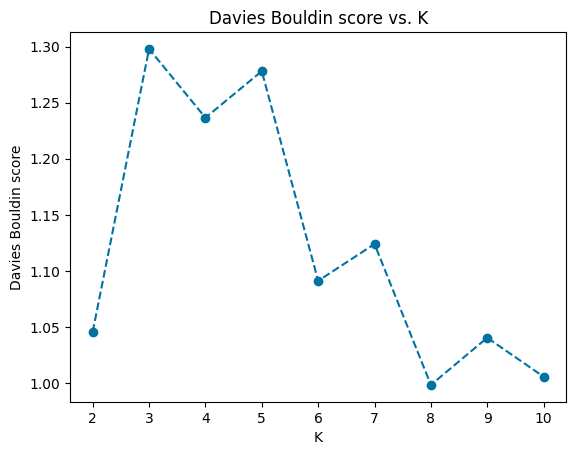

Final K parameter: 8
TOTAL ACC 0.49557522123893805


/home/netmon/.local/lib/python3.10/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


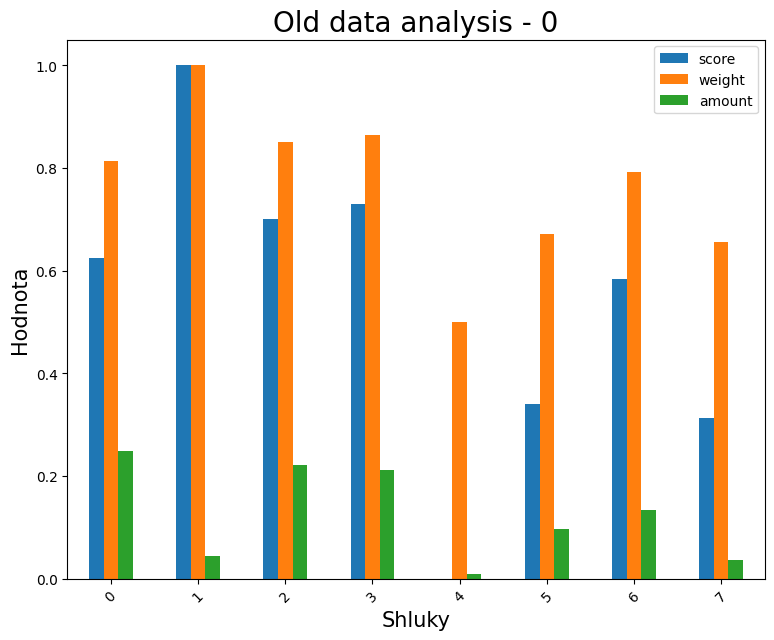

POTENTIAL AMOUNT 92
REDUCED AMOUNT 69
Extracted data 0  -  70
(163, 6)
(163, 5)


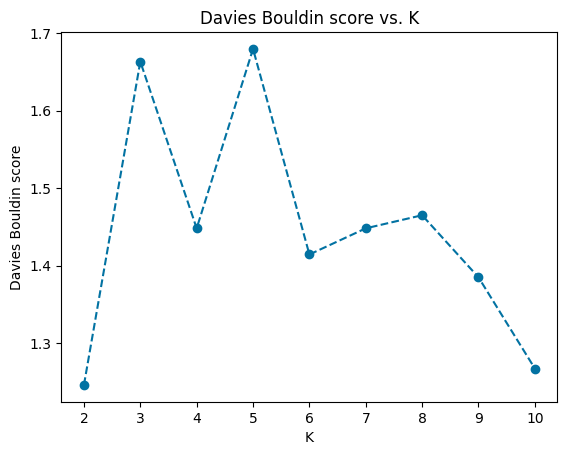

Final K parameter: 10
TOTAL ACC 0.8098159509202454


/home/netmon/.local/lib/python3.10/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


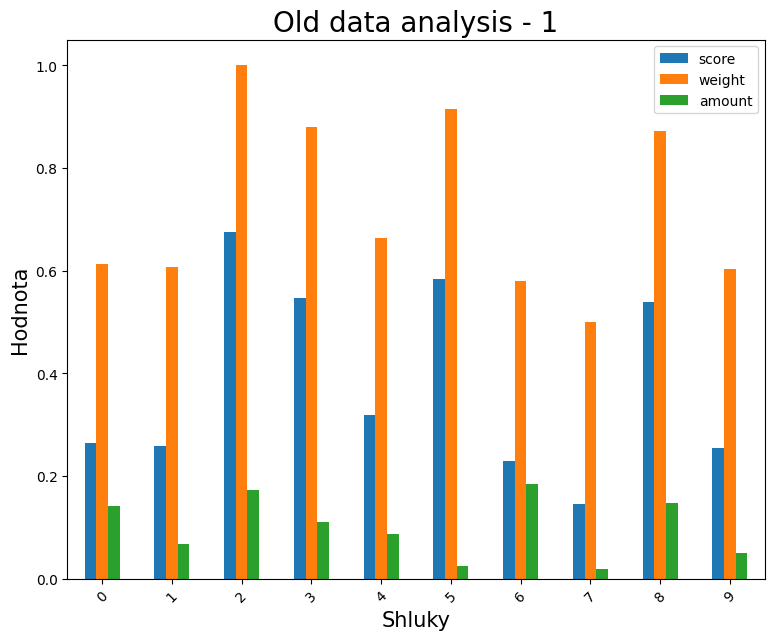

POTENTIAL AMOUNT 122
REDUCED AMOUNT 69
Extracted data 1  -  70
CPU times: user 5.51 s, sys: 828 ms, total: 6.34 s
Wall time: 2.56 s
Old data analysis - 0 To be extracted -  55
Old data analysis - 1 To be extracted -  55
(113, 6)
(113, 3)


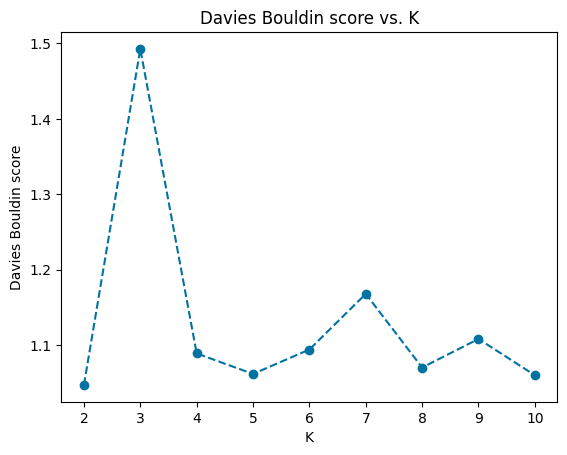

Final K parameter: 10
TOTAL ACC 0.49557522123893805


/home/netmon/.local/lib/python3.10/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


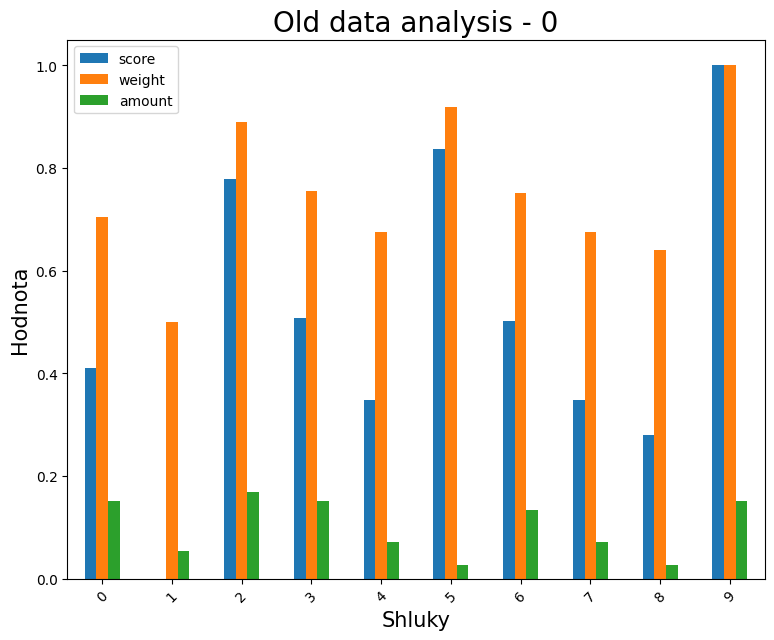

POTENTIAL AMOUNT 88
REDUCED AMOUNT 55
Extracted data 0  -  55
(163, 6)
(163, 5)


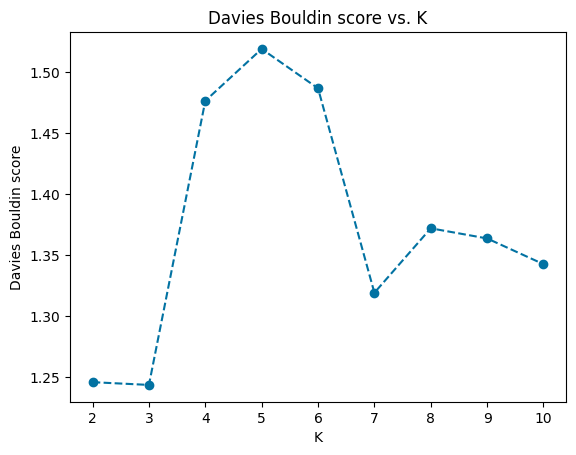

Final K parameter: 3
TOTAL ACC 0.8098159509202454


/home/netmon/.local/lib/python3.10/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


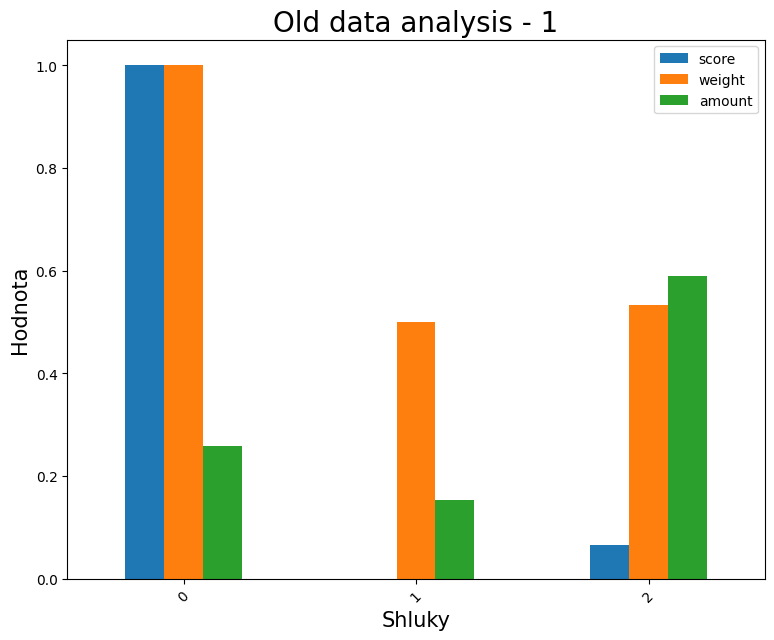

POTENTIAL AMOUNT 105
REDUCED AMOUNT 55
Extracted data 1  -  56
CPU times: user 5.9 s, sys: 652 ms, total: 6.55 s
Wall time: 2.01 s
Old data analysis - 0 To be extracted -  41
Old data analysis - 1 To be extracted -  41
(113, 6)
(113, 3)


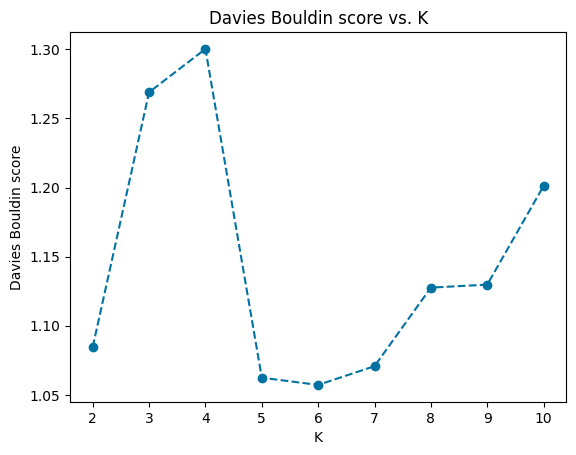

Final K parameter: 6
TOTAL ACC 0.49557522123893805


/home/netmon/.local/lib/python3.10/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


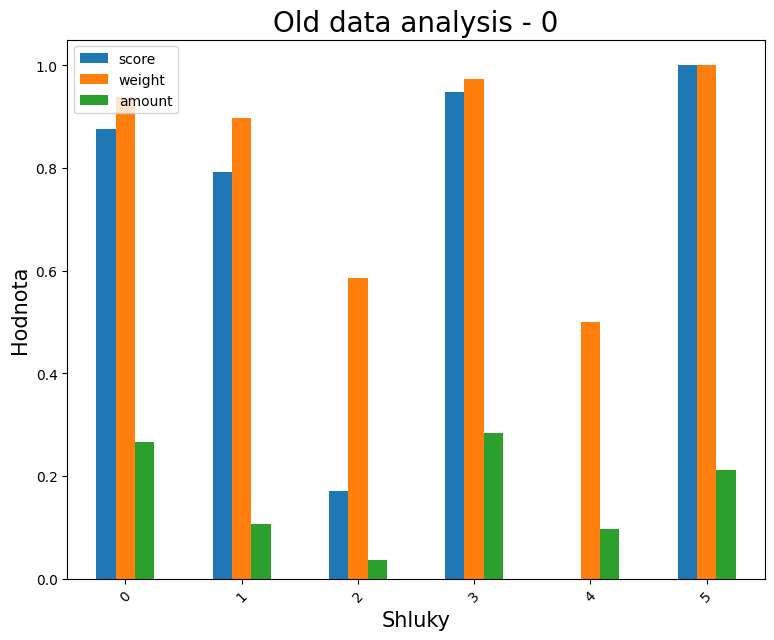

POTENTIAL AMOUNT 101
REDUCED AMOUNT 41
Extracted data 0  -  41
(163, 6)
(163, 5)


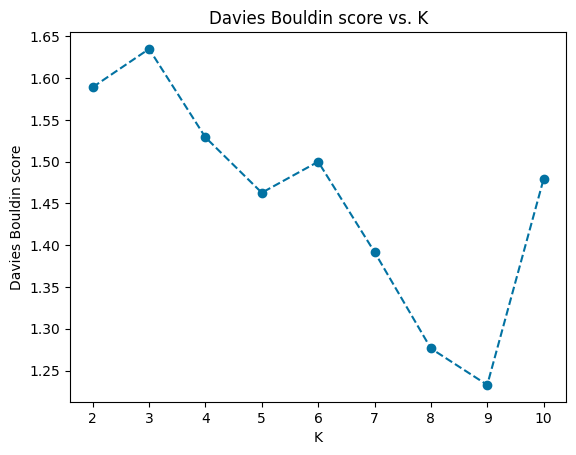

Final K parameter: 9
TOTAL ACC 0.8098159509202454


/home/netmon/.local/lib/python3.10/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


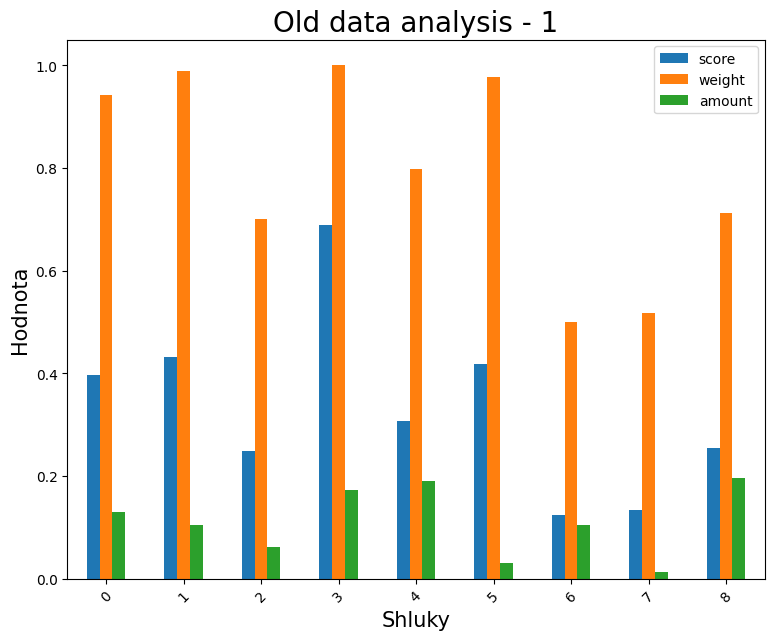

POTENTIAL AMOUNT 133
REDUCED AMOUNT 41
Extracted data 1  -  42
CPU times: user 4.72 s, sys: 680 ms, total: 5.4 s
Wall time: 1.99 s
Old data analysis - 0 To be extracted -  27
Old data analysis - 1 To be extracted -  27
(113, 6)
(113, 3)


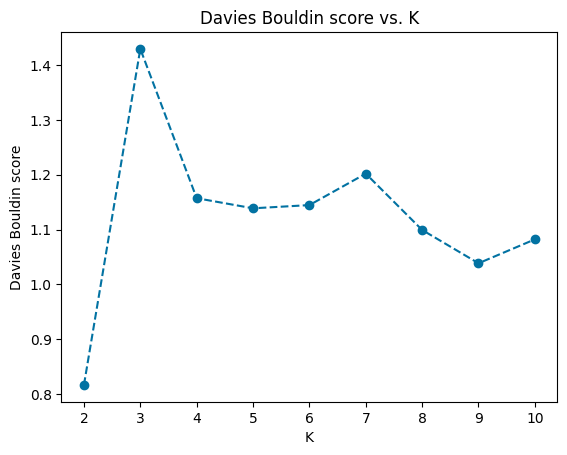

Final K parameter: 9
TOTAL ACC 0.49557522123893805


/home/netmon/.local/lib/python3.10/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


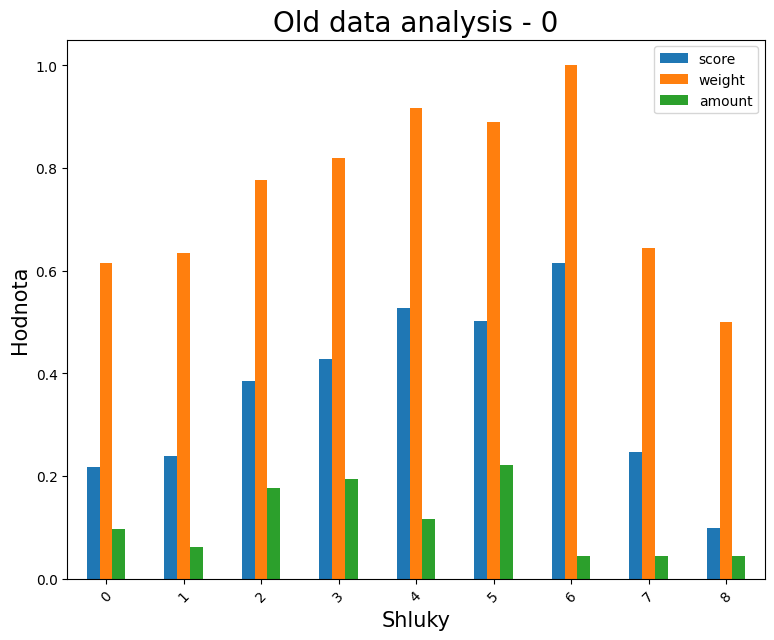

POTENTIAL AMOUNT 89
REDUCED AMOUNT 27
Extracted data 0  -  28
(163, 6)
(163, 5)


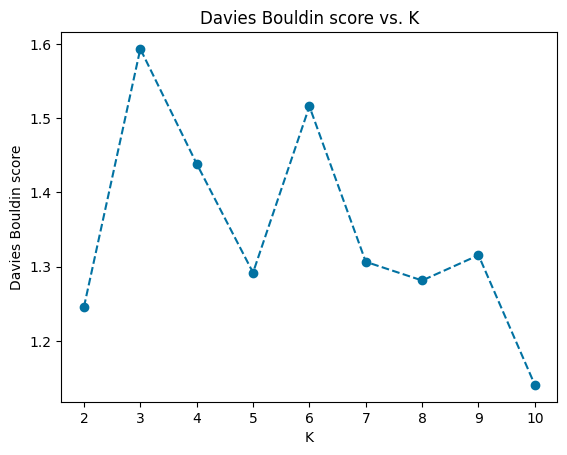

Final K parameter: 10
TOTAL ACC 0.8098159509202454


/home/netmon/.local/lib/python3.10/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


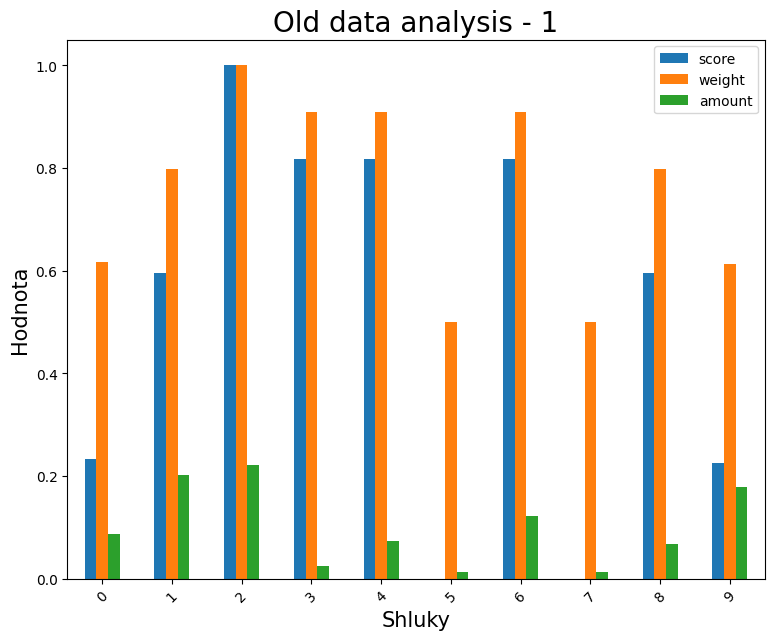

POTENTIAL AMOUNT 132
REDUCED AMOUNT 27
Extracted data 1  -  27
CPU times: user 4.84 s, sys: 651 ms, total: 5.49 s
Wall time: 2.07 s
Old data analysis - 0 To be extracted -  13
Old data analysis - 1 To be extracted -  13
(113, 6)
(113, 3)


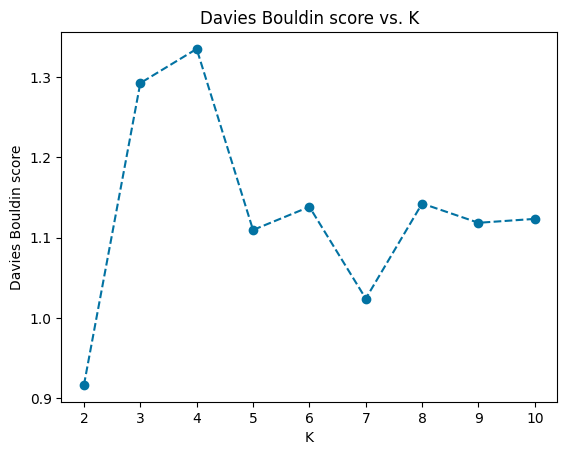

Final K parameter: 7
TOTAL ACC 0.49557522123893805


/home/netmon/.local/lib/python3.10/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


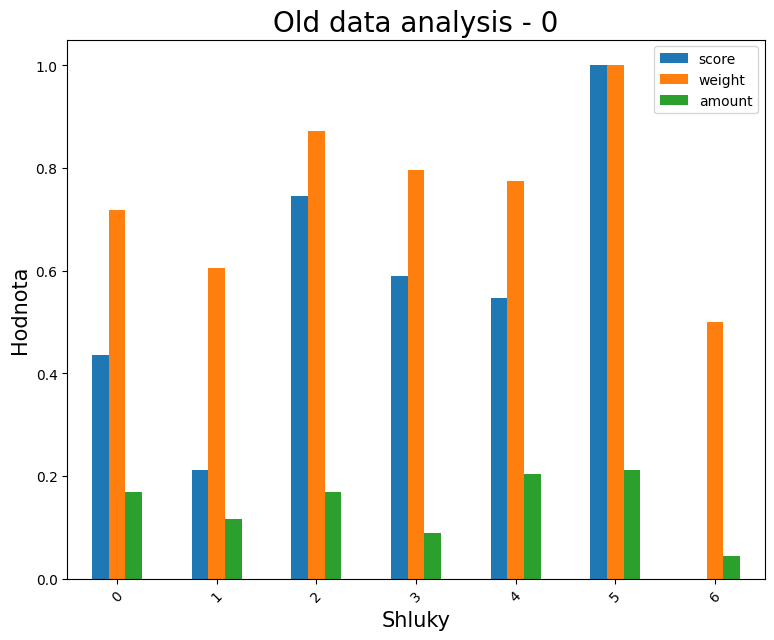

POTENTIAL AMOUNT 90
REDUCED AMOUNT 13
Extracted data 0  -  12
(163, 6)
(163, 5)


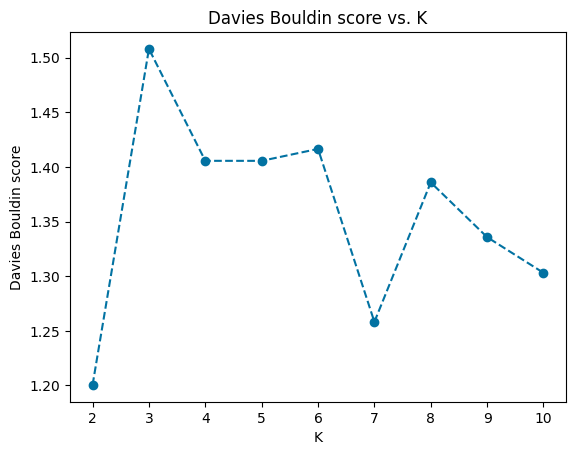

Final K parameter: 7
TOTAL ACC 0.8098159509202454


/home/netmon/.local/lib/python3.10/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


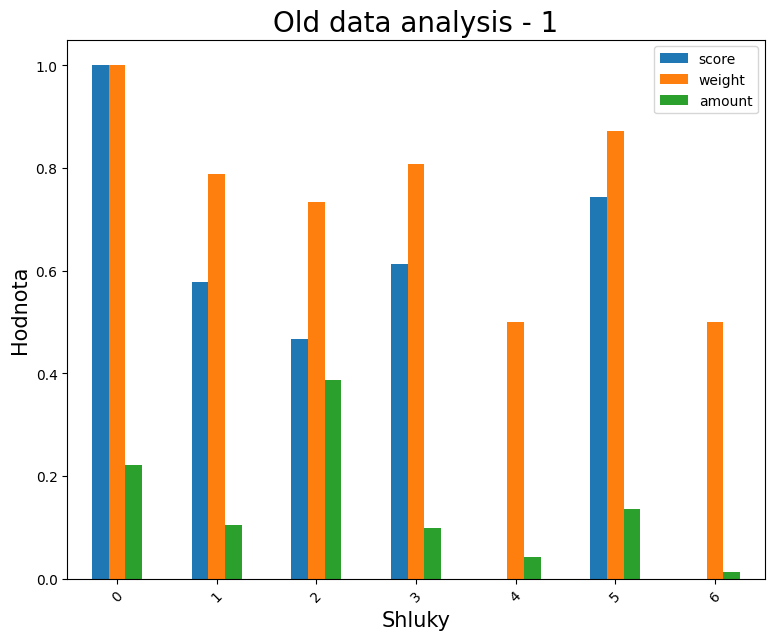

POTENTIAL AMOUNT 132
REDUCED AMOUNT 13
Extracted data 1  -  13
CPU times: user 5.83 s, sys: 694 ms, total: 6.53 s
Wall time: 2.03 s
Old data analysis - 0 To be extracted -  6
Old data analysis - 1 To be extracted -  6
(113, 6)
(113, 3)


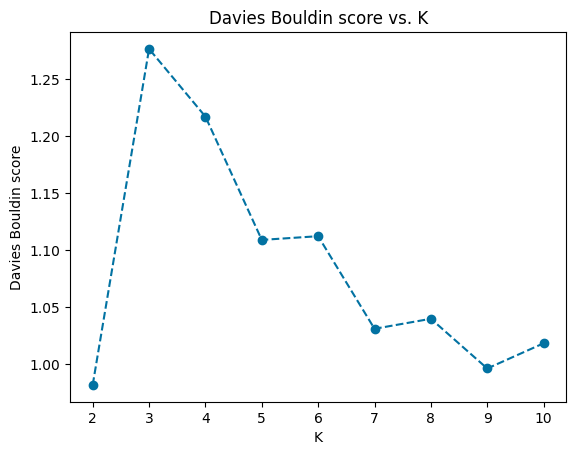

Final K parameter: 9
TOTAL ACC 0.49557522123893805


/home/netmon/.local/lib/python3.10/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


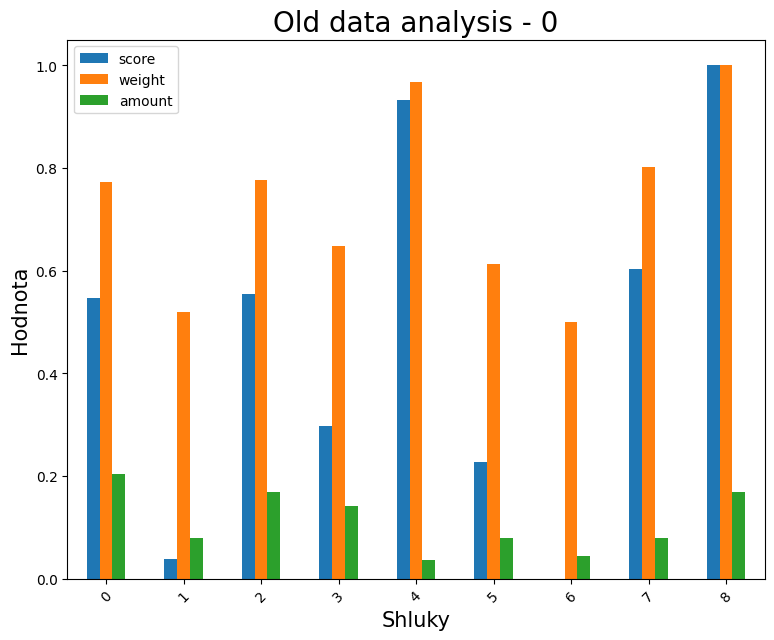

POTENTIAL AMOUNT 85
REDUCED AMOUNT 6
Extracted data 0  -  5
(163, 6)
(163, 5)


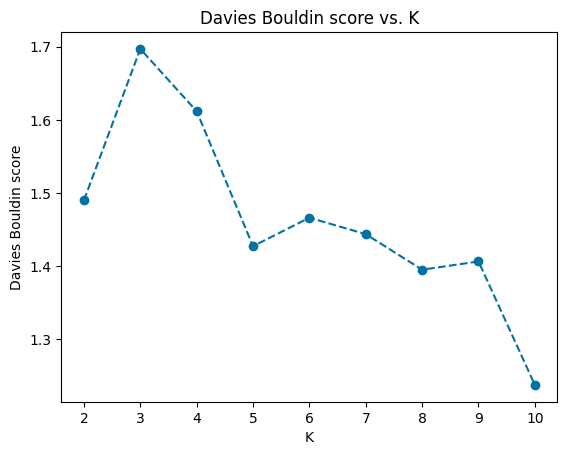

Final K parameter: 10
TOTAL ACC 0.8098159509202454


/home/netmon/.local/lib/python3.10/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


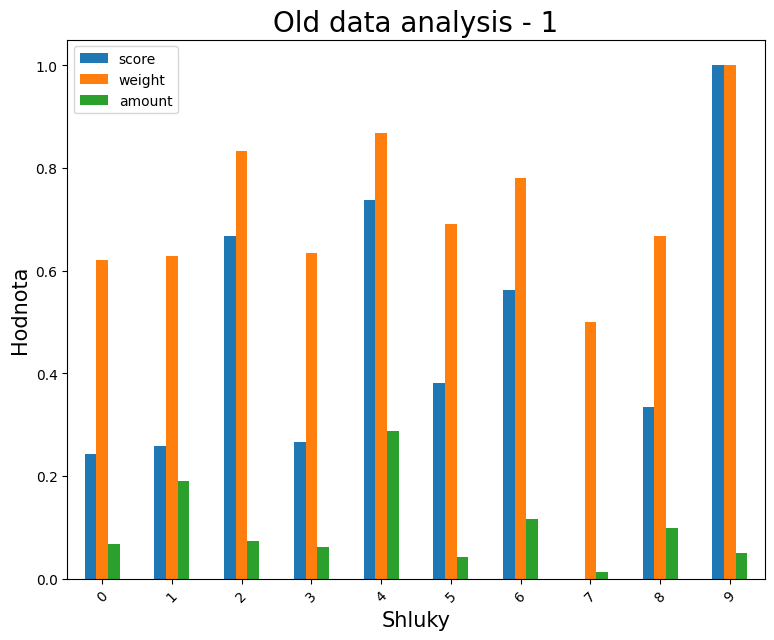

POTENTIAL AMOUNT 122
REDUCED AMOUNT 6
Extracted data 1  -  5
CPU times: user 5.59 s, sys: 684 ms, total: 6.27 s
Wall time: 2.15 s
{0: 12332, 1: 6688, 'all': 19020}


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: Undefin

old               precision    recall  f1-score   support

           0     1.0000    0.8914    0.9426      3804
           1     0.0000    0.0000    0.0000         0

    accuracy                         0.8914      3804
   macro avg     0.5000    0.4457    0.4713      3804
weighted avg     1.0000    0.8914    0.9426      3804



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


dumb               precision    recall  f1-score   support

           0     1.0000    0.8680    0.9294      3804
           1     0.0000    0.0000    0.0000         0

    accuracy                         0.8680      3804
   macro avg     0.5000    0.4340    0.4647      3804
weighted avg     1.0000    0.8680    0.9294      3804

Old data analysis - 0 To be extracted -  3804
Old data analysis - 1 To be extracted -  3804
{0: 3804, 1: 3804}
nearmiss1
CPU times: user 16.5 s, sys: 23.7 ms, total: 16.6 s
Wall time: 1.53 s
nearmiss2
CPU times: user 2min 46s, sys: 3.7 s, total: 2min 50s
Wall time: 24.9 s
nearmiss3
CPU times: user 18 s, sys: 142 ms, total: 18.1 s
Wall time: 2.06 s
randomsampler
CPU times: user 20.2 ms, sys: 6.85 ms, total: 27 ms
Wall time: 27.3 ms
clustercentroids


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


CPU times: user 9min 8s, sys: 8min 10s, total: 17min 18s
Wall time: 1min 27s
Old data analysis - 0 To be extracted -  3043
Old data analysis - 1 To be extracted -  3043
{0: 3043, 1: 3043}
nearmiss1
CPU times: user 14 s, sys: 51.8 ms, total: 14 s
Wall time: 1.33 s
nearmiss2
CPU times: user 2min 13s, sys: 3.29 s, total: 2min 16s
Wall time: 21.8 s
nearmiss3
CPU times: user 24.8 s, sys: 25.8 ms, total: 24.8 s
Wall time: 2.22 s
randomsampler
CPU times: user 14.4 ms, sys: 0 ns, total: 14.4 ms
Wall time: 14.6 ms
clustercentroids


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


CPU times: user 7min 21s, sys: 6min 21s, total: 13min 42s
Wall time: 1min 9s
Old data analysis - 0 To be extracted -  2282
Old data analysis - 1 To be extracted -  2282
{0: 2282, 1: 2282}
nearmiss1
CPU times: user 14.2 s, sys: 12.6 ms, total: 14.2 s
Wall time: 1.32 s
nearmiss2
CPU times: user 2min 13s, sys: 2.9 s, total: 2min 16s
Wall time: 21.5 s
nearmiss3
CPU times: user 20.8 s, sys: 19.4 ms, total: 20.8 s
Wall time: 1.91 s
randomsampler
CPU times: user 12.2 ms, sys: 1.02 ms, total: 13.2 ms
Wall time: 13.3 ms
clustercentroids


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


CPU times: user 5min 21s, sys: 4min 36s, total: 9min 58s
Wall time: 50.6 s
Old data analysis - 0 To be extracted -  1521
Old data analysis - 1 To be extracted -  1521
{0: 1521, 1: 1521}
nearmiss1
CPU times: user 14.2 s, sys: 33.8 ms, total: 14.2 s
Wall time: 1.32 s
nearmiss2
CPU times: user 2min 11s, sys: 3.45 s, total: 2min 14s
Wall time: 21.5 s
nearmiss3
CPU times: user 19.7 s, sys: 17.6 ms, total: 19.7 s
Wall time: 1.83 s
randomsampler
CPU times: user 18.9 ms, sys: 0 ns, total: 18.9 ms
Wall time: 19.2 ms
clustercentroids


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


CPU times: user 3min 44s, sys: 3min 12s, total: 6min 57s
Wall time: 35.4 s
Old data analysis - 0 To be extracted -  760
Old data analysis - 1 To be extracted -  760
{0: 760, 1: 760}
nearmiss1
CPU times: user 14.8 s, sys: 12.7 ms, total: 14.8 s
Wall time: 1.35 s
nearmiss2
CPU times: user 2min 17s, sys: 3.46 s, total: 2min 21s
Wall time: 22.3 s
nearmiss3
CPU times: user 19 s, sys: 20.9 ms, total: 19 s
Wall time: 1.75 s
randomsampler
CPU times: user 12.7 ms, sys: 0 ns, total: 12.7 ms
Wall time: 12.8 ms
clustercentroids


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


CPU times: user 2min 4s, sys: 1min 37s, total: 3min 42s
Wall time: 19 s
Old data analysis - 0 To be extracted -  380
Old data analysis - 1 To be extracted -  380
{0: 380, 1: 380}
nearmiss1
CPU times: user 14.1 s, sys: 41.2 ms, total: 14.2 s
Wall time: 1.34 s
nearmiss2
CPU times: user 2min 22s, sys: 3.34 s, total: 2min 25s
Wall time: 22.8 s
nearmiss3
CPU times: user 20 s, sys: 51.8 ms, total: 20 s
Wall time: 1.87 s
randomsampler
CPU times: user 18 ms, sys: 3.79 ms, total: 21.8 ms
Wall time: 22.1 ms
clustercentroids


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


CPU times: user 1min 16s, sys: 50.7 s, total: 2min 7s
Wall time: 11.1 s
kmeans
bouldin
Old data analysis - 0 To be extracted -  3804
Old data analysis - 1 To be extracted -  3804
(8528, 10)
(8528, 9)


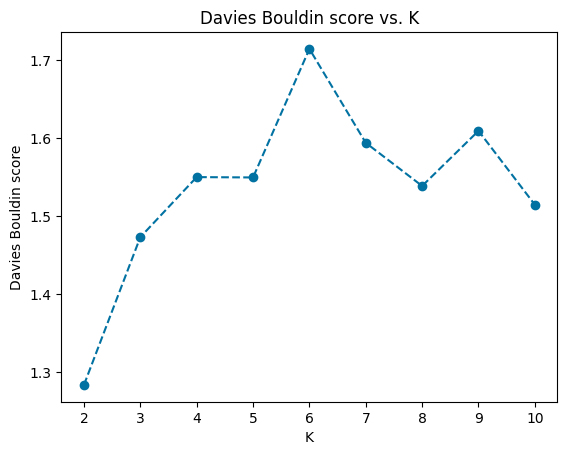

Final K parameter: 3


/home/netmon/.local/lib/python3.10/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


TOTAL ACC 0.8809803001876173


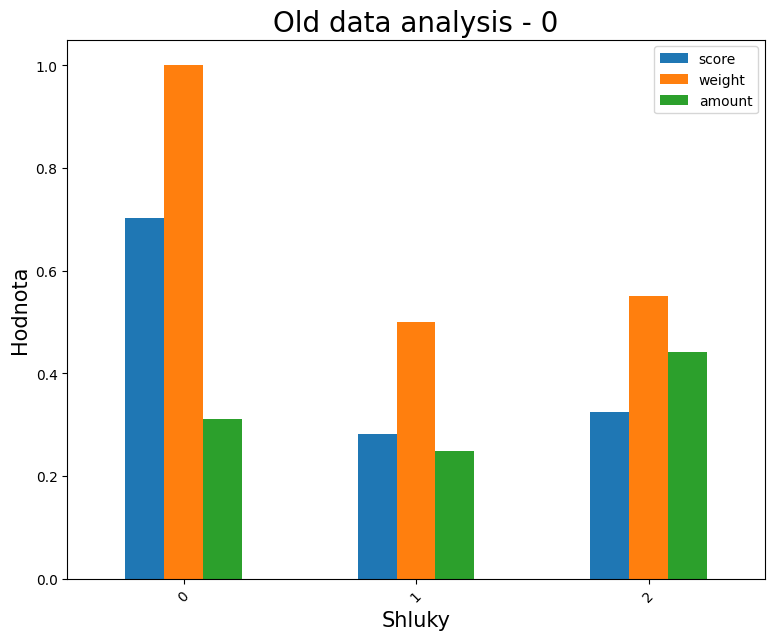

POTENTIAL AMOUNT 5782
REDUCED AMOUNT 3804
Extracted data 0  -  3805
(6688, 10)
(6688, 9)


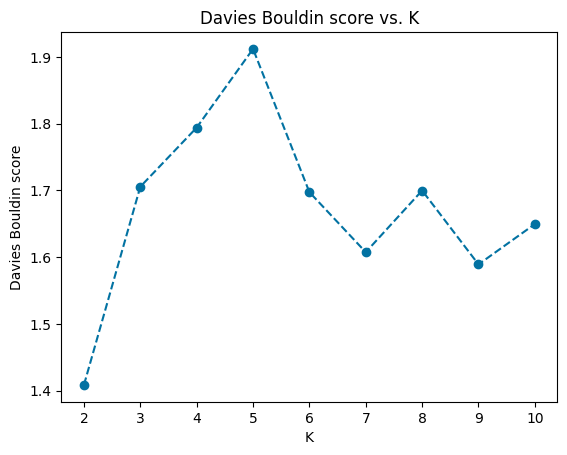

Final K parameter: 9


/home/netmon/.local/lib/python3.10/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


TOTAL ACC 0.7214413875598086


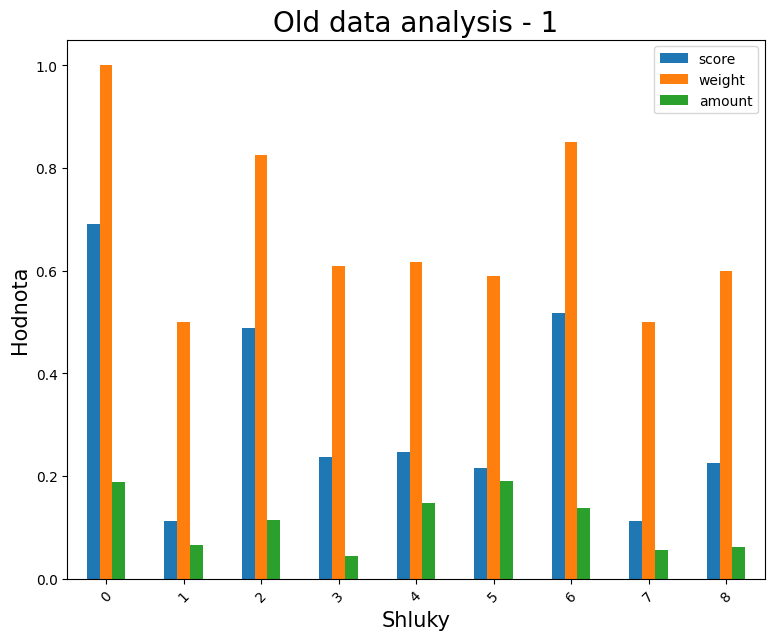

POTENTIAL AMOUNT 4841
REDUCED AMOUNT 3804
Extracted data 1  -  3804
CPU times: user 58.5 s, sys: 17.7 s, total: 1min 16s
Wall time: 10.1 s
Old data analysis - 0 To be extracted -  3043
Old data analysis - 1 To be extracted -  3043
(8528, 10)
(8528, 9)


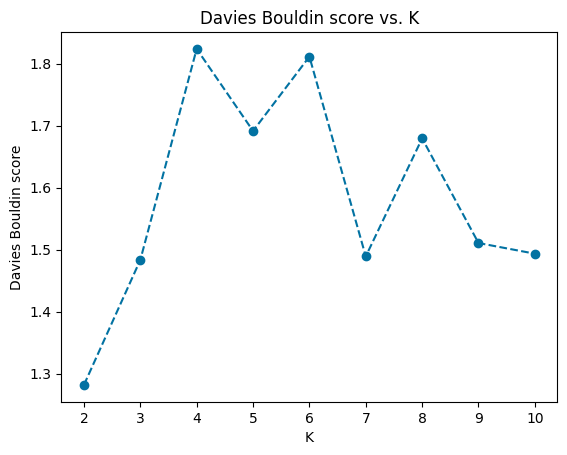

Final K parameter: 3


/home/netmon/.local/lib/python3.10/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


TOTAL ACC 0.8809803001876173


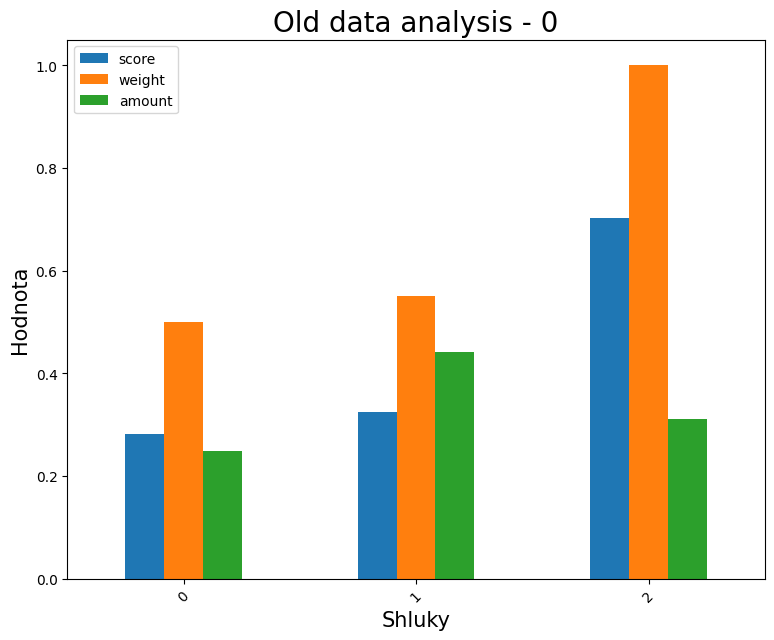

POTENTIAL AMOUNT 5782
REDUCED AMOUNT 3043
Extracted data 0  -  3044
(6688, 10)
(6688, 9)


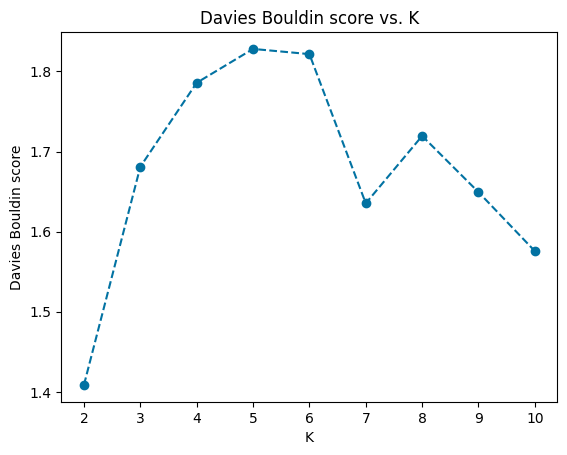

Final K parameter: 10


/home/netmon/.local/lib/python3.10/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


TOTAL ACC 0.7214413875598086


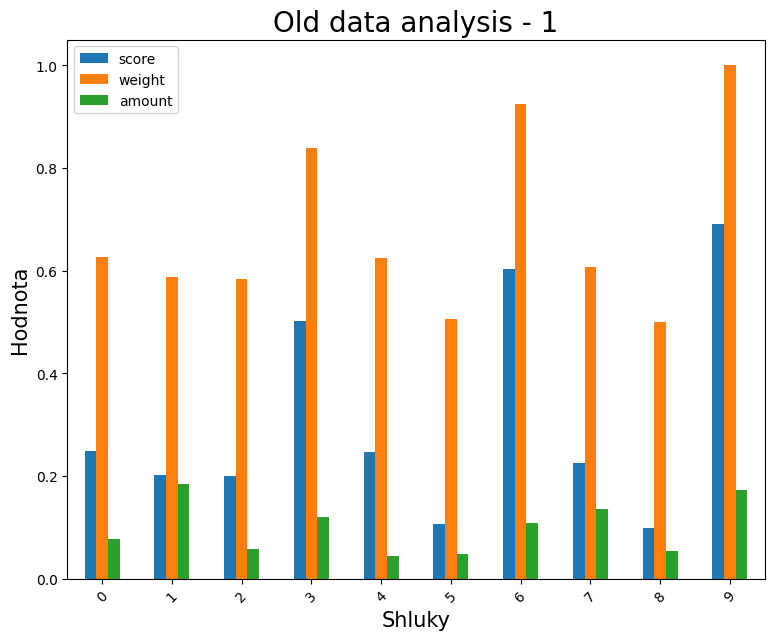

POTENTIAL AMOUNT 4839
REDUCED AMOUNT 3043
Extracted data 1  -  3044
CPU times: user 1min, sys: 17.2 s, total: 1min 17s
Wall time: 10.4 s
Old data analysis - 0 To be extracted -  2282
Old data analysis - 1 To be extracted -  2282
(8528, 10)
(8528, 9)


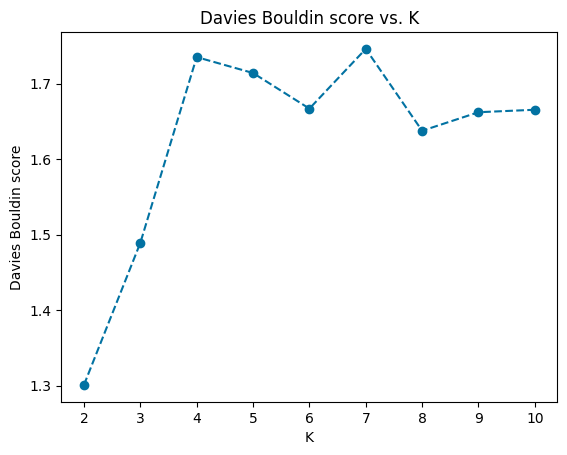

Final K parameter: 3


/home/netmon/.local/lib/python3.10/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


TOTAL ACC 0.8809803001876173


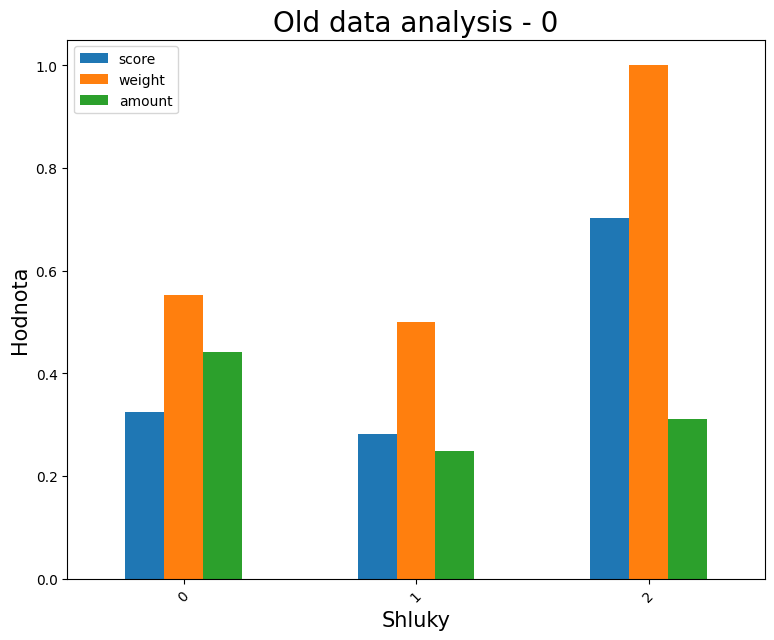

POTENTIAL AMOUNT 5784
REDUCED AMOUNT 2282
Extracted data 0  -  2283
(6688, 10)
(6688, 9)


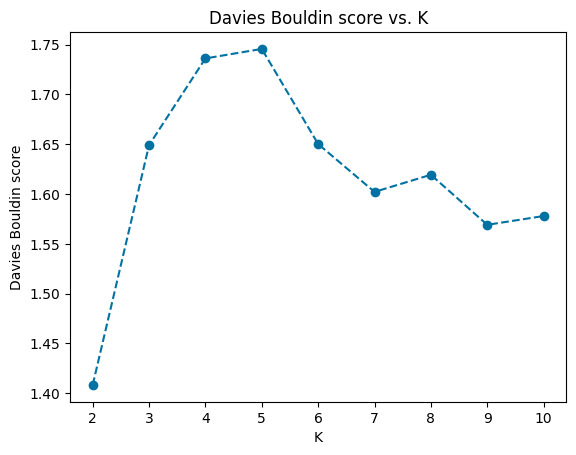

Final K parameter: 9


/home/netmon/.local/lib/python3.10/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


TOTAL ACC 0.7214413875598086


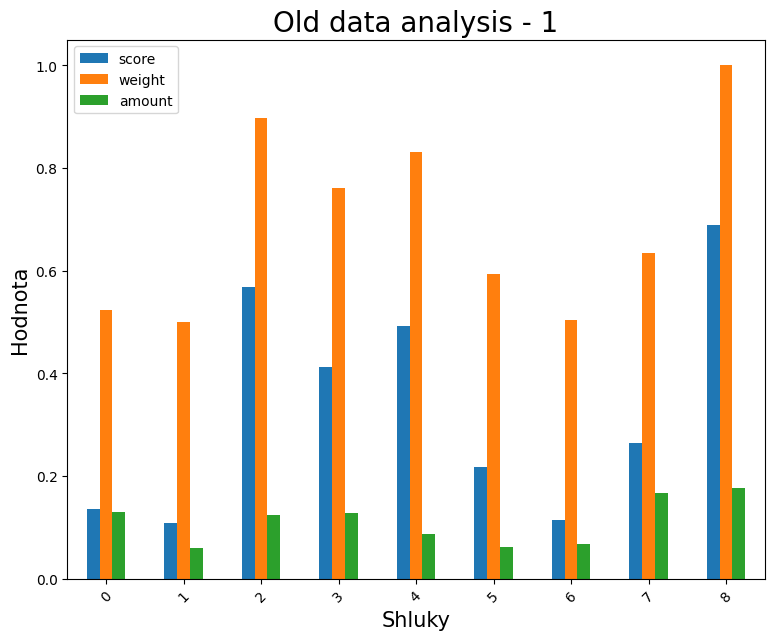

POTENTIAL AMOUNT 4889
REDUCED AMOUNT 2282
Extracted data 1  -  2283
CPU times: user 57.3 s, sys: 17.3 s, total: 1min 14s
Wall time: 10 s
Old data analysis - 0 To be extracted -  1521
Old data analysis - 1 To be extracted -  1521
(8528, 10)
(8528, 9)


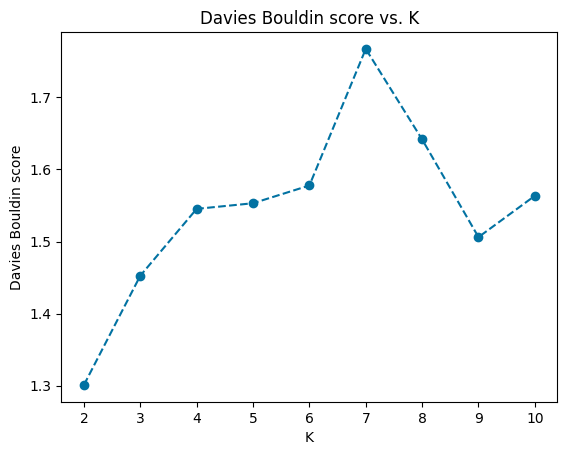

Final K parameter: 3


/home/netmon/.local/lib/python3.10/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


TOTAL ACC 0.8809803001876173


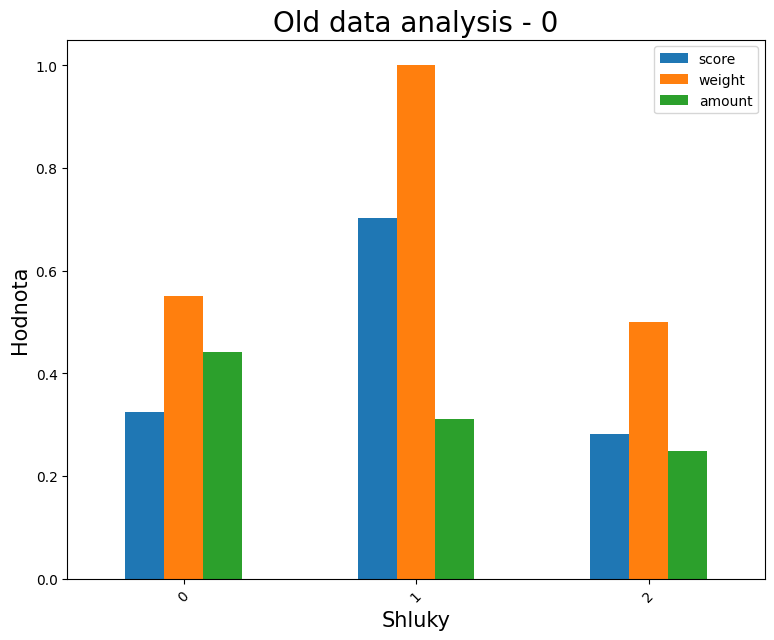

POTENTIAL AMOUNT 5782
REDUCED AMOUNT 1521
Extracted data 0  -  1521
(6688, 10)
(6688, 9)


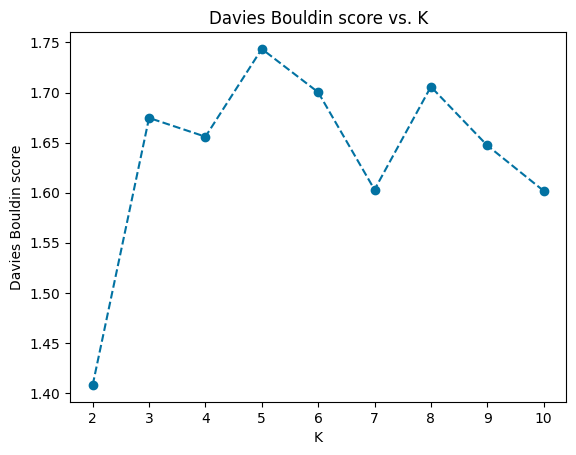

Final K parameter: 10


/home/netmon/.local/lib/python3.10/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


TOTAL ACC 0.7214413875598086


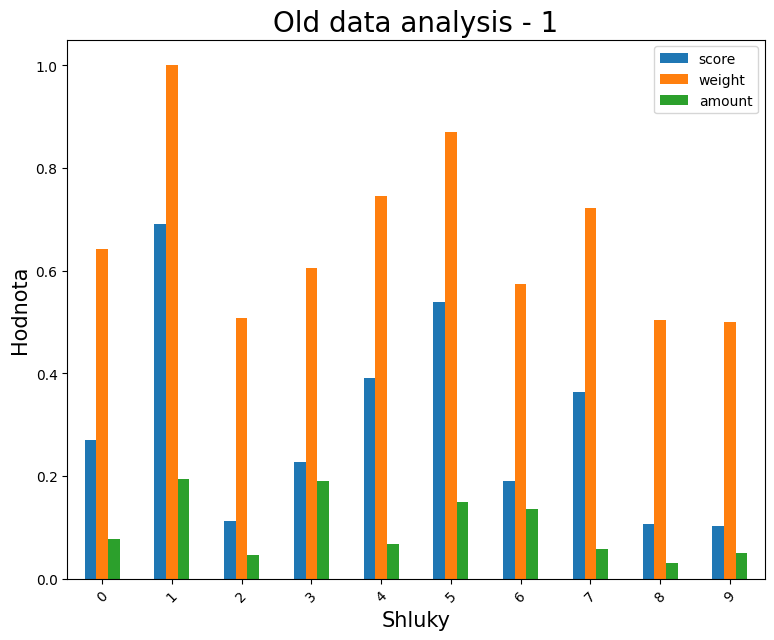

POTENTIAL AMOUNT 4838
REDUCED AMOUNT 1521
Extracted data 1  -  1522
CPU times: user 52.8 s, sys: 17.3 s, total: 1min 10s
Wall time: 9.57 s
Old data analysis - 0 To be extracted -  760
Old data analysis - 1 To be extracted -  760
(8528, 10)
(8528, 9)


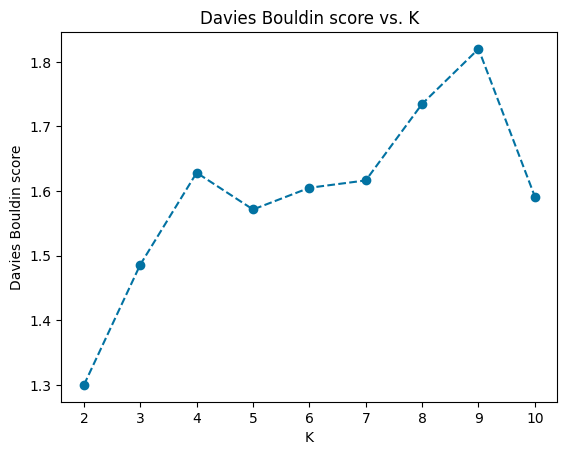

Final K parameter: 3


/home/netmon/.local/lib/python3.10/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


TOTAL ACC 0.8809803001876173


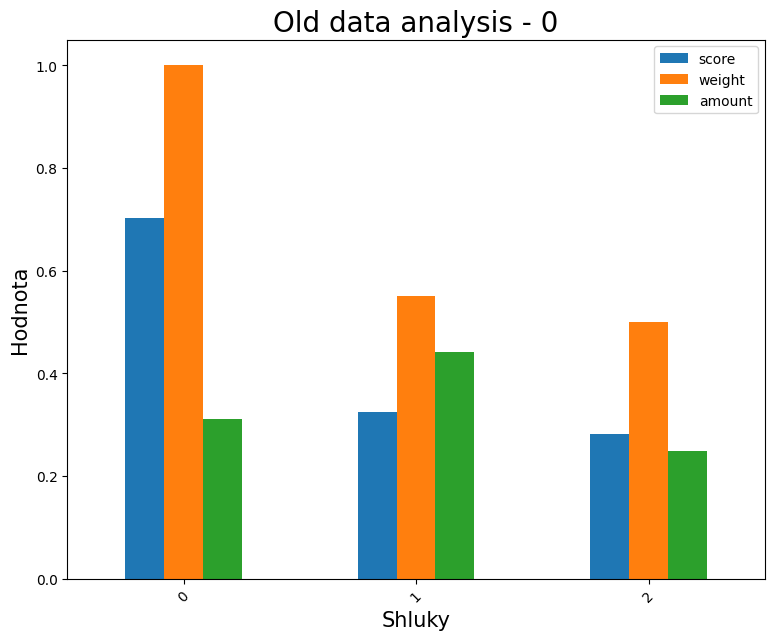

POTENTIAL AMOUNT 5783
REDUCED AMOUNT 760
Extracted data 0  -  760
(6688, 10)
(6688, 9)


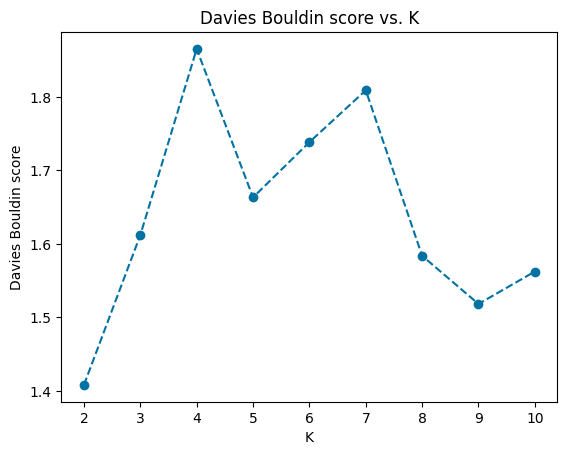

Final K parameter: 9


/home/netmon/.local/lib/python3.10/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


TOTAL ACC 0.7214413875598086


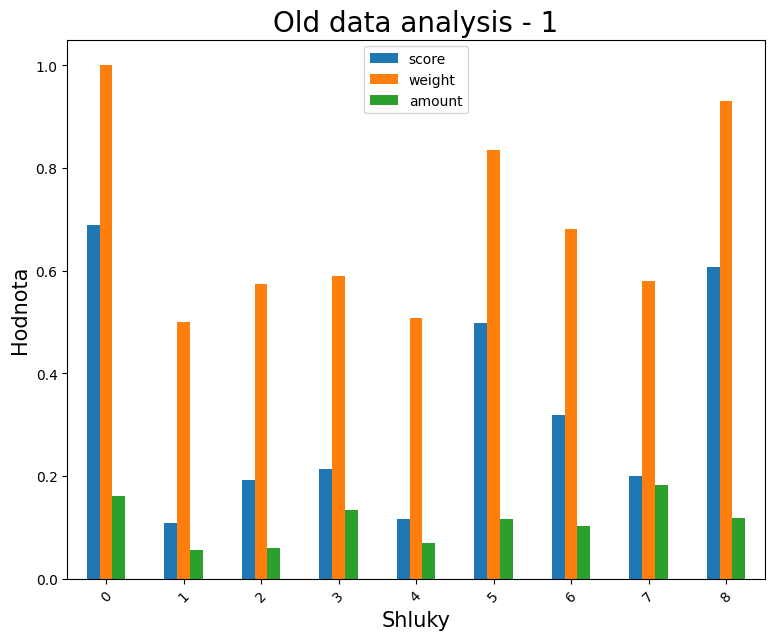

POTENTIAL AMOUNT 4816
REDUCED AMOUNT 760
Extracted data 1  -  760
CPU times: user 51.4 s, sys: 17.3 s, total: 1min 8s
Wall time: 9.41 s
Old data analysis - 0 To be extracted -  380
Old data analysis - 1 To be extracted -  380
(8528, 10)
(8528, 9)


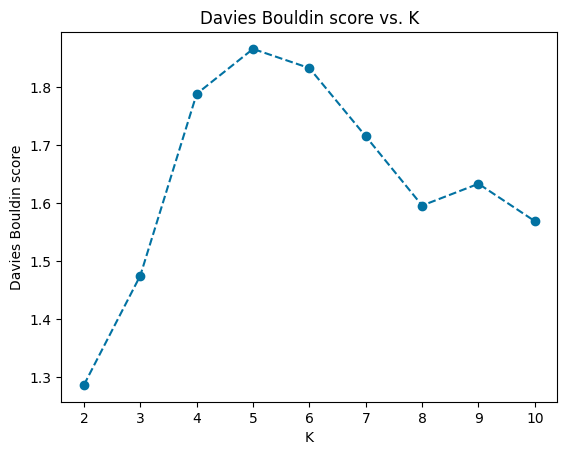

Final K parameter: 3


/home/netmon/.local/lib/python3.10/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


TOTAL ACC 0.8809803001876173


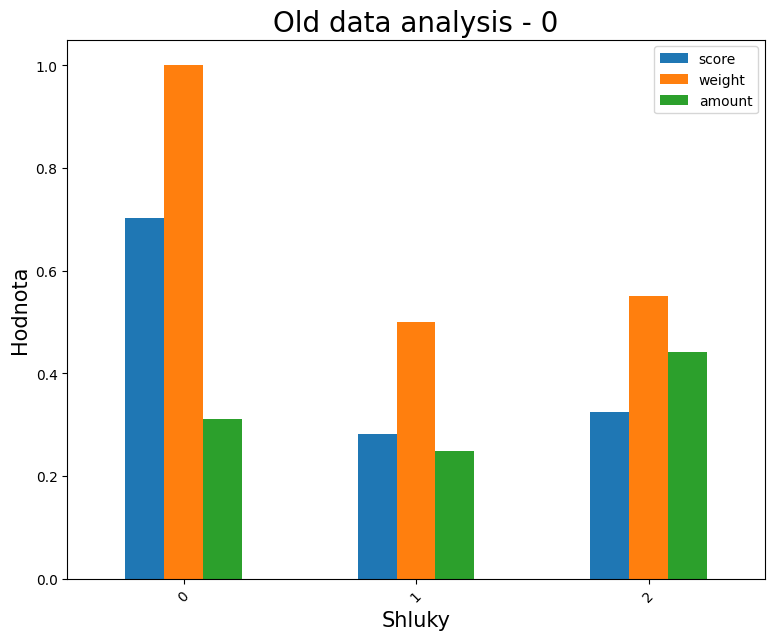

POTENTIAL AMOUNT 5782
REDUCED AMOUNT 380
Extracted data 0  -  379
(6688, 10)
(6688, 9)


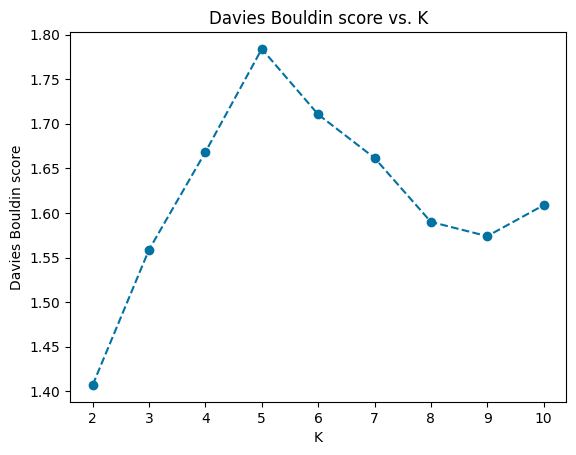

Final K parameter: 3


/home/netmon/.local/lib/python3.10/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


TOTAL ACC 0.7214413875598086


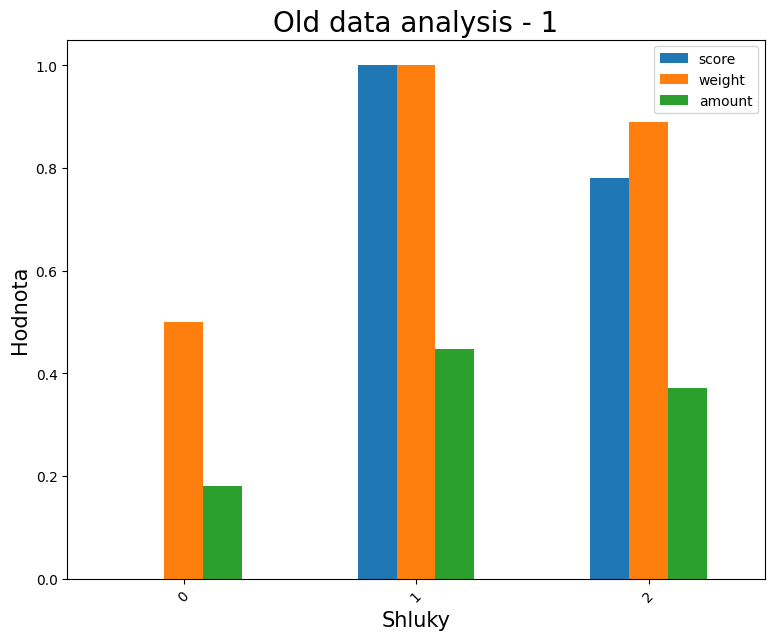

POTENTIAL AMOUNT 5810
REDUCED AMOUNT 380
Extracted data 1  -  380
CPU times: user 54.2 s, sys: 16.9 s, total: 1min 11s
Wall time: 9.79 s
{0: 204, 1: 228, 'all': 432}
old               precision    recall  f1-score   support

           0     0.7037    0.8261    0.7600        23
           1     0.9333    0.8750    0.9032        64

    accuracy                         0.8621        87
   macro avg     0.8185    0.8505    0.8316        87
weighted avg     0.8726    0.8621    0.8654        87

dumb               precision    recall  f1-score   support

           0     0.5714    0.6957    0.6275        23
           1     0.8814    0.8125    0.8455        64

    accuracy                         0.7816        87
   macro avg     0.7264    0.7541    0.7365        87
weighted avg     0.7994    0.7816    0.7879        87

Old data analysis - 0 To be extracted -  86
Old data analysis - 1 To be extracted -  86
{0: 86, 1: 86}
nearmiss1
CPU times: user 25.3 ms, sys: 10.4 ms, total: 35.7 ms
Wall

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


CPU times: user 1.34 s, sys: 6.66 ms, total: 1.35 s
Wall time: 567 ms
Old data analysis - 0 To be extracted -  69
Old data analysis - 1 To be extracted -  69
{0: 69, 1: 69}
nearmiss1
CPU times: user 29.4 ms, sys: 5.63 ms, total: 35 ms
Wall time: 31.5 ms
nearmiss2
CPU times: user 31.3 ms, sys: 10.4 ms, total: 41.8 ms
Wall time: 33.4 ms
nearmiss3
CPU times: user 42.5 ms, sys: 12.6 ms, total: 55.1 ms
Wall time: 47.9 ms
randomsampler
CPU times: user 6.25 ms, sys: 94 µs, total: 6.35 ms
Wall time: 6.44 ms
clustercentroids


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


CPU times: user 1.39 s, sys: 8.36 ms, total: 1.4 s
Wall time: 477 ms
Old data analysis - 0 To be extracted -  51
Old data analysis - 1 To be extracted -  51
{0: 51, 1: 51}
nearmiss1
CPU times: user 27 ms, sys: 4.03 ms, total: 31.1 ms
Wall time: 27.7 ms
nearmiss2
CPU times: user 33.9 ms, sys: 5.72 ms, total: 39.6 ms
Wall time: 32 ms
nearmiss3
CPU times: user 358 ms, sys: 112 ms, total: 470 ms
Wall time: 462 ms
randomsampler
CPU times: user 7.05 ms, sys: 33 µs, total: 7.08 ms
Wall time: 7.03 ms
clustercentroids


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


CPU times: user 1.12 s, sys: 6.44 ms, total: 1.13 s
Wall time: 343 ms
Old data analysis - 0 To be extracted -  34
Old data analysis - 1 To be extracted -  34
{0: 34, 1: 34}
nearmiss1
CPU times: user 23.6 ms, sys: 6.15 ms, total: 29.7 ms
Wall time: 26.6 ms
nearmiss2
CPU times: user 31.7 ms, sys: 7.61 ms, total: 39.3 ms
Wall time: 31.5 ms
nearmiss3
CPU times: user 42.6 ms, sys: 14.9 ms, total: 57.5 ms
Wall time: 50.7 ms
randomsampler
CPU times: user 6.71 ms, sys: 2 ms, total: 8.71 ms
Wall time: 8.74 ms
clustercentroids


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


CPU times: user 1.11 s, sys: 2.88 ms, total: 1.11 s
Wall time: 261 ms
Old data analysis - 0 To be extracted -  17
Old data analysis - 1 To be extracted -  17
{0: 17, 1: 17}
nearmiss1
CPU times: user 29.5 ms, sys: 4.92 ms, total: 34.4 ms
Wall time: 30.7 ms
nearmiss2
CPU times: user 35.7 ms, sys: 6.21 ms, total: 41.9 ms
Wall time: 33.2 ms
nearmiss3
CPU times: user 43.8 ms, sys: 9.82 ms, total: 53.6 ms
Wall time: 47.1 ms
randomsampler
CPU times: user 6.51 ms, sys: 0 ns, total: 6.51 ms
Wall time: 6.52 ms
clustercentroids


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


CPU times: user 923 ms, sys: 0 ns, total: 923 ms
Wall time: 139 ms
Old data analysis - 0 To be extracted -  8
Old data analysis - 1 To be extracted -  8
{0: 8, 1: 8}
nearmiss1
CPU times: user 23.6 ms, sys: 7.6 ms, total: 31.2 ms
Wall time: 27.9 ms
nearmiss2
CPU times: user 33.4 ms, sys: 6.97 ms, total: 40.3 ms
Wall time: 32.1 ms
nearmiss3
CPU times: user 43.8 ms, sys: 10.8 ms, total: 54.6 ms
Wall time: 47.2 ms
randomsampler
CPU times: user 6.39 ms, sys: 0 ns, total: 6.39 ms
Wall time: 6.49 ms
clustercentroids


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


CPU times: user 867 ms, sys: 6.37 ms, total: 873 ms
Wall time: 89 ms
kmeans
bouldin
Old data analysis - 0 To be extracted -  86
Old data analysis - 1 To be extracted -  86
(181, 6)
(181, 5)


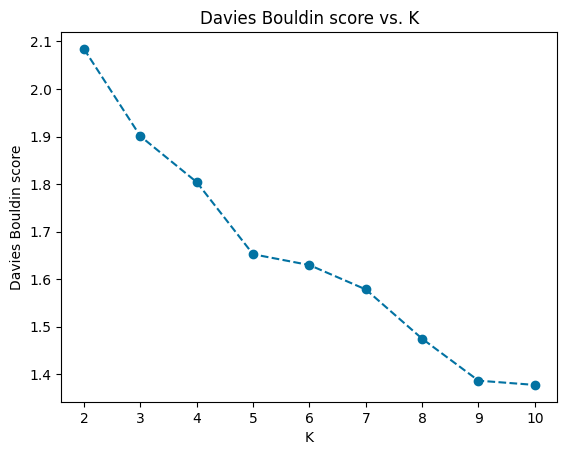

Final K parameter: 10
TOTAL ACC 0.9116022099447514


/home/netmon/.local/lib/python3.10/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


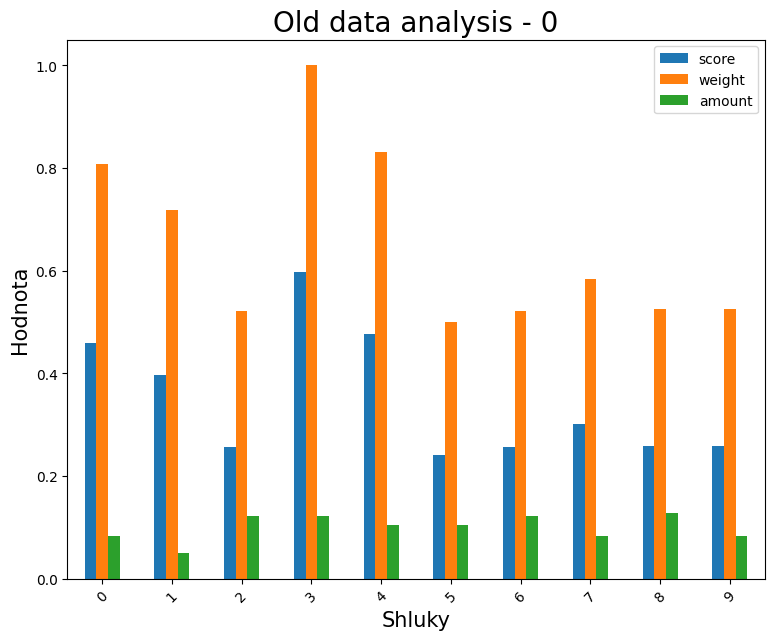

POTENTIAL AMOUNT 117
REDUCED AMOUNT 86
Extracted data 0  -  86
(164, 6)
(164, 1)


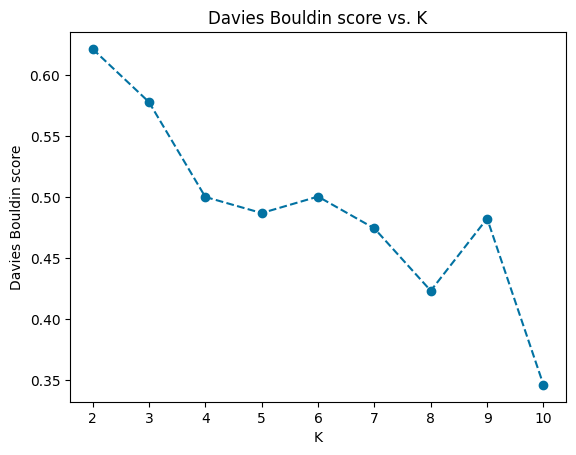

Final K parameter: 10
TOTAL ACC 0.8536585365853658


/home/netmon/.local/lib/python3.10/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


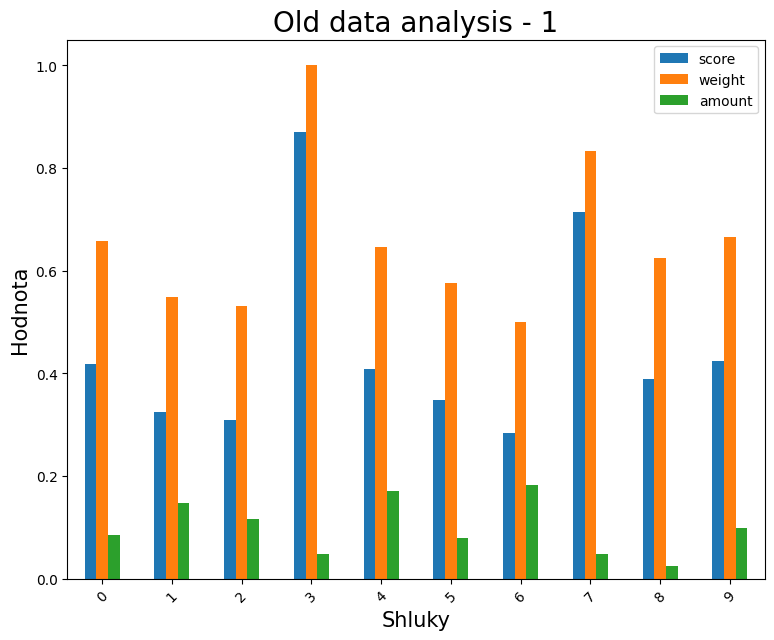

POTENTIAL AMOUNT 100
REDUCED AMOUNT 86
Extracted data 1  -  87
CPU times: user 4.89 s, sys: 784 ms, total: 5.68 s
Wall time: 2.22 s
Old data analysis - 0 To be extracted -  69
Old data analysis - 1 To be extracted -  69
(181, 6)
(181, 5)


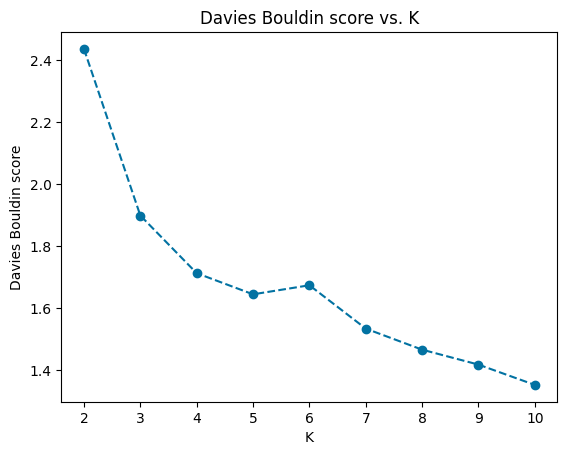

Final K parameter: 10
TOTAL ACC 0.9116022099447514


/home/netmon/.local/lib/python3.10/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


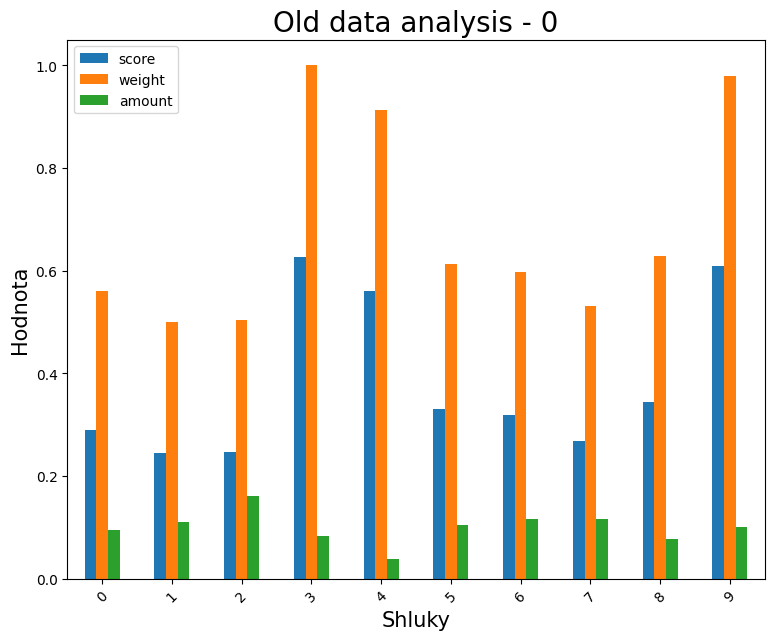

POTENTIAL AMOUNT 117
REDUCED AMOUNT 69
Extracted data 0  -  70
(164, 6)
(164, 1)


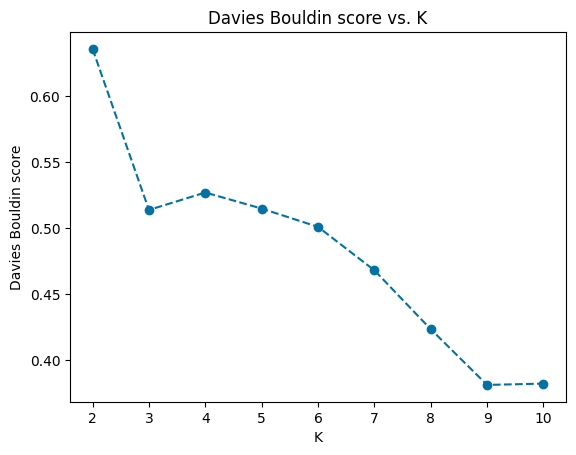

Final K parameter: 9
TOTAL ACC 0.8536585365853658


/home/netmon/.local/lib/python3.10/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


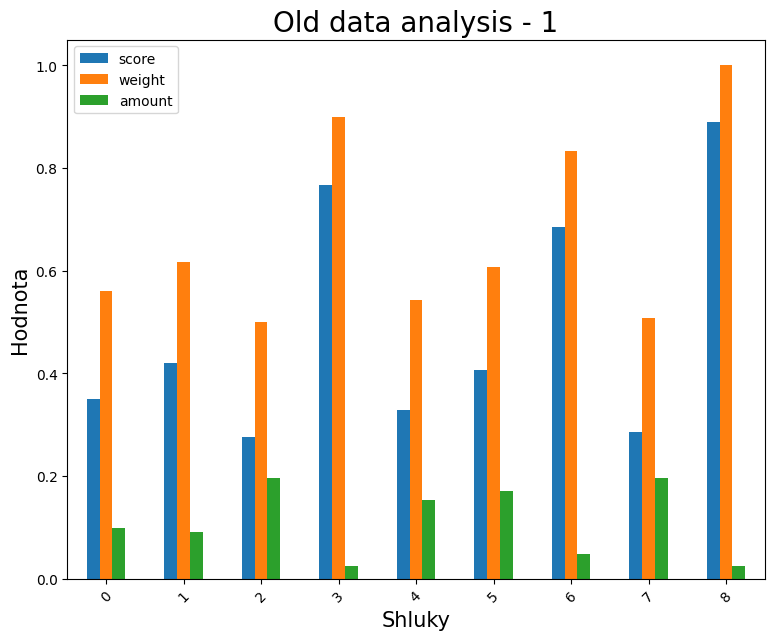

POTENTIAL AMOUNT 95
REDUCED AMOUNT 69
Extracted data 1  -  71
CPU times: user 4.72 s, sys: 749 ms, total: 5.46 s
Wall time: 2.09 s
Old data analysis - 0 To be extracted -  51
Old data analysis - 1 To be extracted -  51
(181, 6)
(181, 5)


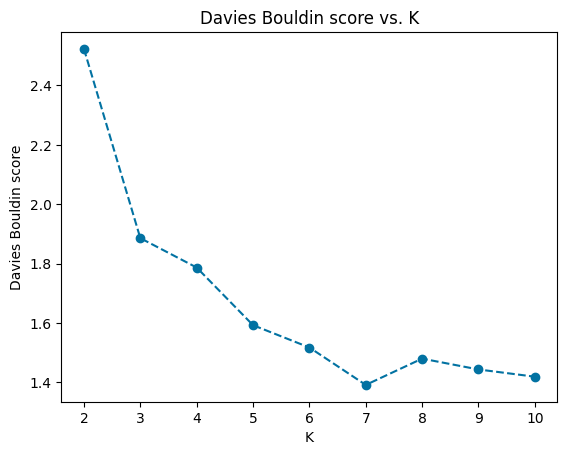

Final K parameter: 7
TOTAL ACC 0.9116022099447514


/home/netmon/.local/lib/python3.10/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


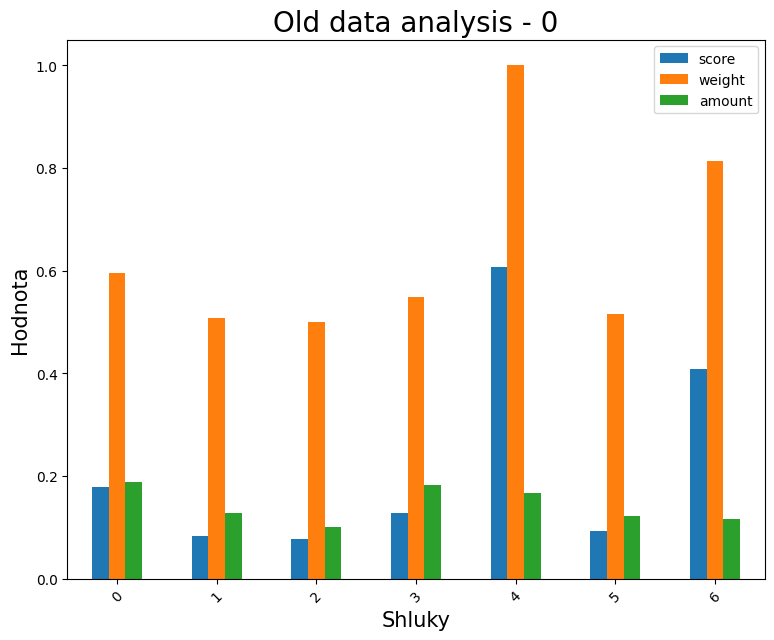

POTENTIAL AMOUNT 117
REDUCED AMOUNT 51
Extracted data 0  -  51
(164, 6)
(164, 1)


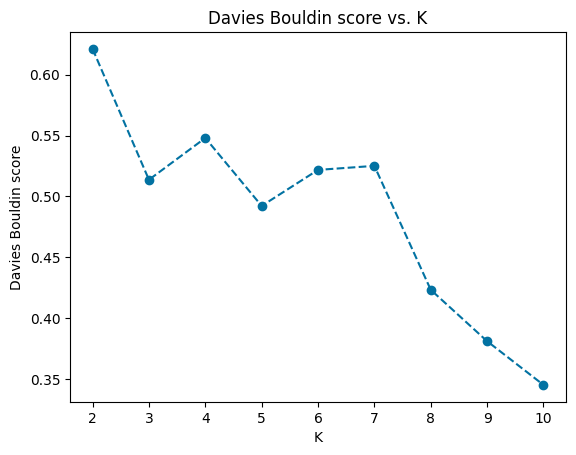

Final K parameter: 10
TOTAL ACC 0.8536585365853658


/home/netmon/.local/lib/python3.10/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


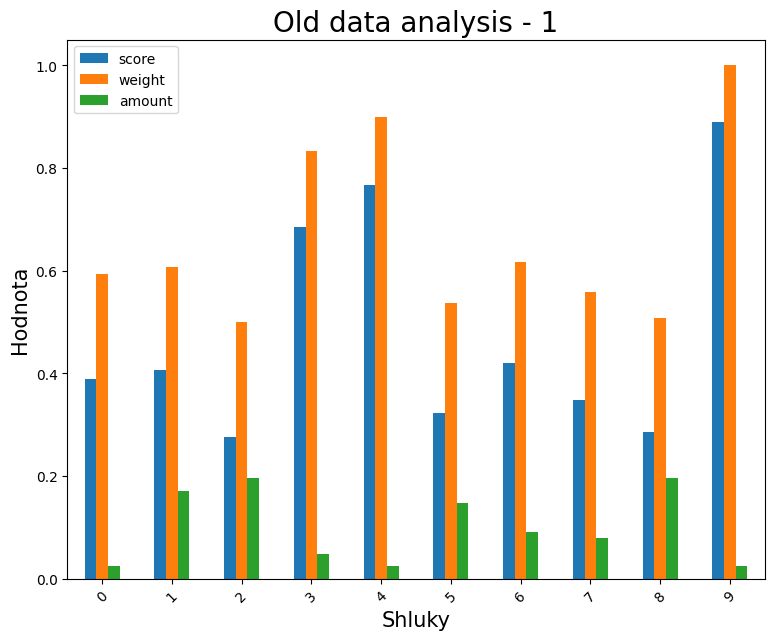

POTENTIAL AMOUNT 95
REDUCED AMOUNT 51
Extracted data 1  -  52
CPU times: user 4.84 s, sys: 665 ms, total: 5.5 s
Wall time: 1.99 s
Old data analysis - 0 To be extracted -  34
Old data analysis - 1 To be extracted -  34
(181, 6)
(181, 5)


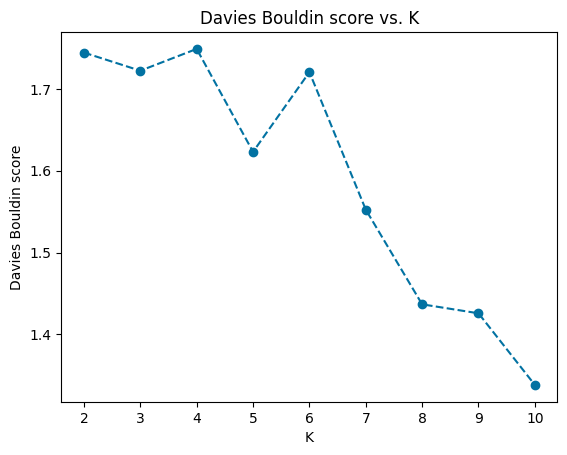

Final K parameter: 10
TOTAL ACC 0.9116022099447514


/home/netmon/.local/lib/python3.10/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


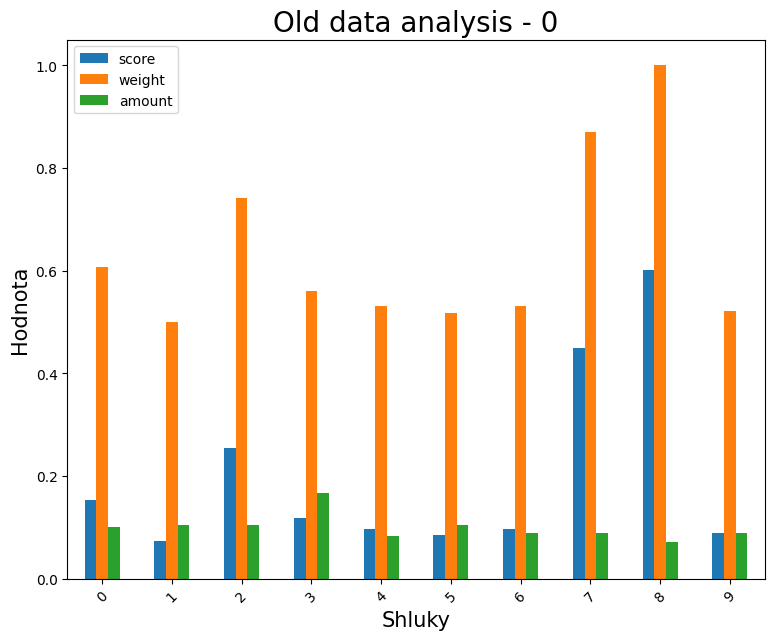

POTENTIAL AMOUNT 112
REDUCED AMOUNT 34
Extracted data 0  -  34
(164, 6)
(164, 1)


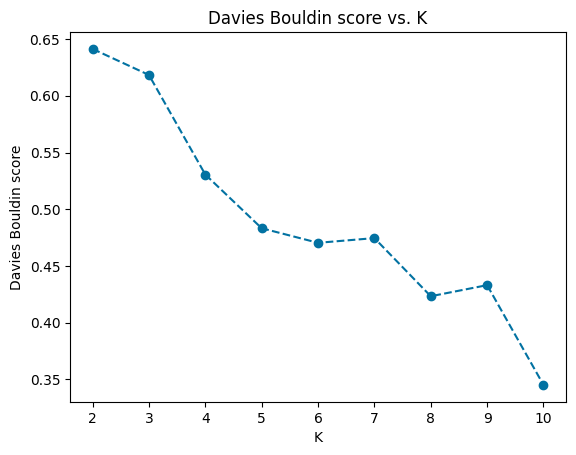

Final K parameter: 10
TOTAL ACC 0.8536585365853658


/home/netmon/.local/lib/python3.10/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


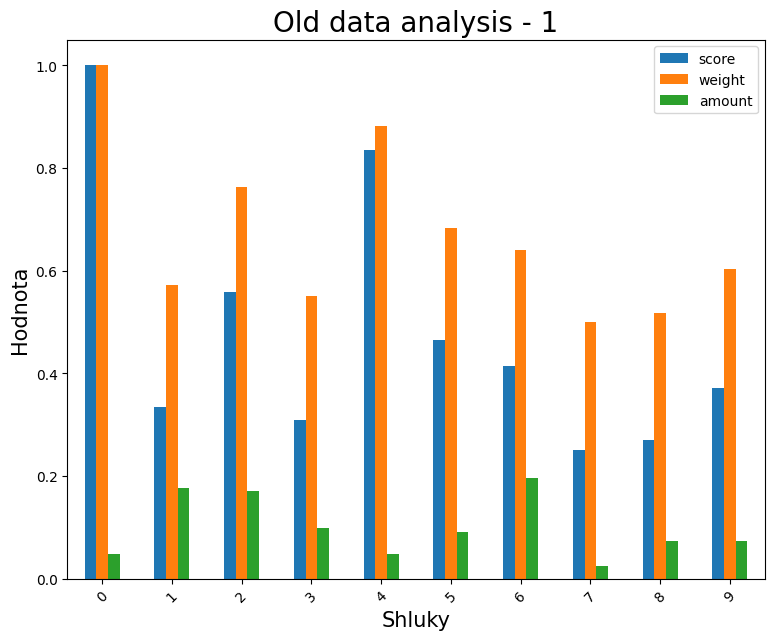

POTENTIAL AMOUNT 108
REDUCED AMOUNT 34
Extracted data 1  -  34
CPU times: user 5.03 s, sys: 675 ms, total: 5.7 s
Wall time: 2.08 s
Old data analysis - 0 To be extracted -  17
Old data analysis - 1 To be extracted -  17
(181, 6)
(181, 5)


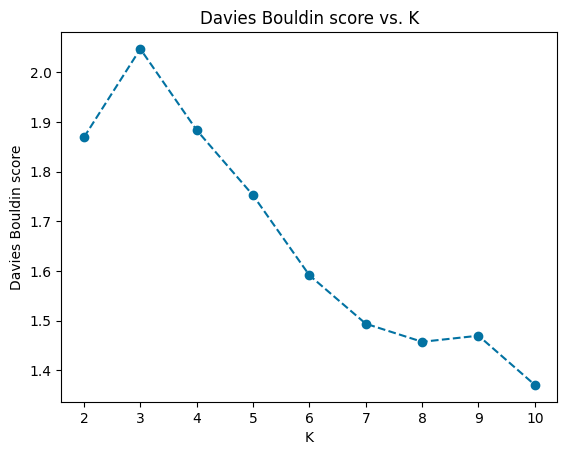

Final K parameter: 10
TOTAL ACC 0.9116022099447514


/home/netmon/.local/lib/python3.10/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


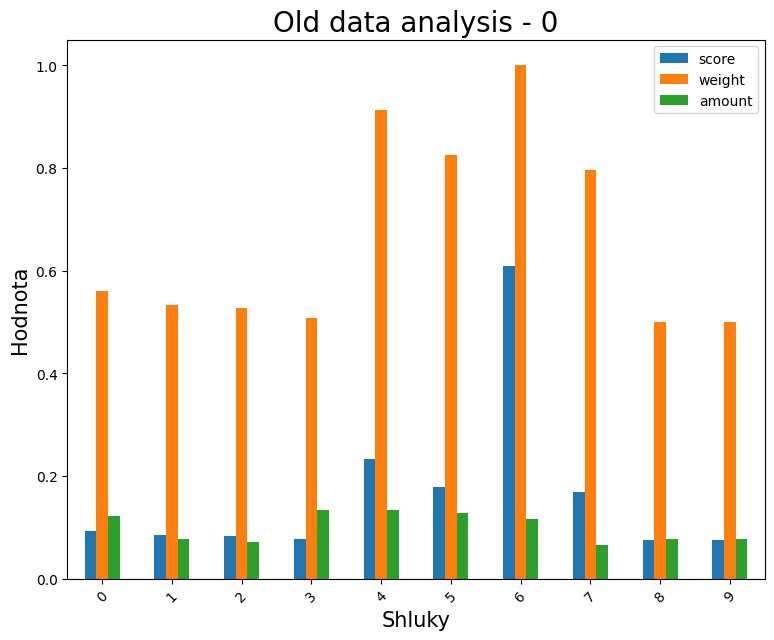

POTENTIAL AMOUNT 124
REDUCED AMOUNT 17
Extracted data 0  -  18
(164, 6)
(164, 1)


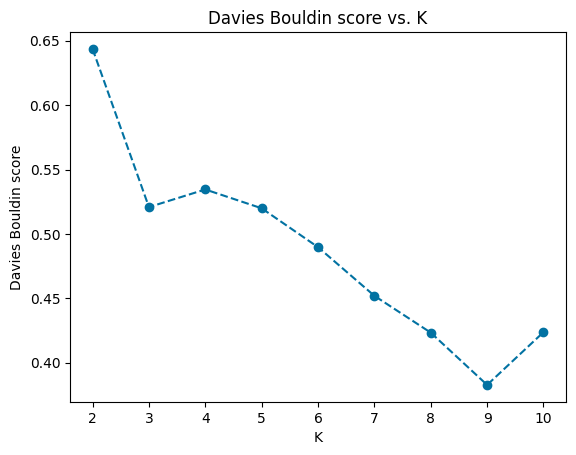

Final K parameter: 9
TOTAL ACC 0.8536585365853658


/home/netmon/.local/lib/python3.10/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


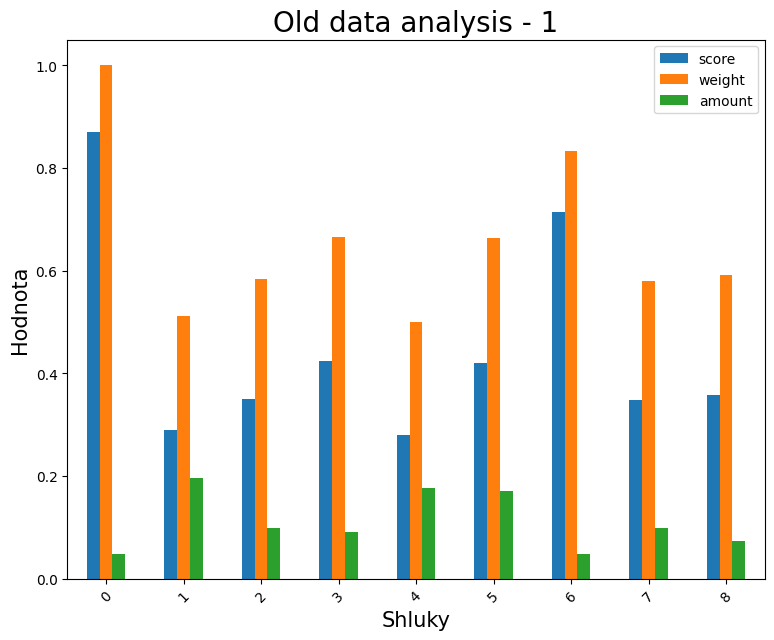

POTENTIAL AMOUNT 99
REDUCED AMOUNT 17
Extracted data 1  -  17
CPU times: user 4.88 s, sys: 662 ms, total: 5.54 s
Wall time: 2.07 s
Old data analysis - 0 To be extracted -  8
Old data analysis - 1 To be extracted -  8
(181, 6)
(181, 5)


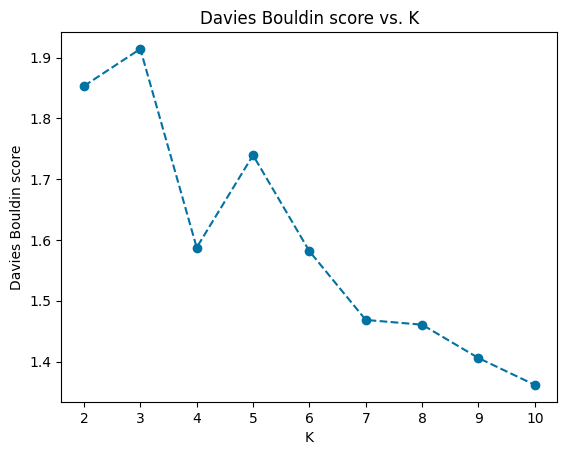

Final K parameter: 10


/home/netmon/.local/lib/python3.10/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


TOTAL ACC 0.9116022099447514


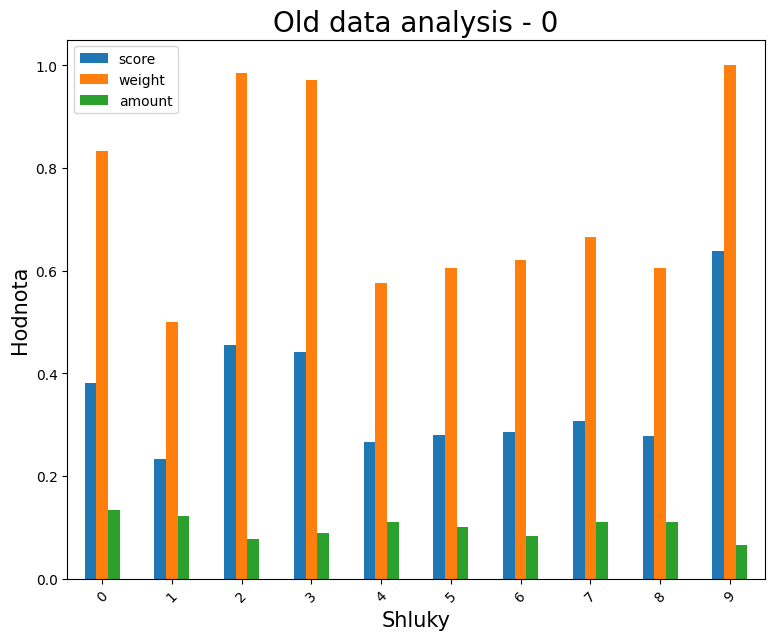

POTENTIAL AMOUNT 129
REDUCED AMOUNT 8
Extracted data 0  -  10
(164, 6)
(164, 1)


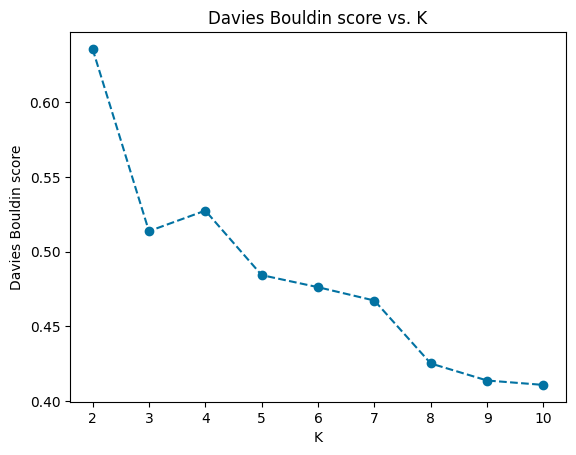

Final K parameter: 10
TOTAL ACC 0.8536585365853658


/home/netmon/.local/lib/python3.10/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


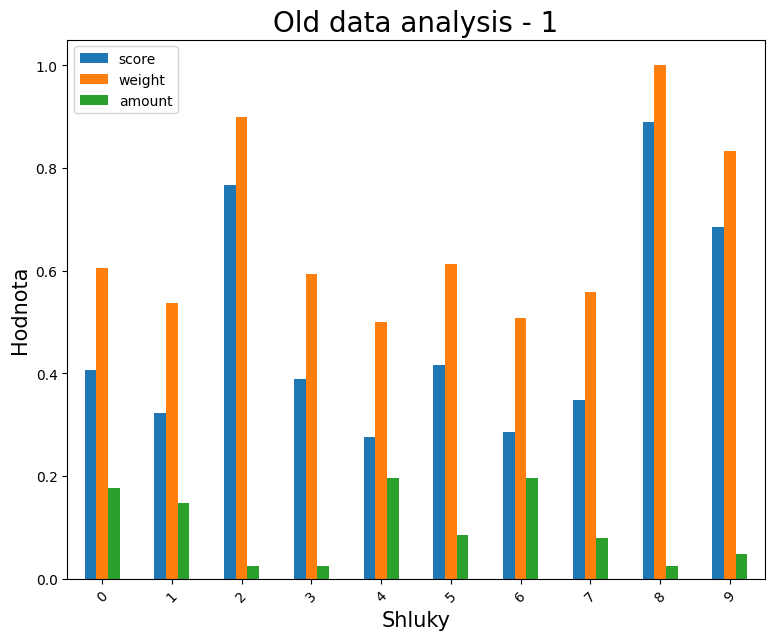

POTENTIAL AMOUNT 95
REDUCED AMOUNT 8
Extracted data 1  -  7
CPU times: user 5.51 s, sys: 766 ms, total: 6.28 s
Wall time: 2.62 s
{0: 500, 1: 268, 'all': 768}
old               precision    recall  f1-score   support

           0     0.7685    0.8300    0.7981       100
           1     0.6304    0.5370    0.5800        54

    accuracy                         0.7273       154
   macro avg     0.6995    0.6835    0.6890       154
weighted avg     0.7201    0.7273    0.7216       154

dumb               precision    recall  f1-score   support

           0     0.7317    0.9000    0.8072       100
           1     0.6774    0.3889    0.4941        54

    accuracy                         0.7208       154
   macro avg     0.7046    0.6444    0.6506       154
weighted avg     0.7127    0.7208    0.6974       154

Old data analysis - 0 To be extracted -  153
Old data analysis - 1 To be extracted -  153
{0: 153, 1: 153}
nearmiss1
CPU times: user 26.4 ms, sys: 11.2 ms, total: 37.5 ms
Wall tim

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


CPU times: user 2.43 s, sys: 45.3 ms, total: 2.47 s
Wall time: 1.15 s
Old data analysis - 0 To be extracted -  122
Old data analysis - 1 To be extracted -  122
{0: 122, 1: 122}
nearmiss1
CPU times: user 29.5 ms, sys: 8.57 ms, total: 38 ms
Wall time: 32.3 ms
nearmiss2
CPU times: user 50.1 ms, sys: 13.3 ms, total: 63.4 ms
Wall time: 43.9 ms
nearmiss3
CPU times: user 47.6 ms, sys: 14.7 ms, total: 62.3 ms
Wall time: 52.3 ms
randomsampler
CPU times: user 8.67 ms, sys: 0 ns, total: 8.67 ms
Wall time: 8.73 ms
clustercentroids


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


CPU times: user 2.08 s, sys: 16.5 ms, total: 2.09 s
Wall time: 934 ms
Old data analysis - 0 To be extracted -  92
Old data analysis - 1 To be extracted -  92
{0: 92, 1: 92}
nearmiss1
CPU times: user 31.1 ms, sys: 5.07 ms, total: 36.2 ms
Wall time: 30.5 ms
nearmiss2
CPU times: user 46.9 ms, sys: 8.41 ms, total: 55.3 ms
Wall time: 38.7 ms
nearmiss3
CPU times: user 43.2 ms, sys: 14.9 ms, total: 58.1 ms
Wall time: 48.1 ms
randomsampler
CPU times: user 6.84 ms, sys: 0 ns, total: 6.84 ms
Wall time: 6.94 ms
clustercentroids


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


CPU times: user 2.11 s, sys: 28.2 ms, total: 2.14 s
Wall time: 752 ms
Old data analysis - 0 To be extracted -  61
Old data analysis - 1 To be extracted -  61
{0: 61, 1: 61}
nearmiss1
CPU times: user 29.1 ms, sys: 7.08 ms, total: 36.2 ms
Wall time: 30.6 ms
nearmiss2
CPU times: user 51 ms, sys: 6.63 ms, total: 57.6 ms
Wall time: 41.4 ms
nearmiss3
CPU times: user 49.6 ms, sys: 10.8 ms, total: 60.4 ms
Wall time: 50.5 ms
randomsampler
CPU times: user 7.07 ms, sys: 62 µs, total: 7.13 ms
Wall time: 7.24 ms
clustercentroids


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


CPU times: user 2.03 s, sys: 33.8 ms, total: 2.07 s
Wall time: 547 ms
Old data analysis - 0 To be extracted -  30
Old data analysis - 1 To be extracted -  30
{0: 30, 1: 30}
nearmiss1
CPU times: user 29.3 ms, sys: 6.14 ms, total: 35.5 ms
Wall time: 29.9 ms
nearmiss2
CPU times: user 49.9 ms, sys: 9.6 ms, total: 59.5 ms
Wall time: 41.9 ms
nearmiss3
CPU times: user 49.6 ms, sys: 11 ms, total: 60.7 ms
Wall time: 50.6 ms
randomsampler
CPU times: user 7.04 ms, sys: 0 ns, total: 7.04 ms
Wall time: 7.15 ms
clustercentroids


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


CPU times: user 1.62 s, sys: 16.6 ms, total: 1.64 s
Wall time: 335 ms
Old data analysis - 0 To be extracted -  15
Old data analysis - 1 To be extracted -  15
{0: 15, 1: 15}
nearmiss1
CPU times: user 28.8 ms, sys: 6.69 ms, total: 35.5 ms
Wall time: 30.2 ms
nearmiss2
CPU times: user 50.8 ms, sys: 6.46 ms, total: 57.3 ms
Wall time: 41.1 ms
nearmiss3
CPU times: user 49.2 ms, sys: 11.2 ms, total: 60.4 ms
Wall time: 49.9 ms
randomsampler
CPU times: user 7.15 ms, sys: 0 ns, total: 7.15 ms
Wall time: 7.25 ms
clustercentroids


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


CPU times: user 1.62 s, sys: 14.4 ms, total: 1.64 s
Wall time: 233 ms
kmeans
bouldin
Old data analysis - 0 To be extracted -  153
Old data analysis - 1 To be extracted -  153
(400, 8)
(400, 6)


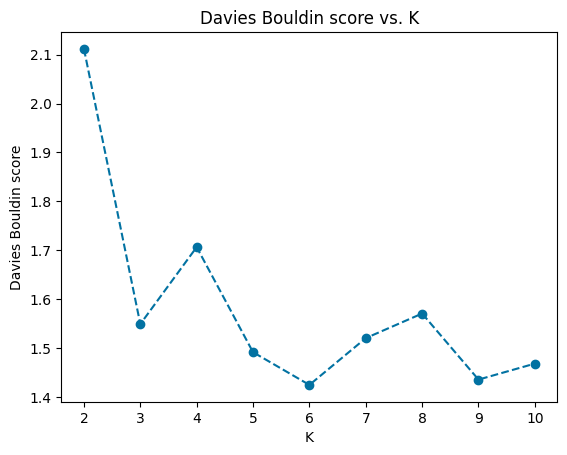

Final K parameter: 6
TOTAL ACC 0.85


/home/netmon/.local/lib/python3.10/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


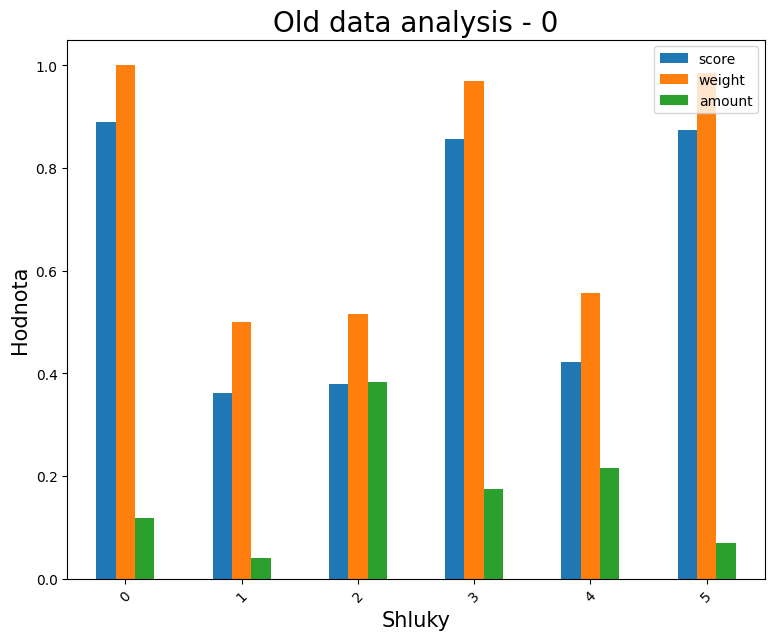

POTENTIAL AMOUNT 277
REDUCED AMOUNT 153
Extracted data 0  -  152
(214, 8)
(214, 6)


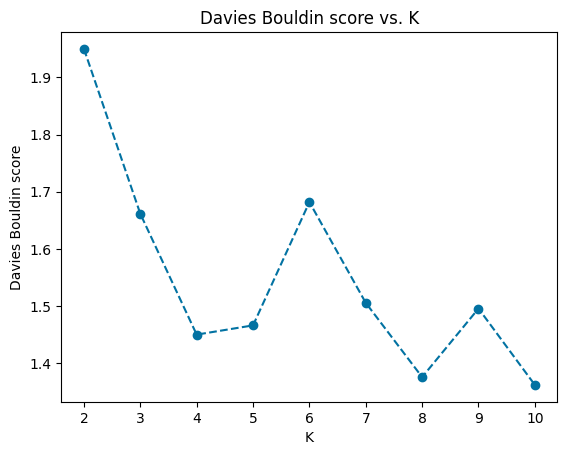

Final K parameter: 10
TOTAL ACC 0.4672897196261682


/home/netmon/.local/lib/python3.10/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


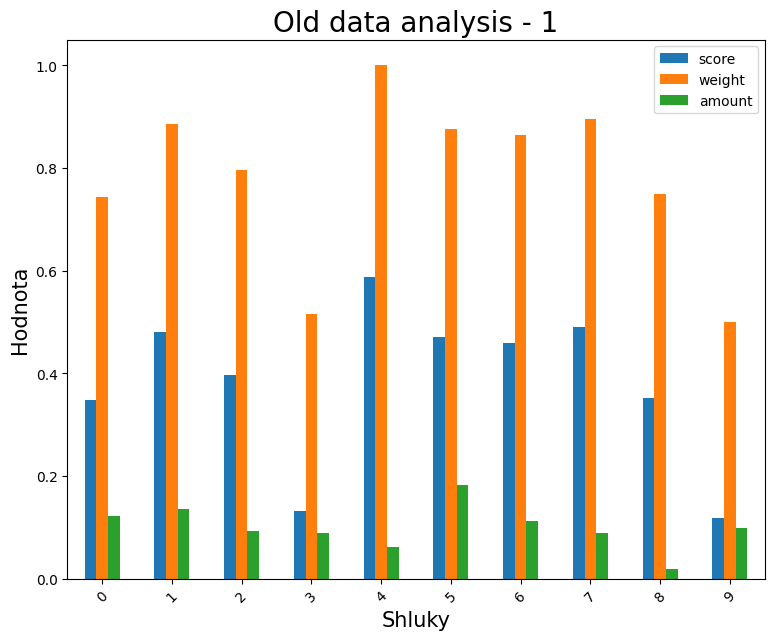

POTENTIAL AMOUNT 169
REDUCED AMOUNT 153
Extracted data 1  -  154
CPU times: user 17.6 s, sys: 985 ms, total: 18.6 s
Wall time: 3.63 s
Old data analysis - 0 To be extracted -  122
Old data analysis - 1 To be extracted -  122
(400, 8)
(400, 6)


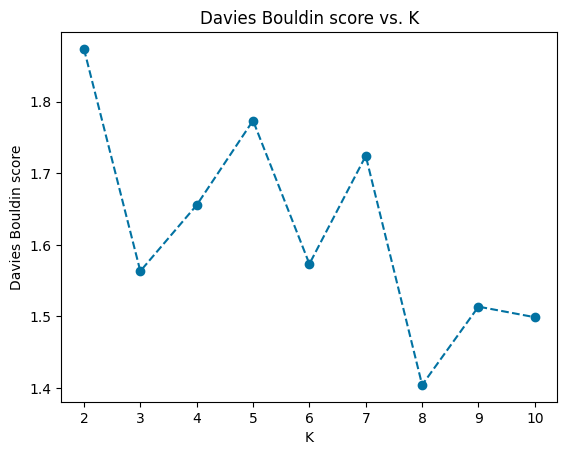

Final K parameter: 8
TOTAL ACC 0.85


/home/netmon/.local/lib/python3.10/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


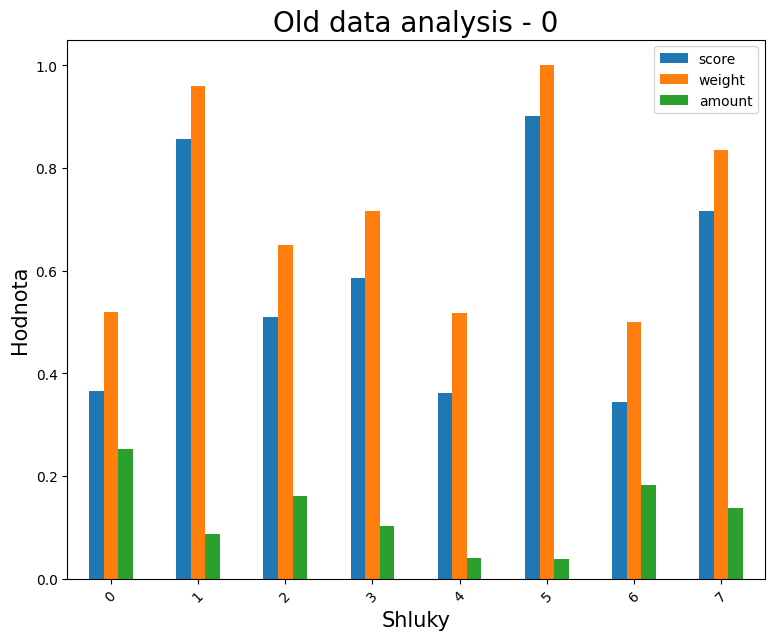

POTENTIAL AMOUNT 262
REDUCED AMOUNT 122
Extracted data 0  -  122
(214, 8)
(214, 6)


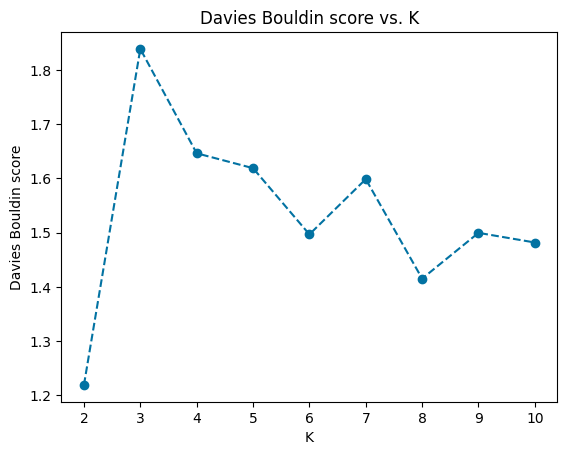

Final K parameter: 8
TOTAL ACC 0.4672897196261682


/home/netmon/.local/lib/python3.10/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


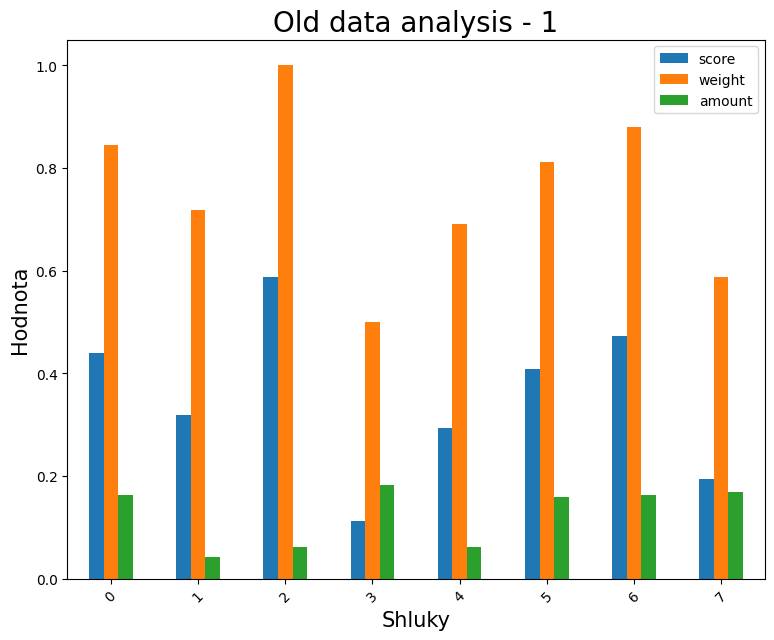

POTENTIAL AMOUNT 157
REDUCED AMOUNT 122
Extracted data 1  -  121
CPU times: user 18 s, sys: 1.03 s, total: 19 s
Wall time: 3.62 s
Old data analysis - 0 To be extracted -  92
Old data analysis - 1 To be extracted -  92
(400, 8)
(400, 6)


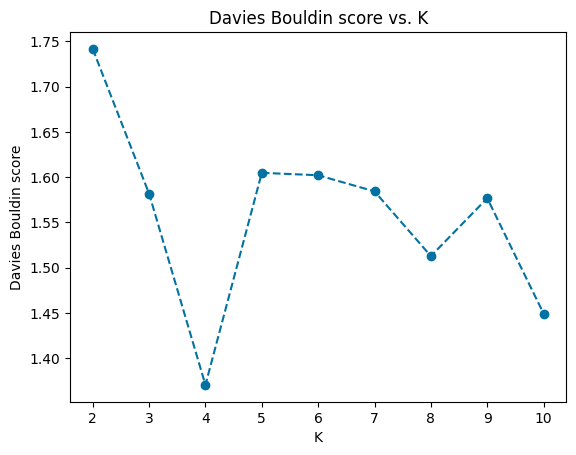

Final K parameter: 4
TOTAL ACC 0.85


/home/netmon/.local/lib/python3.10/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


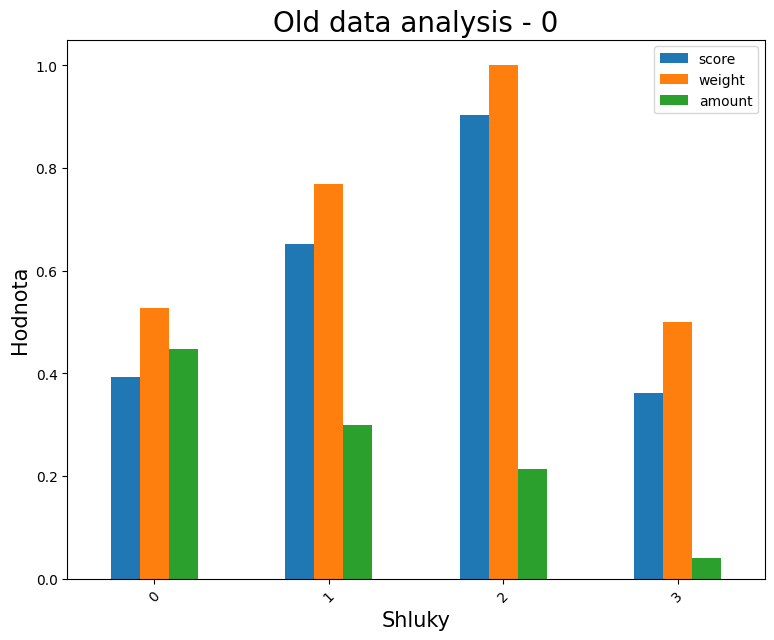

POTENTIAL AMOUNT 279
REDUCED AMOUNT 92
Extracted data 0  -  92
(214, 8)
(214, 6)


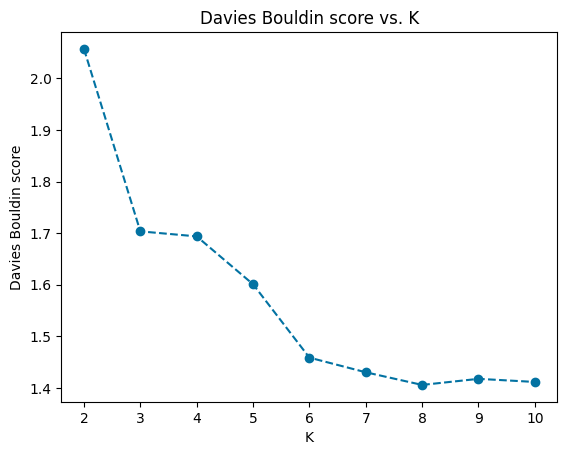

Final K parameter: 8
TOTAL ACC 0.4672897196261682


/home/netmon/.local/lib/python3.10/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


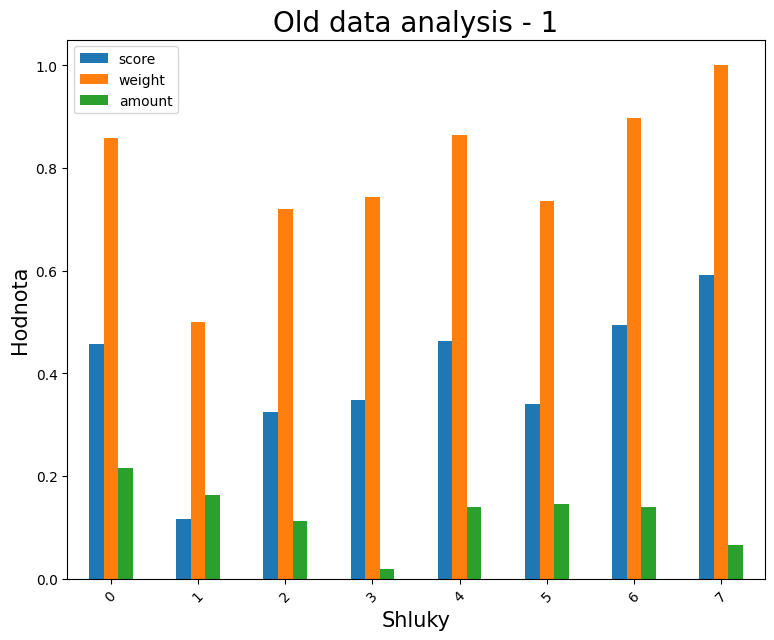

POTENTIAL AMOUNT 166
REDUCED AMOUNT 92
Extracted data 1  -  94
CPU times: user 16.4 s, sys: 946 ms, total: 17.4 s
Wall time: 3.32 s
Old data analysis - 0 To be extracted -  61
Old data analysis - 1 To be extracted -  61
(400, 8)
(400, 6)


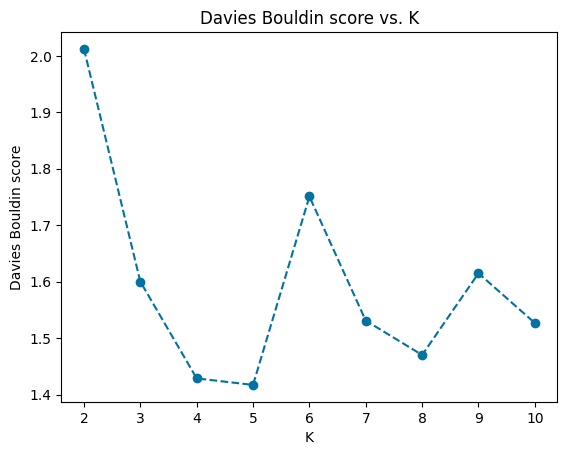

Final K parameter: 5
TOTAL ACC 0.85


/home/netmon/.local/lib/python3.10/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


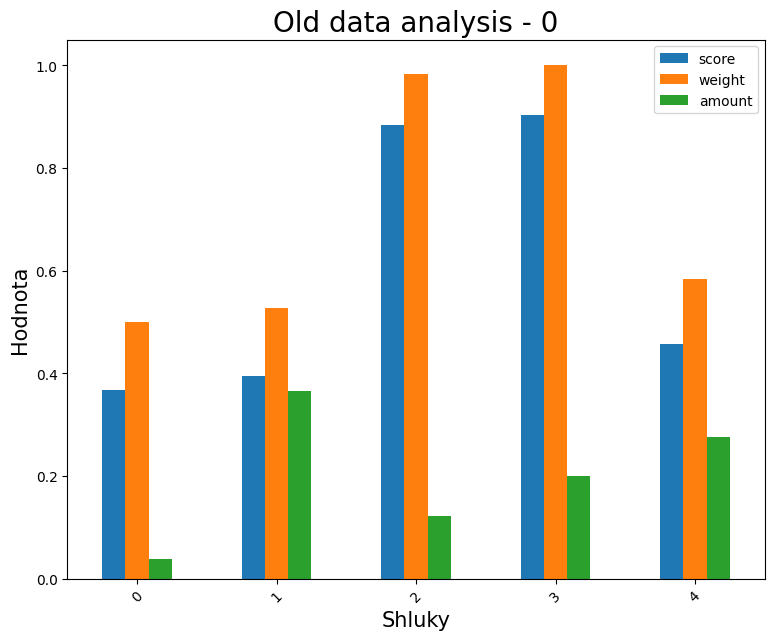

POTENTIAL AMOUNT 276
REDUCED AMOUNT 61
Extracted data 0  -  62
(214, 8)
(214, 6)


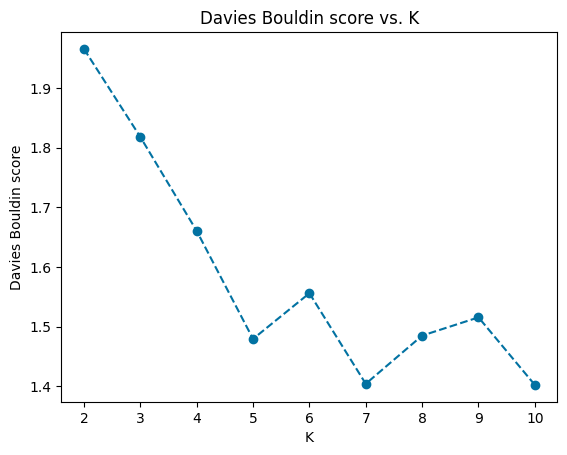

Final K parameter: 10
TOTAL ACC 0.4672897196261682


/home/netmon/.local/lib/python3.10/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


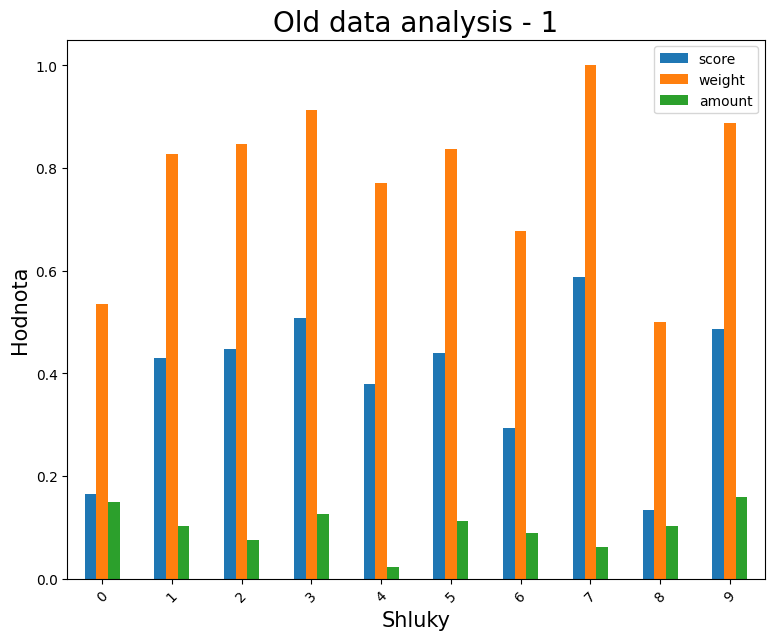

POTENTIAL AMOUNT 164
REDUCED AMOUNT 61
Extracted data 1  -  60
CPU times: user 16 s, sys: 920 ms, total: 16.9 s
Wall time: 3.41 s
Old data analysis - 0 To be extracted -  30
Old data analysis - 1 To be extracted -  30
(400, 8)
(400, 6)


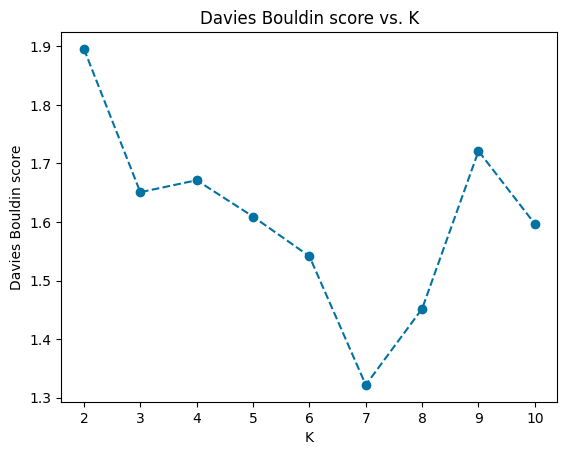

Final K parameter: 7
TOTAL ACC 0.85


/home/netmon/.local/lib/python3.10/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


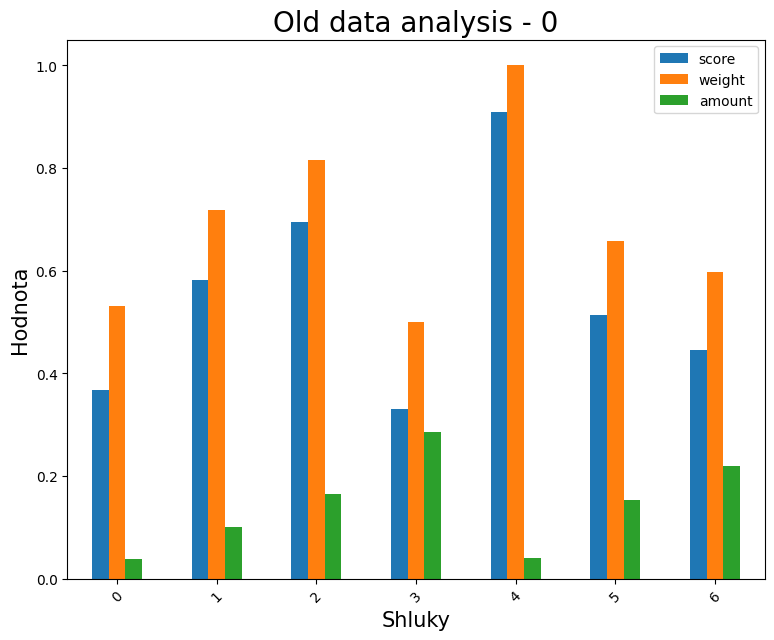

POTENTIAL AMOUNT 256
REDUCED AMOUNT 30
Extracted data 0  -  30
(214, 8)
(214, 6)


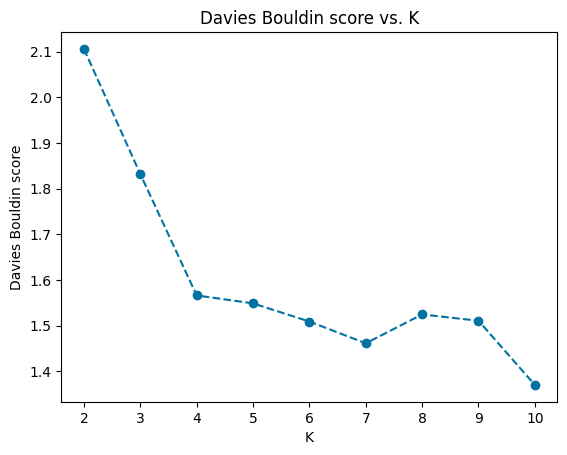

Final K parameter: 10
TOTAL ACC 0.4672897196261682


/home/netmon/.local/lib/python3.10/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


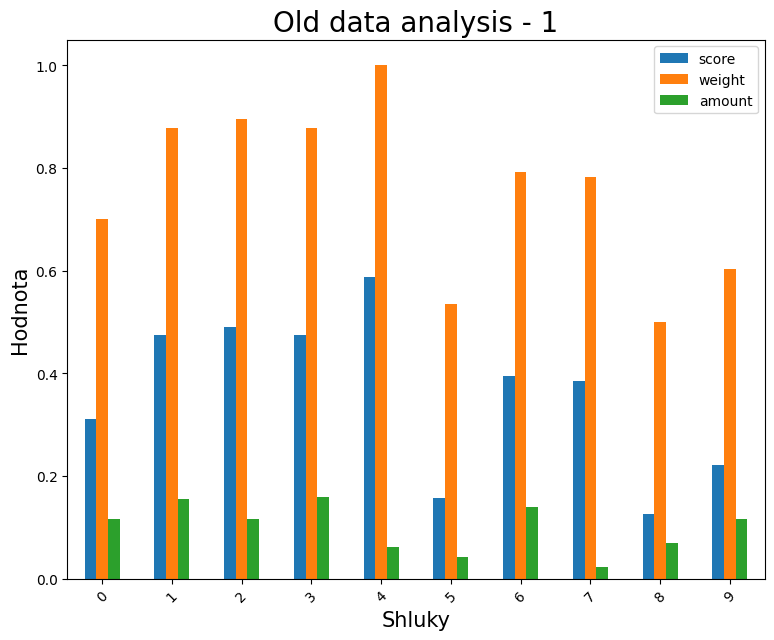

POTENTIAL AMOUNT 166
REDUCED AMOUNT 30
Extracted data 1  -  29
CPU times: user 18.3 s, sys: 1.07 s, total: 19.3 s
Wall time: 3.75 s
Old data analysis - 0 To be extracted -  15
Old data analysis - 1 To be extracted -  15
(400, 8)
(400, 6)


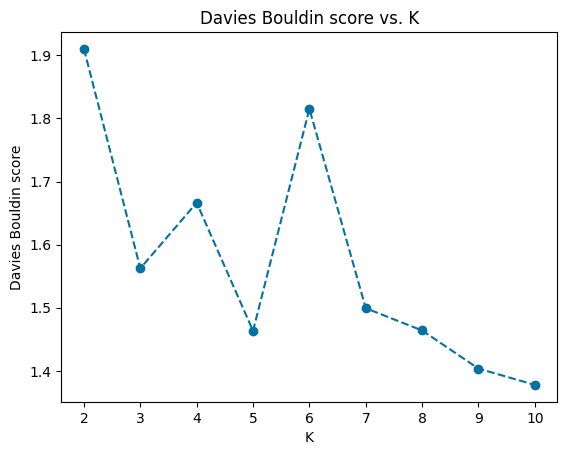

Final K parameter: 10


/home/netmon/.local/lib/python3.10/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


TOTAL ACC 0.85


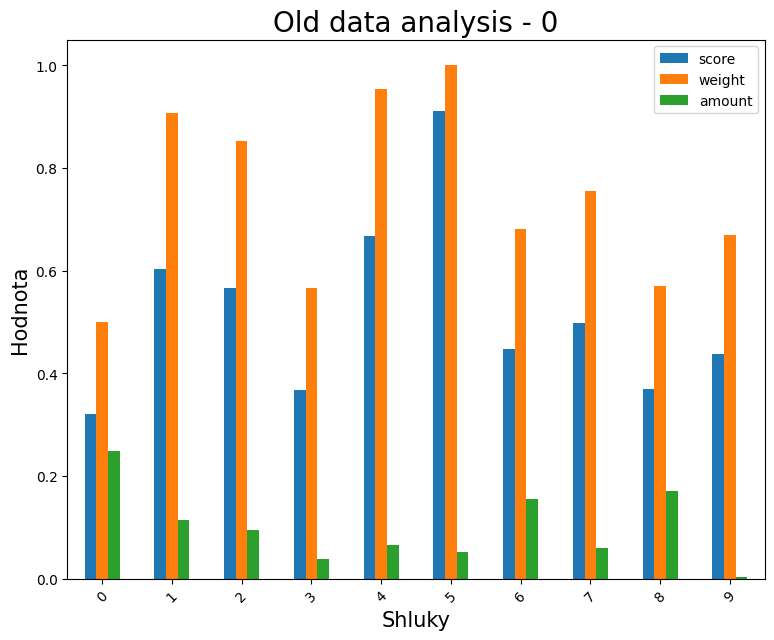

POTENTIAL AMOUNT 277
REDUCED AMOUNT 15
Extracted data 0  -  14
(214, 8)
(214, 6)


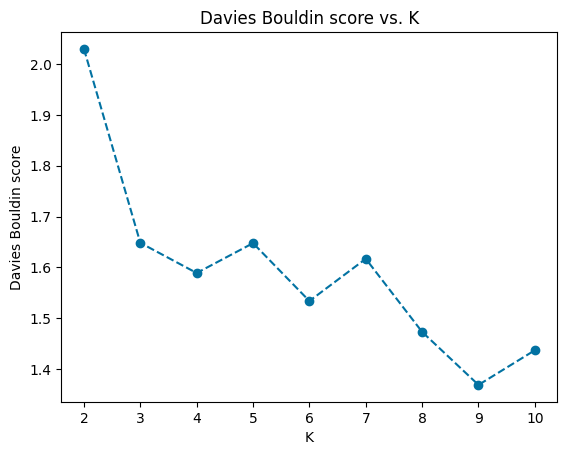

Final K parameter: 9
TOTAL ACC 0.4672897196261682


/home/netmon/.local/lib/python3.10/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


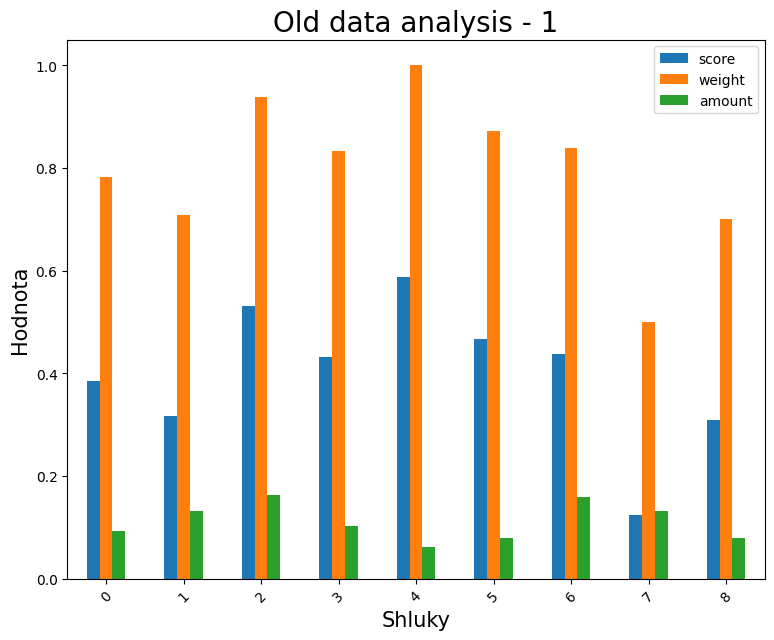

POTENTIAL AMOUNT 168
REDUCED AMOUNT 15
Extracted data 1  -  15
CPU times: user 19.4 s, sys: 1.13 s, total: 20.6 s
Wall time: 4.19 s
{0: 3664, 1: 3736, 'all': 7400}
old               precision    recall  f1-score   support

           0     1.0000    0.4278    0.5992       706
           1     0.6570    1.0000    0.7930       774

    accuracy                         0.7270      1480
   macro avg     0.8285    0.7139    0.6961      1480
weighted avg     0.8206    0.7270    0.7006      1480

dumb               precision    recall  f1-score   support

           0     1.0000    0.3045    0.4669       706
           1     0.6119    1.0000    0.7592       774

    accuracy                         0.6682      1480
   macro avg     0.8059    0.6523    0.6130      1480
weighted avg     0.7970    0.6682    0.6198      1480

Old data analysis - 0 To be extracted -  1480
Old data analysis - 1 To be extracted -  1480
{0: 1480, 1: 1480}
nearmiss1
CPU times: user 396 ms, sys: 21.3 ms, total: 417 ms


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


CPU times: user 2min 20s, sys: 2min 3s, total: 4min 24s
Wall time: 22.3 s
Old data analysis - 0 To be extracted -  1184
Old data analysis - 1 To be extracted -  1184
{0: 1184, 1: 1184}
nearmiss1
CPU times: user 415 ms, sys: 10.9 ms, total: 426 ms
Wall time: 59.5 ms
nearmiss2
CPU times: user 5.89 s, sys: 207 ms, total: 6.1 s
Wall time: 661 ms
nearmiss3
CPU times: user 574 ms, sys: 22.2 ms, total: 597 ms
Wall time: 66.3 ms
randomsampler
CPU times: user 12.2 ms, sys: 0 ns, total: 12.2 ms
Wall time: 12.3 ms
clustercentroids


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


CPU times: user 1min 52s, sys: 1min 35s, total: 3min 28s
Wall time: 17.5 s
Old data analysis - 0 To be extracted -  888
Old data analysis - 1 To be extracted -  888
{0: 888, 1: 888}
nearmiss1
CPU times: user 970 ms, sys: 4.63 ms, total: 974 ms
Wall time: 105 ms
nearmiss2
CPU times: user 5.82 s, sys: 172 ms, total: 5.99 s
Wall time: 680 ms
nearmiss3
CPU times: user 724 ms, sys: 29 ms, total: 753 ms
Wall time: 78.6 ms
randomsampler
CPU times: user 11.9 ms, sys: 0 ns, total: 11.9 ms
Wall time: 12.1 ms
clustercentroids


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


CPU times: user 1min 32s, sys: 1min 17s, total: 2min 50s
Wall time: 14.5 s
Old data analysis - 0 To be extracted -  592
Old data analysis - 1 To be extracted -  592
{0: 592, 1: 592}
nearmiss1
CPU times: user 467 ms, sys: 24.4 ms, total: 491 ms
Wall time: 60.9 ms
nearmiss2
CPU times: user 5.75 s, sys: 192 ms, total: 5.94 s
Wall time: 629 ms
nearmiss3
CPU times: user 588 ms, sys: 11 ms, total: 599 ms
Wall time: 66.3 ms
randomsampler
CPU times: user 11.7 ms, sys: 0 ns, total: 11.7 ms
Wall time: 11.9 ms
clustercentroids


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


CPU times: user 1min 10s, sys: 56.5 s, total: 2min 6s
Wall time: 10.9 s
Old data analysis - 0 To be extracted -  296
Old data analysis - 1 To be extracted -  296
{0: 296, 1: 296}
nearmiss1
CPU times: user 410 ms, sys: 5.26 ms, total: 415 ms
Wall time: 51.8 ms
nearmiss2
CPU times: user 5.92 s, sys: 205 ms, total: 6.12 s
Wall time: 660 ms
nearmiss3
CPU times: user 591 ms, sys: 2.71 ms, total: 594 ms
Wall time: 65.5 ms
randomsampler
CPU times: user 11.3 ms, sys: 28 µs, total: 11.4 ms
Wall time: 11.5 ms
clustercentroids


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


CPU times: user 46.6 s, sys: 30.6 s, total: 1min 17s
Wall time: 6.63 s
Old data analysis - 0 To be extracted -  148
Old data analysis - 1 To be extracted -  148
{0: 148, 1: 148}
nearmiss1
CPU times: user 415 ms, sys: 4.27 ms, total: 419 ms
Wall time: 52.9 ms
nearmiss2
CPU times: user 5.95 s, sys: 234 ms, total: 6.19 s
Wall time: 664 ms
nearmiss3
CPU times: user 600 ms, sys: 6.65 ms, total: 607 ms
Wall time: 66.4 ms
randomsampler
CPU times: user 11.1 ms, sys: 0 ns, total: 11.1 ms
Wall time: 11.2 ms
clustercentroids


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


CPU times: user 35.2 s, sys: 21.2 s, total: 56.4 s
Wall time: 4.9 s
kmeans
bouldin
Old data analysis - 0 To be extracted -  1480
Old data analysis - 1 To be extracted -  1480
(2958, 20)
(2958, 1)


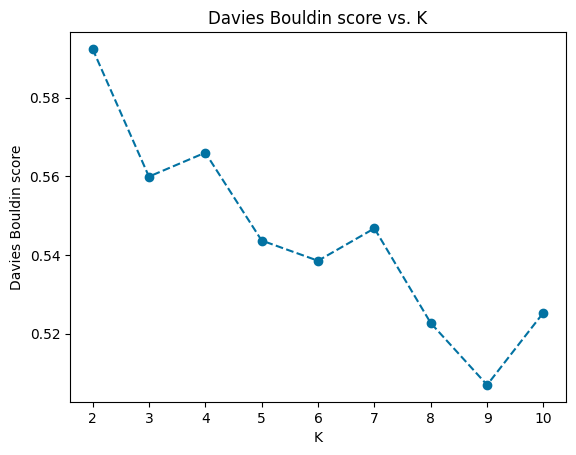

Final K parameter: 9


/home/netmon/.local/lib/python3.10/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


TOTAL ACC 0.33603786342123054


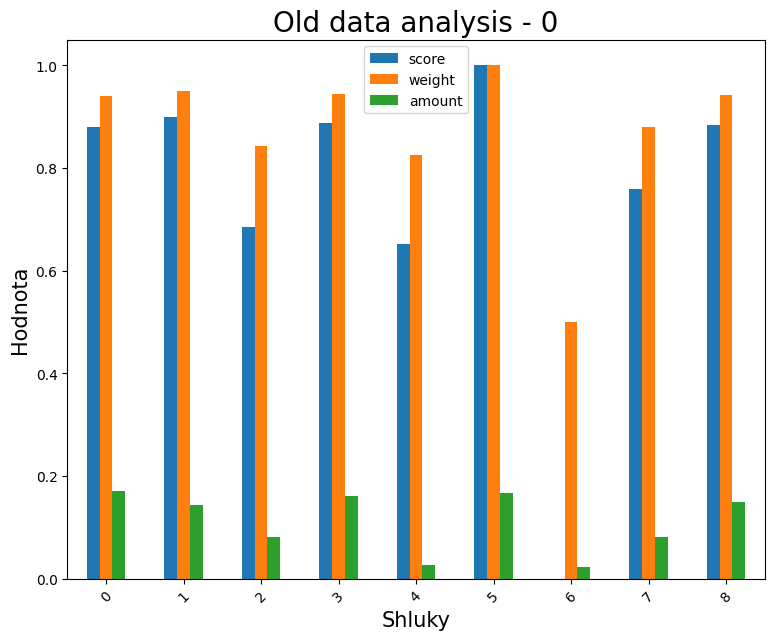

POTENTIAL AMOUNT 2742
REDUCED AMOUNT 1480
Extracted data 0  -  1480
(2962, 20)
(2962, 1)


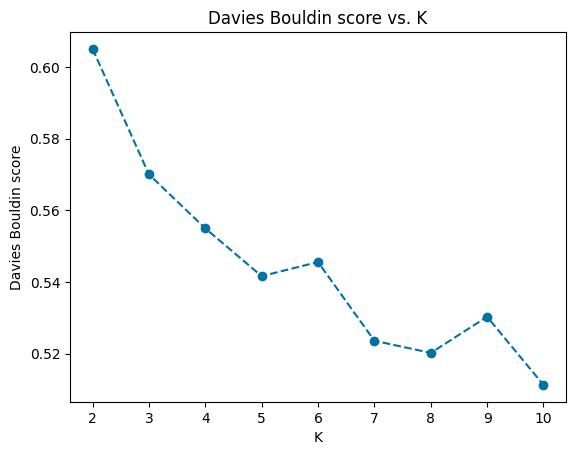

Final K parameter: 10


/tmp/ipykernel_10199/2689605898.py:134: RuntimeWarning: invalid value encountered in double_scalars
  self.acc_ratio=(relative_deviation_acc-min_acc)/(max_acc-min_acc)#no%*100


TOTAL ACC 1.0


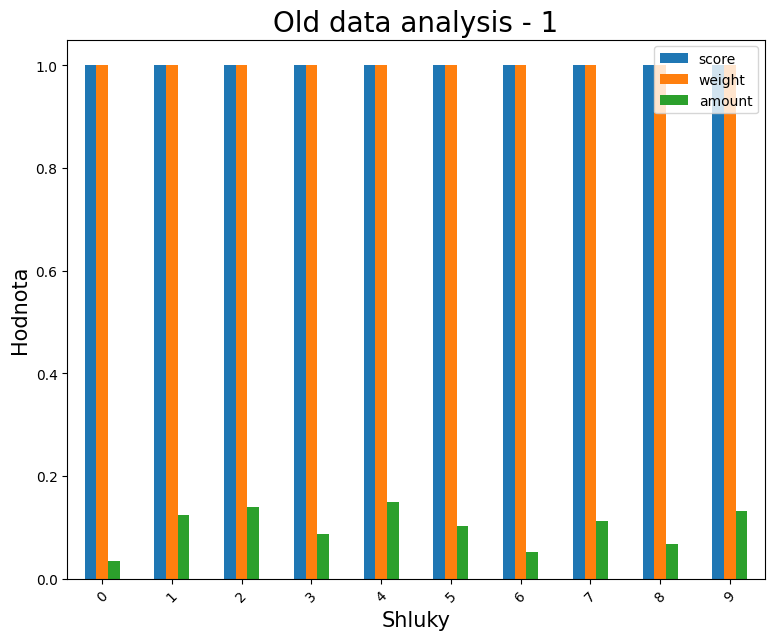

POTENTIAL AMOUNT 2962
REDUCED AMOUNT 1480
Extracted data 1  -  1479
CPU times: user 32.1 s, sys: 2.5 s, total: 34.6 s
Wall time: 5.83 s
Old data analysis - 0 To be extracted -  1184
Old data analysis - 1 To be extracted -  1184
(2958, 20)
(2958, 1)


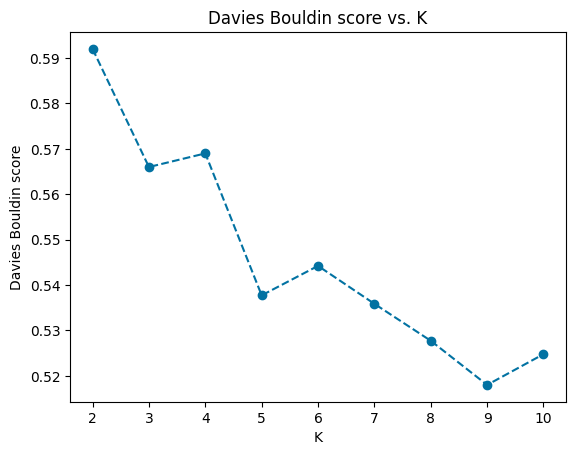

Final K parameter: 9


/home/netmon/.local/lib/python3.10/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


TOTAL ACC 0.33603786342123054


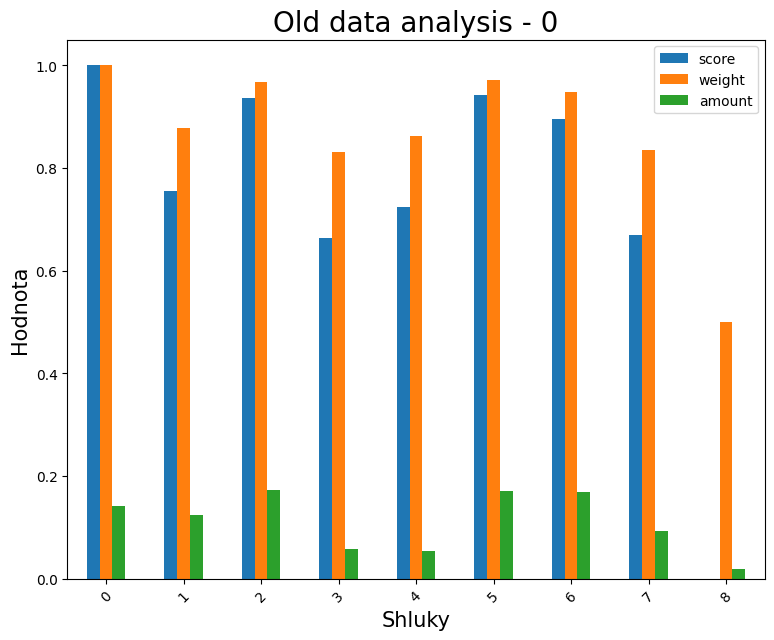

POTENTIAL AMOUNT 2732
REDUCED AMOUNT 1184
Extracted data 0  -  1183
(2962, 20)
(2962, 1)


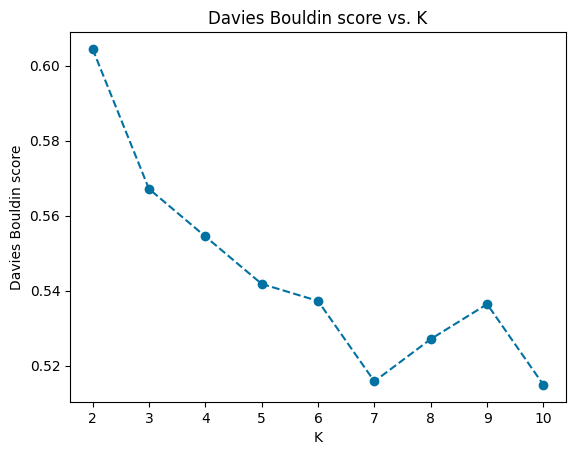

Final K parameter: 10


/tmp/ipykernel_10199/2689605898.py:134: RuntimeWarning: invalid value encountered in double_scalars
  self.acc_ratio=(relative_deviation_acc-min_acc)/(max_acc-min_acc)#no%*100


TOTAL ACC 1.0


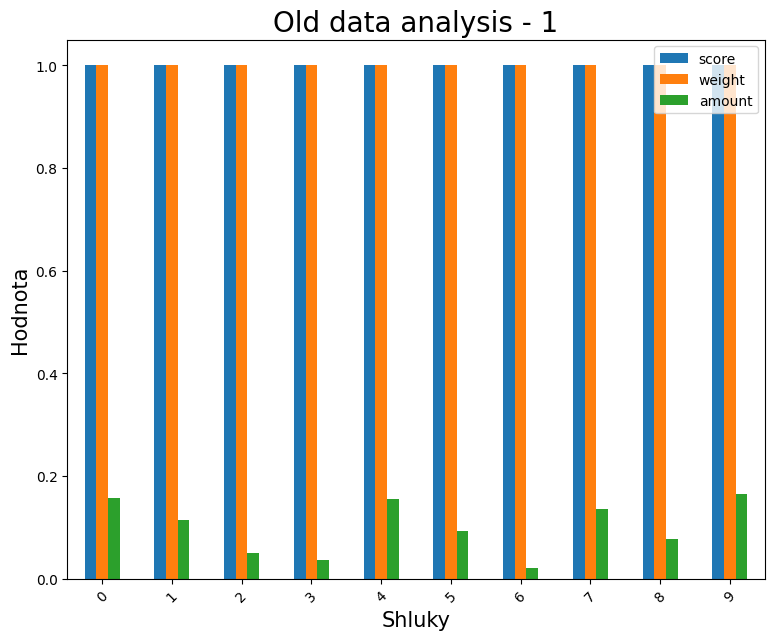

POTENTIAL AMOUNT 2962
REDUCED AMOUNT 1184
Extracted data 1  -  1184
CPU times: user 29.6 s, sys: 2.39 s, total: 32 s
Wall time: 5.63 s
Old data analysis - 0 To be extracted -  888
Old data analysis - 1 To be extracted -  888
(2958, 20)
(2958, 1)


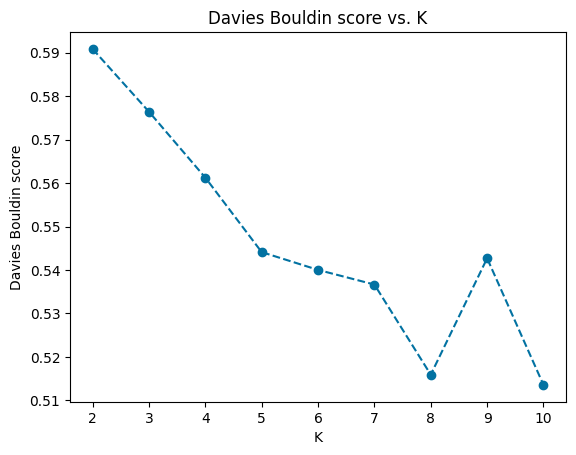

Final K parameter: 10


/home/netmon/.local/lib/python3.10/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


TOTAL ACC 0.33603786342123054


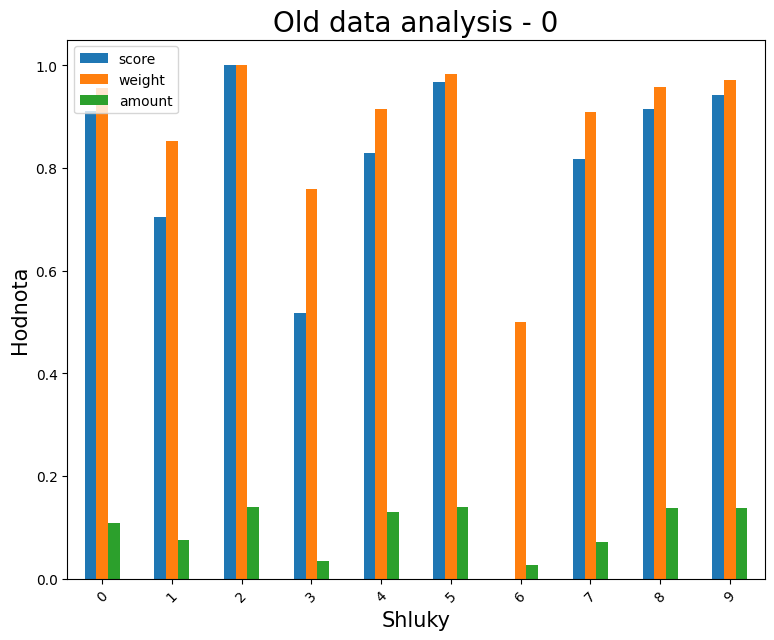

POTENTIAL AMOUNT 2758
REDUCED AMOUNT 888
Extracted data 0  -  887
(2962, 20)
(2962, 1)


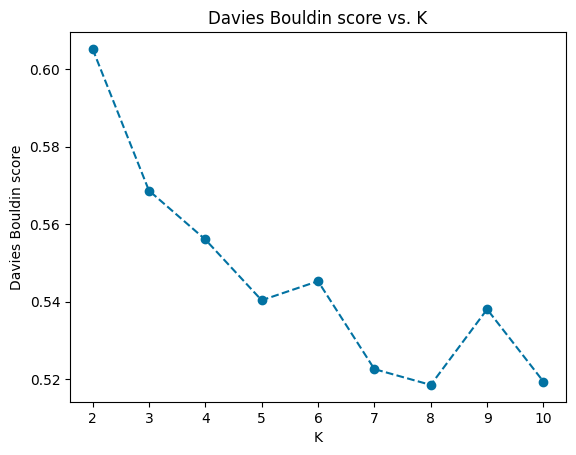

Final K parameter: 8


/tmp/ipykernel_10199/2689605898.py:134: RuntimeWarning: invalid value encountered in double_scalars
  self.acc_ratio=(relative_deviation_acc-min_acc)/(max_acc-min_acc)#no%*100


TOTAL ACC 1.0


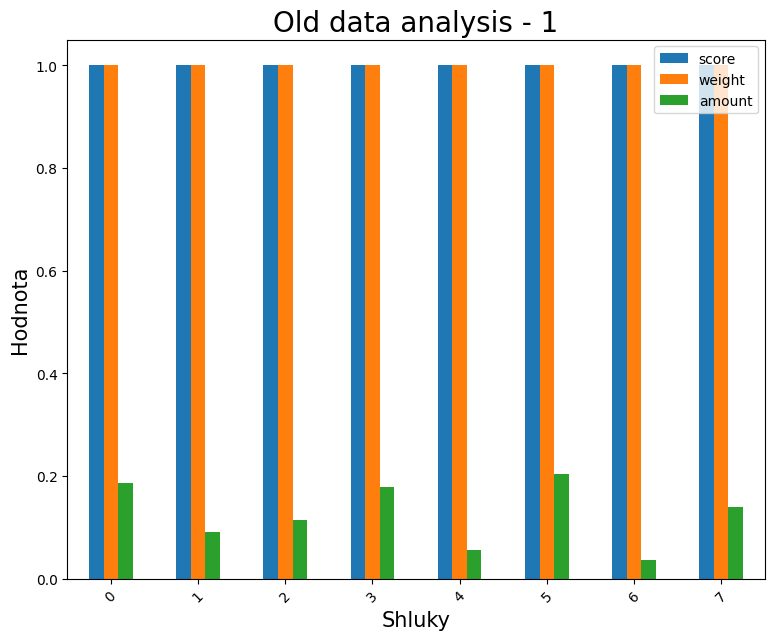

POTENTIAL AMOUNT 2962
REDUCED AMOUNT 888
Extracted data 1  -  888
CPU times: user 27.7 s, sys: 2.31 s, total: 30 s
Wall time: 5.39 s
Old data analysis - 0 To be extracted -  592
Old data analysis - 1 To be extracted -  592
(2958, 20)
(2958, 1)


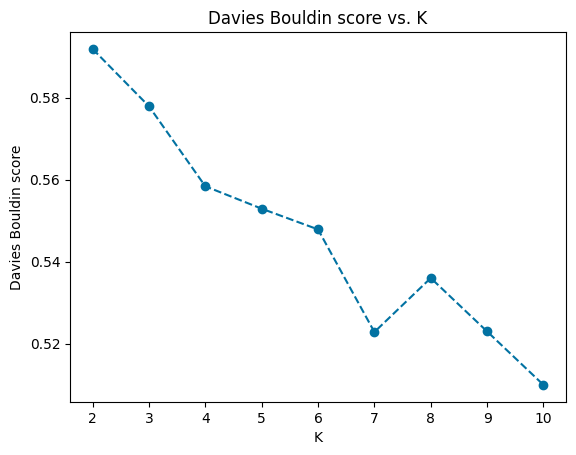

Final K parameter: 10


/home/netmon/.local/lib/python3.10/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


TOTAL ACC 0.33603786342123054


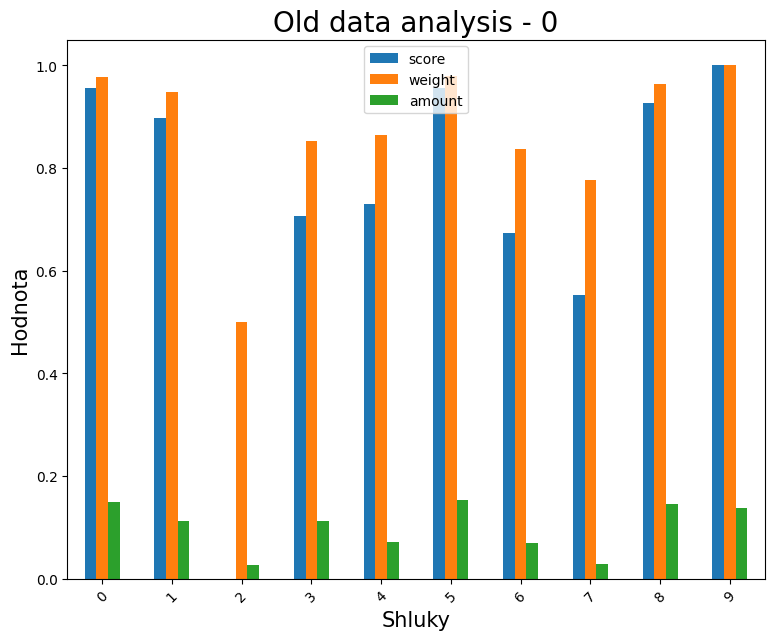

POTENTIAL AMOUNT 2739
REDUCED AMOUNT 592
Extracted data 0  -  592
(2962, 20)
(2962, 1)


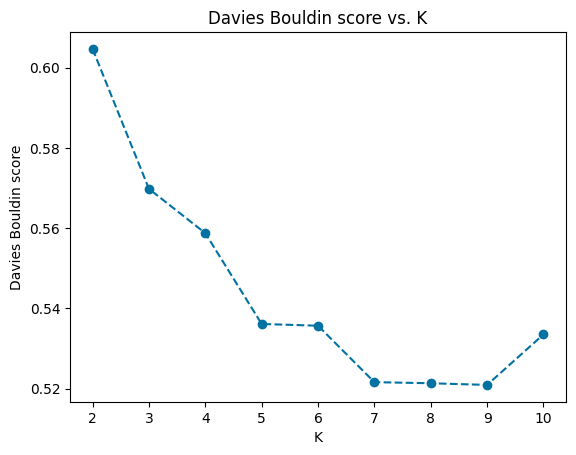

Final K parameter: 9


/tmp/ipykernel_10199/2689605898.py:134: RuntimeWarning: invalid value encountered in double_scalars
  self.acc_ratio=(relative_deviation_acc-min_acc)/(max_acc-min_acc)#no%*100


TOTAL ACC 1.0


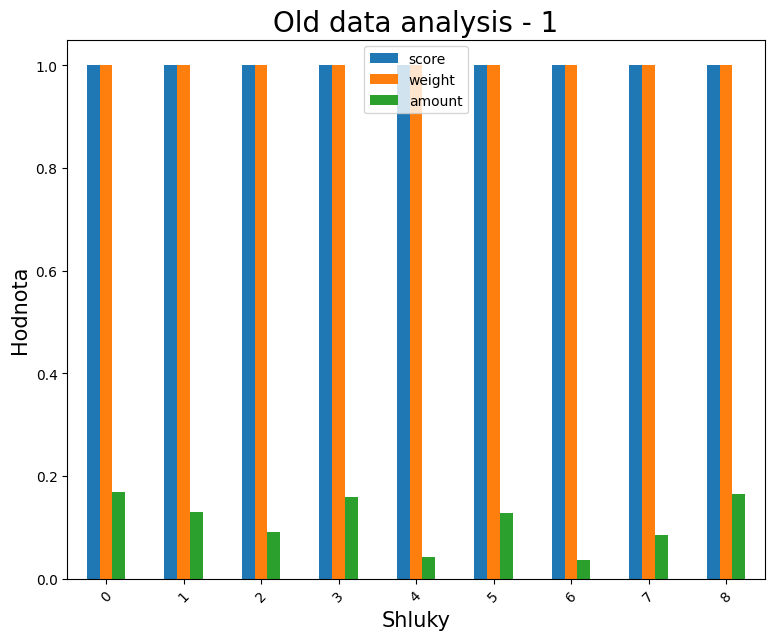

POTENTIAL AMOUNT 2962
REDUCED AMOUNT 592
Extracted data 1  -  593
CPU times: user 31.3 s, sys: 2.53 s, total: 33.9 s
Wall time: 5.8 s
Old data analysis - 0 To be extracted -  296
Old data analysis - 1 To be extracted -  296
(2958, 20)
(2958, 1)


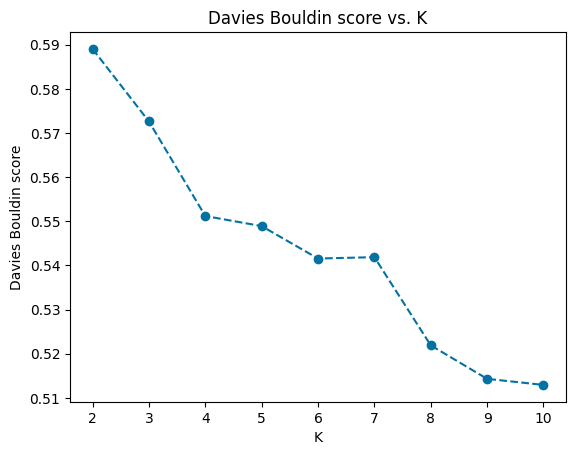

Final K parameter: 10


/home/netmon/.local/lib/python3.10/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


TOTAL ACC 0.33603786342123054


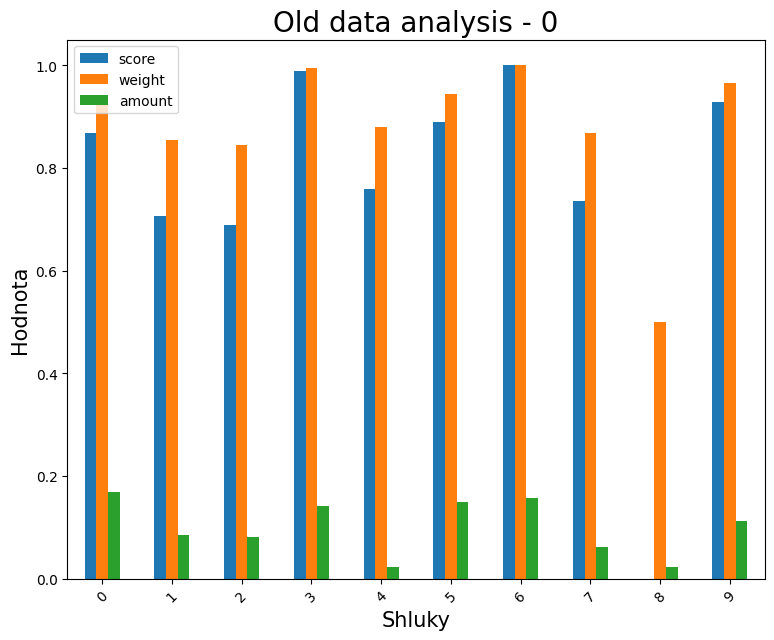

POTENTIAL AMOUNT 2748
REDUCED AMOUNT 296
Extracted data 0  -  297
(2962, 20)
(2962, 1)


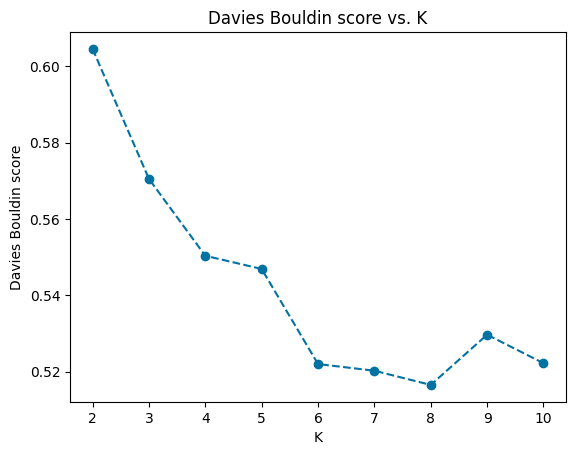

Final K parameter: 8


/tmp/ipykernel_10199/2689605898.py:134: RuntimeWarning: invalid value encountered in double_scalars
  self.acc_ratio=(relative_deviation_acc-min_acc)/(max_acc-min_acc)#no%*100


TOTAL ACC 1.0


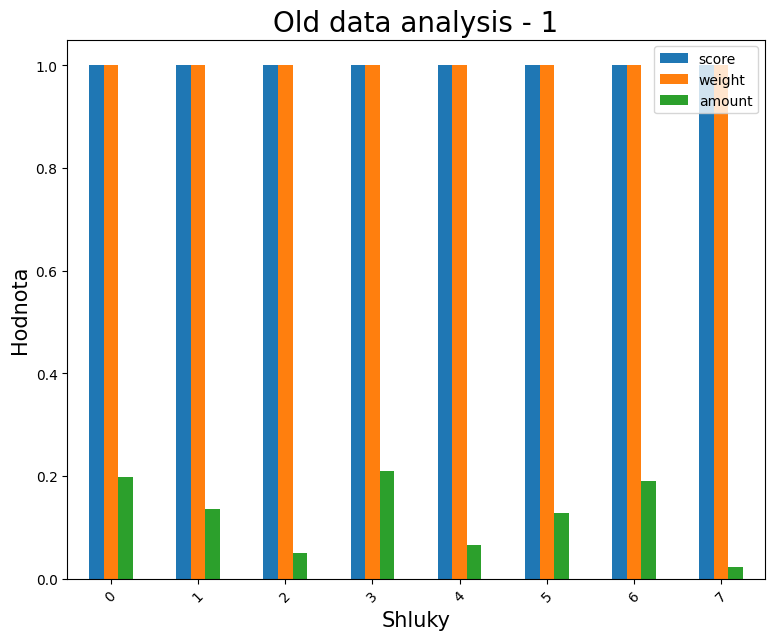

POTENTIAL AMOUNT 2962
REDUCED AMOUNT 296
Extracted data 1  -  296
CPU times: user 26.6 s, sys: 2.56 s, total: 29.1 s
Wall time: 5.77 s
Old data analysis - 0 To be extracted -  148
Old data analysis - 1 To be extracted -  148
(2958, 20)
(2958, 1)


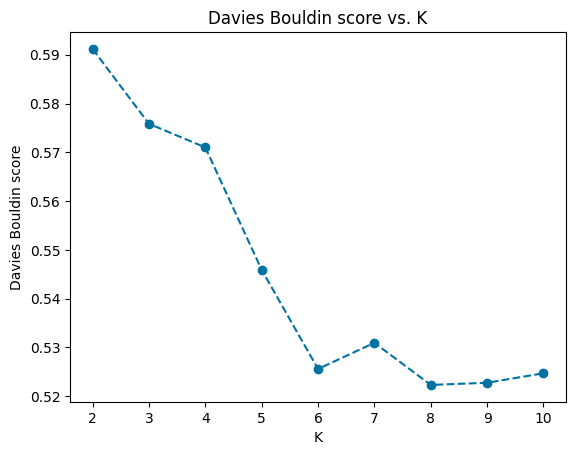

Final K parameter: 8


/home/netmon/.local/lib/python3.10/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


TOTAL ACC 0.33603786342123054


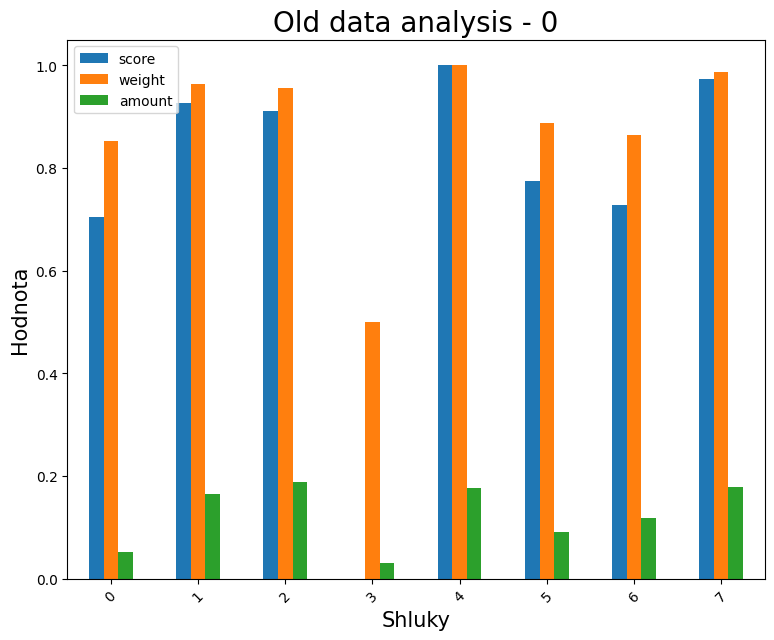

POTENTIAL AMOUNT 2763
REDUCED AMOUNT 148
Extracted data 0  -  148
(2962, 20)
(2962, 1)


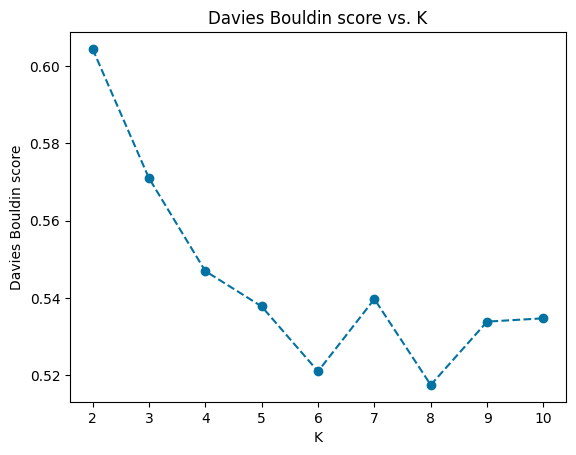

Final K parameter: 8


/tmp/ipykernel_10199/2689605898.py:134: RuntimeWarning: invalid value encountered in double_scalars
  self.acc_ratio=(relative_deviation_acc-min_acc)/(max_acc-min_acc)#no%*100


TOTAL ACC 1.0


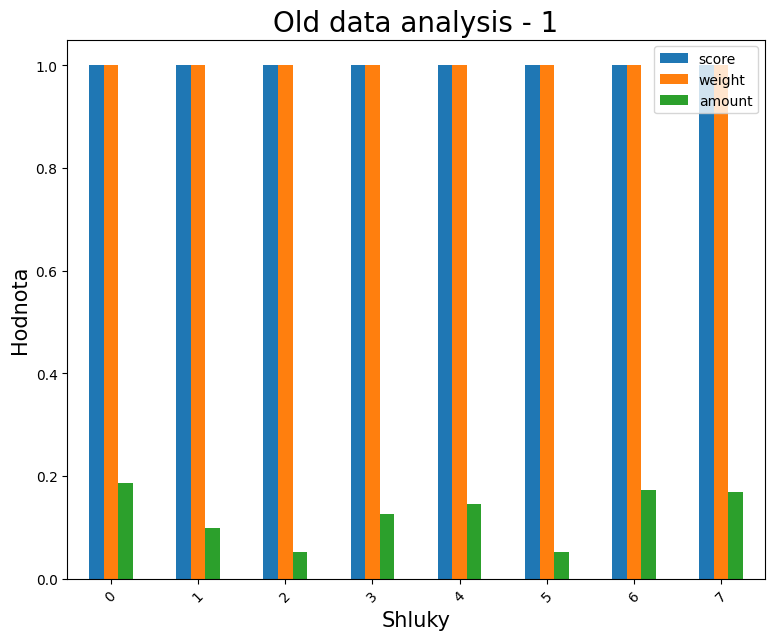

POTENTIAL AMOUNT 2962
REDUCED AMOUNT 148
Extracted data 1  -  149
CPU times: user 27.9 s, sys: 2.4 s, total: 30.3 s
Wall time: 5.32 s
{0: 3703, 1: 3697, 'all': 7400}
old               precision    recall  f1-score   support

           0     0.9766    0.9569    0.9666       742
           1     0.9575    0.9770    0.9671       738

    accuracy                         0.9669      1480
   macro avg     0.9671    0.9669    0.9669      1480
weighted avg     0.9671    0.9669    0.9669      1480

dumb               precision    recall  f1-score   support

           0     0.9657    0.9474    0.9565       742
           1     0.9481    0.9661    0.9570       738

    accuracy                         0.9568      1480
   macro avg     0.9569    0.9568    0.9568      1480
weighted avg     0.9569    0.9568    0.9568      1480

Old data analysis - 0 To be extracted -  1480
Old data analysis - 1 To be extracted -  1480
{0: 1480, 1: 1480}
nearmiss1
CPU times: user 415 ms, sys: 10.4 ms, total: 425 m

/usr/local/lib/python3.10/dist-packages/imblearn/under_sampling/_prototype_selection/_nearmiss.py:203: UserWarning: The number of the samples to be selected is larger than the number of samples available. The balancing ratio cannot be ensure and all samples will be returned.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


CPU times: user 2min 19s, sys: 2min 2s, total: 4min 21s
Wall time: 22 s
Old data analysis - 0 To be extracted -  1184
Old data analysis - 1 To be extracted -  1184
{0: 1184, 1: 1184}
nearmiss1
CPU times: user 398 ms, sys: 6.26 ms, total: 404 ms
Wall time: 50.5 ms
nearmiss2
CPU times: user 6.04 s, sys: 212 ms, total: 6.25 s
Wall time: 677 ms
nearmiss3
CPU times: user 532 ms, sys: 17.3 ms, total: 549 ms
Wall time: 63.3 ms
randomsampler
CPU times: user 11.1 ms, sys: 933 µs, total: 12.1 ms
Wall time: 12.2 ms
clustercentroids


/usr/local/lib/python3.10/dist-packages/imblearn/under_sampling/_prototype_selection/_nearmiss.py:203: UserWarning: The number of the samples to be selected is larger than the number of samples available. The balancing ratio cannot be ensure and all samples will be returned.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


CPU times: user 1min 57s, sys: 1min 41s, total: 3min 38s
Wall time: 18.5 s
Old data analysis - 0 To be extracted -  888
Old data analysis - 1 To be extracted -  888
{0: 888, 1: 888}
nearmiss1
CPU times: user 411 ms, sys: 8.03 ms, total: 419 ms
Wall time: 52.9 ms
nearmiss2
CPU times: user 6.13 s, sys: 251 ms, total: 6.38 s
Wall time: 701 ms
nearmiss3
CPU times: user 544 ms, sys: 4.75 ms, total: 549 ms
Wall time: 62.9 ms
randomsampler
CPU times: user 11.7 ms, sys: 0 ns, total: 11.7 ms
Wall time: 11.8 ms
clustercentroids


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


CPU times: user 1min 31s, sys: 1min 16s, total: 2min 48s
Wall time: 14.4 s
Old data analysis - 0 To be extracted -  592
Old data analysis - 1 To be extracted -  592
{0: 592, 1: 592}
nearmiss1
CPU times: user 1.03 s, sys: 6.94 ms, total: 1.04 s
Wall time: 116 ms
nearmiss2
CPU times: user 7.87 s, sys: 248 ms, total: 8.12 s
Wall time: 1.08 s
nearmiss3
CPU times: user 3.08 s, sys: 0 ns, total: 3.08 s
Wall time: 305 ms
randomsampler
CPU times: user 12 ms, sys: 0 ns, total: 12 ms
Wall time: 12.1 ms
clustercentroids


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


CPU times: user 1min 11s, sys: 56.6 s, total: 2min 8s
Wall time: 11.1 s
Old data analysis - 0 To be extracted -  296
Old data analysis - 1 To be extracted -  296
{0: 296, 1: 296}
nearmiss1
CPU times: user 407 ms, sys: 13.7 ms, total: 421 ms
Wall time: 51.7 ms
nearmiss2
CPU times: user 6.26 s, sys: 261 ms, total: 6.52 s
Wall time: 731 ms
nearmiss3
CPU times: user 503 ms, sys: 11.2 ms, total: 514 ms
Wall time: 57.7 ms
randomsampler
CPU times: user 11.2 ms, sys: 0 ns, total: 11.2 ms
Wall time: 11.3 ms
clustercentroids


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


CPU times: user 46.9 s, sys: 30.1 s, total: 1min 17s
Wall time: 6.57 s
Old data analysis - 0 To be extracted -  148
Old data analysis - 1 To be extracted -  148
{0: 148, 1: 148}
nearmiss1
CPU times: user 418 ms, sys: 7.96 ms, total: 426 ms
Wall time: 53.7 ms
nearmiss2
CPU times: user 6.01 s, sys: 231 ms, total: 6.24 s
Wall time: 668 ms
nearmiss3
CPU times: user 515 ms, sys: 2.39 ms, total: 517 ms
Wall time: 59 ms
randomsampler
CPU times: user 11.2 ms, sys: 0 ns, total: 11.2 ms
Wall time: 11.4 ms
clustercentroids


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


CPU times: user 33.5 s, sys: 18.6 s, total: 52 s
Wall time: 4.45 s
kmeans
bouldin
Old data analysis - 0 To be extracted -  1480
Old data analysis - 1 To be extracted -  1480
(2961, 20)
(2961, 1)


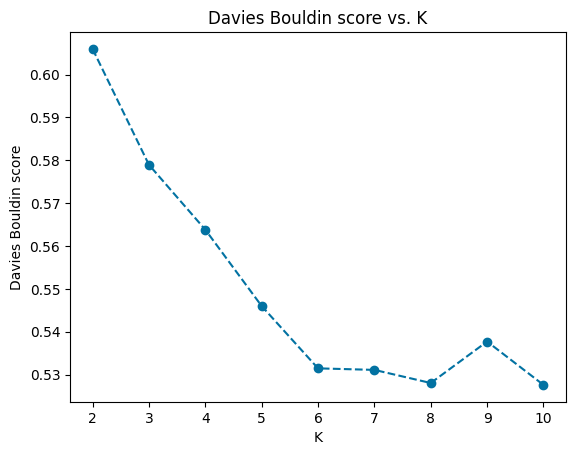

Final K parameter: 10


/home/netmon/.local/lib/python3.10/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


TOTAL ACC 0.961837217156366


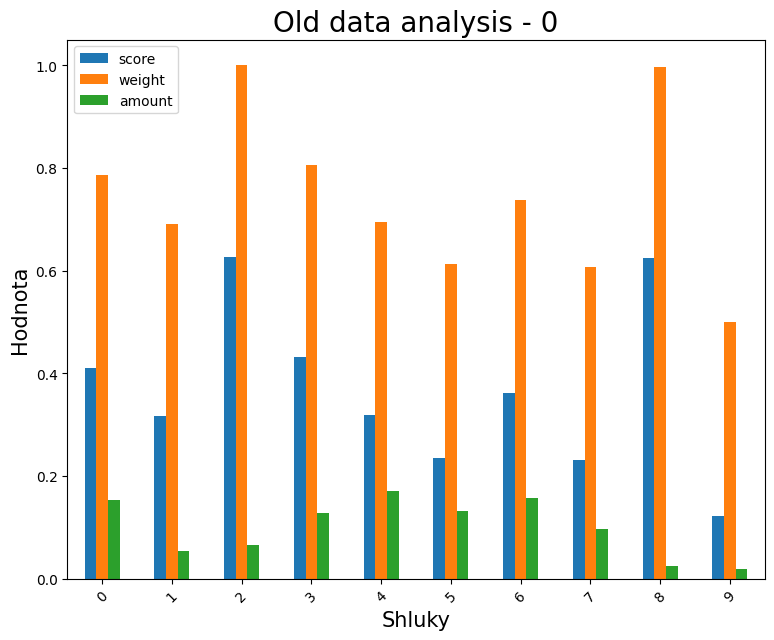

POTENTIAL AMOUNT 2173
REDUCED AMOUNT 1480
Extracted data 0  -  1479
(2959, 20)
(2959, 1)


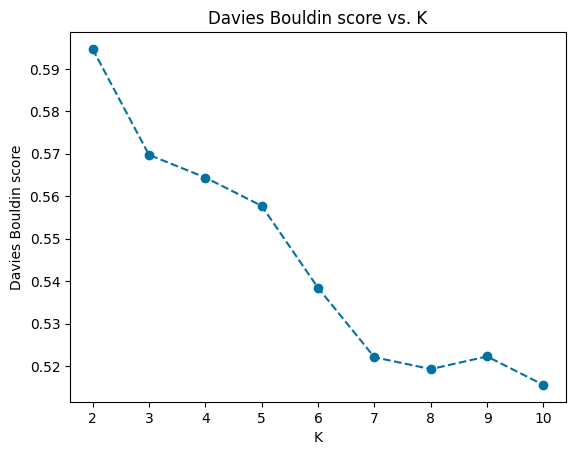

Final K parameter: 10


/home/netmon/.local/lib/python3.10/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


TOTAL ACC 0.9651909428861102


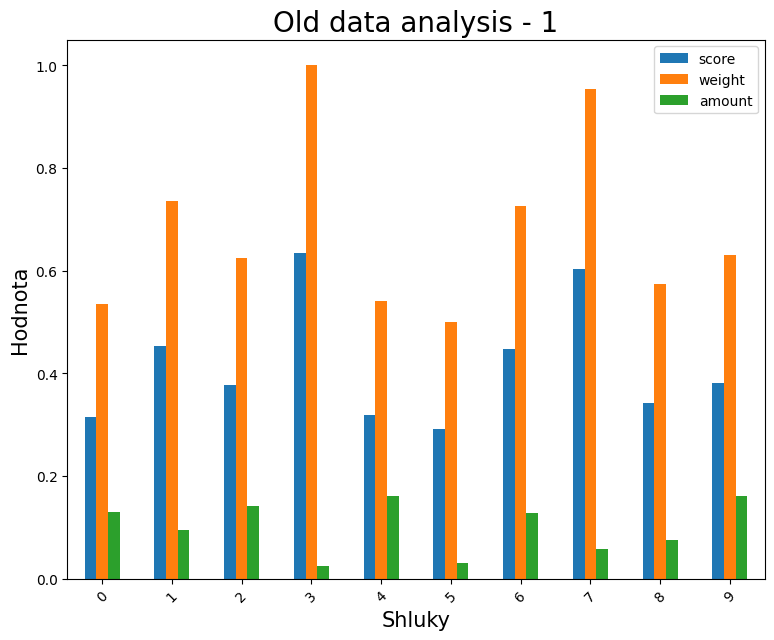

POTENTIAL AMOUNT 1907
REDUCED AMOUNT 1480
Extracted data 1  -  1481
CPU times: user 30.1 s, sys: 2.48 s, total: 32.6 s
Wall time: 5.76 s
Old data analysis - 0 To be extracted -  1184
Old data analysis - 1 To be extracted -  1184
(2961, 20)
(2961, 1)


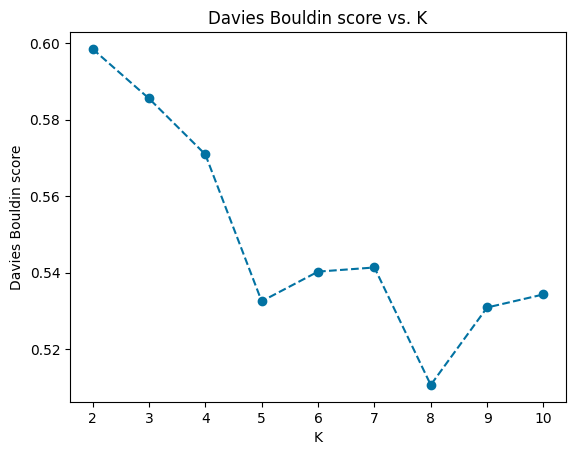

Final K parameter: 8


/home/netmon/.local/lib/python3.10/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


TOTAL ACC 0.961837217156366


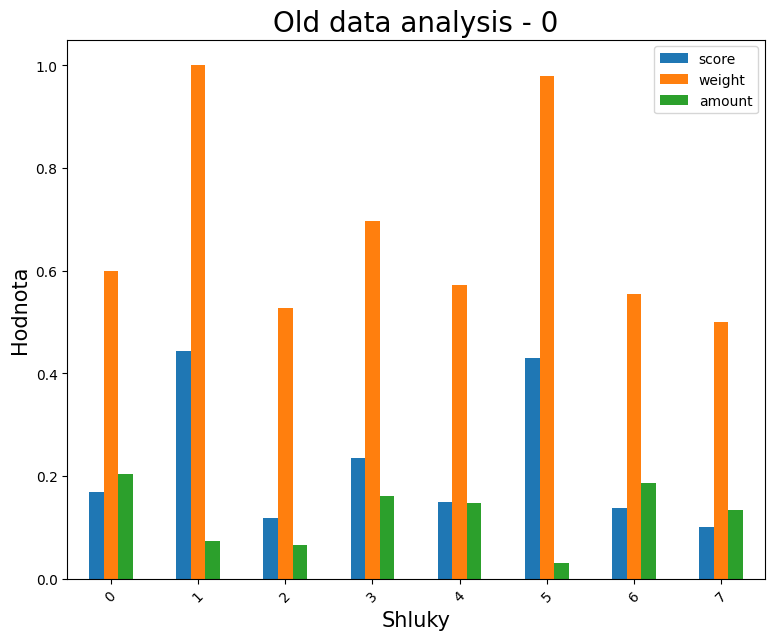

POTENTIAL AMOUNT 1851
REDUCED AMOUNT 1184
Extracted data 0  -  1184
(2959, 20)
(2959, 1)


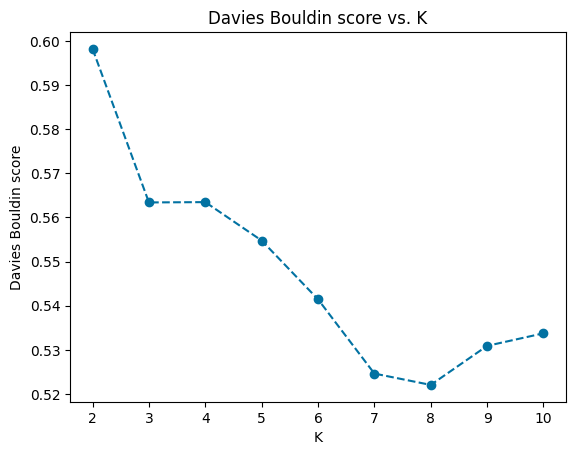

Final K parameter: 8


/home/netmon/.local/lib/python3.10/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


TOTAL ACC 0.9651909428861102


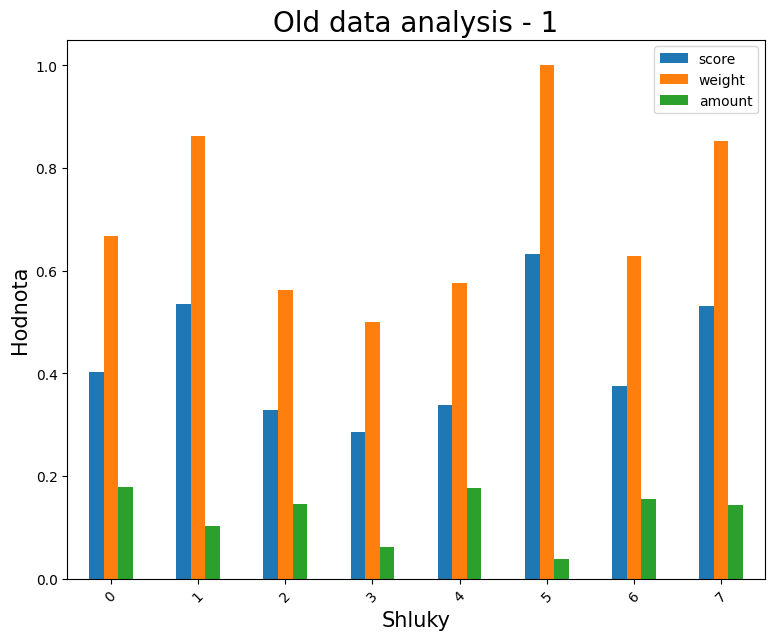

POTENTIAL AMOUNT 2008
REDUCED AMOUNT 1184
Extracted data 1  -  1184
CPU times: user 29.8 s, sys: 2.36 s, total: 32.1 s
Wall time: 5.47 s
Old data analysis - 0 To be extracted -  888
Old data analysis - 1 To be extracted -  888
(2961, 20)
(2961, 1)


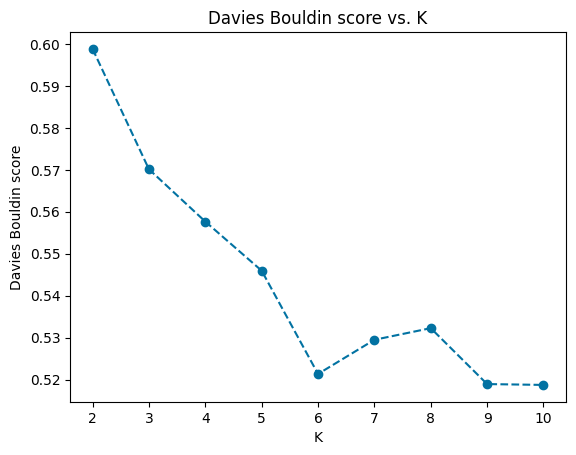

Final K parameter: 10


/home/netmon/.local/lib/python3.10/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


TOTAL ACC 0.961837217156366


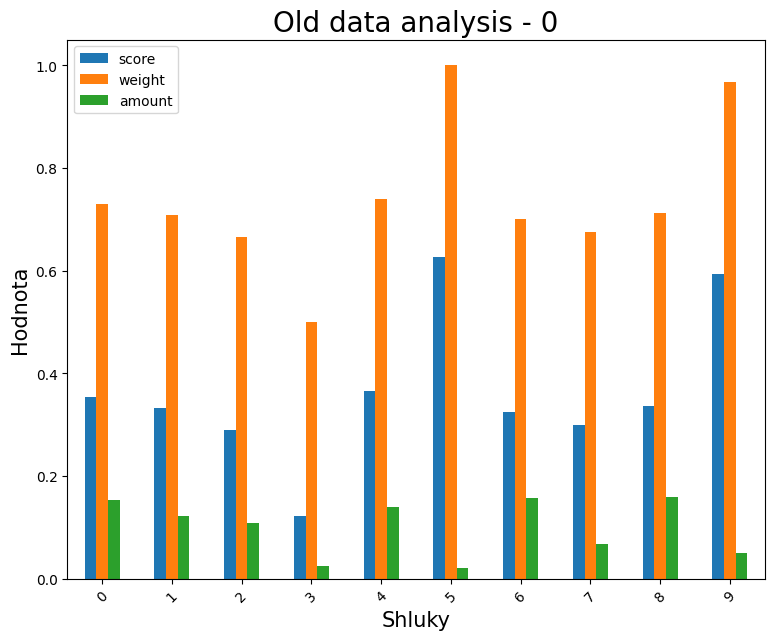

POTENTIAL AMOUNT 2137
REDUCED AMOUNT 888
Extracted data 0  -  888
(2959, 20)
(2959, 1)


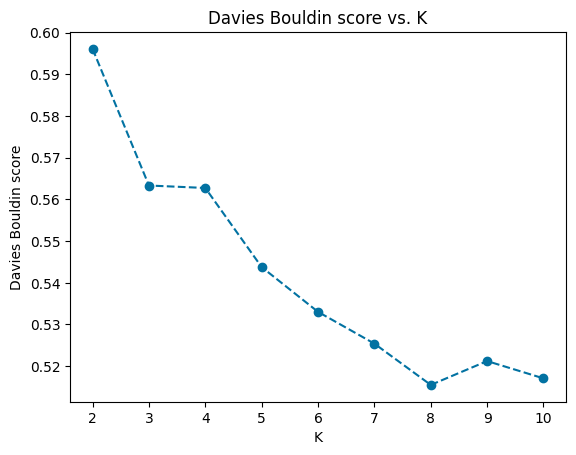

Final K parameter: 8


/home/netmon/.local/lib/python3.10/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


TOTAL ACC 0.9651909428861102


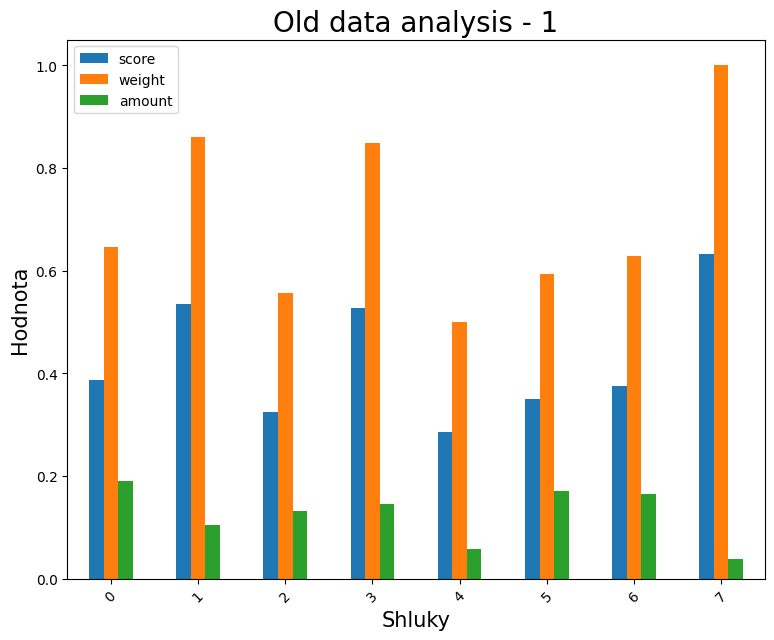

POTENTIAL AMOUNT 2009
REDUCED AMOUNT 888
Extracted data 1  -  887
CPU times: user 32 s, sys: 2.48 s, total: 34.5 s
Wall time: 5.93 s
Old data analysis - 0 To be extracted -  592
Old data analysis - 1 To be extracted -  592
(2961, 20)
(2961, 1)


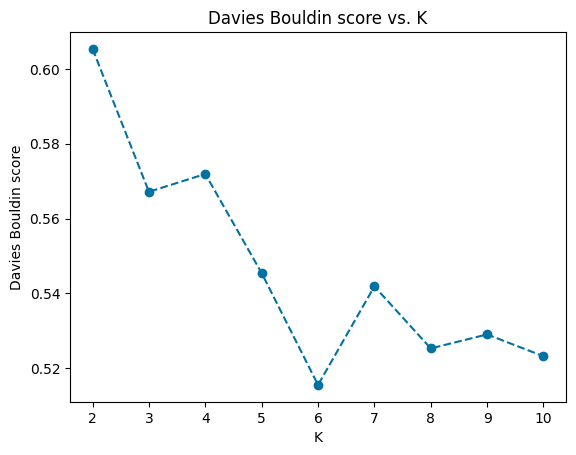

Final K parameter: 6


/home/netmon/.local/lib/python3.10/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


TOTAL ACC 0.961837217156366


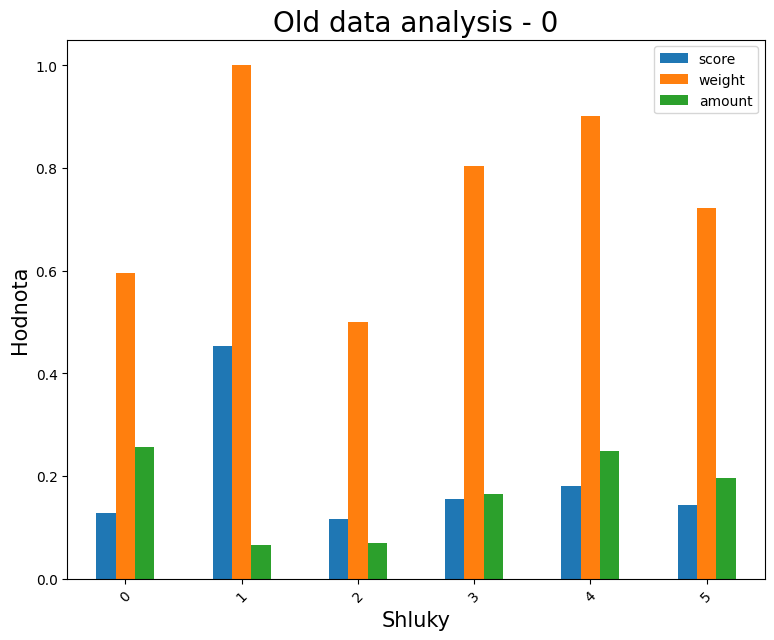

POTENTIAL AMOUNT 2222
REDUCED AMOUNT 592
Extracted data 0  -  592
(2959, 20)
(2959, 1)


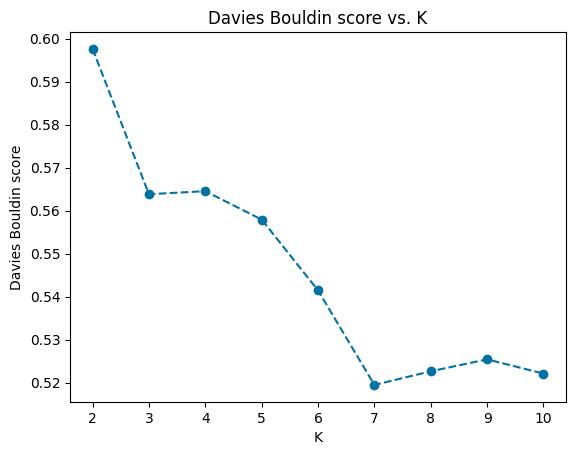

Final K parameter: 7


/home/netmon/.local/lib/python3.10/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


TOTAL ACC 0.9651909428861102


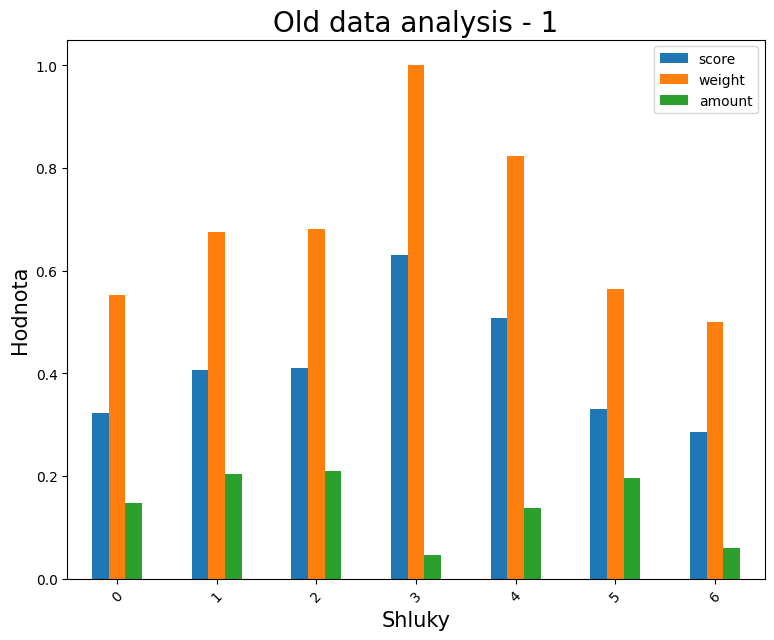

POTENTIAL AMOUNT 1955
REDUCED AMOUNT 592
Extracted data 1  -  592
CPU times: user 27.3 s, sys: 2.61 s, total: 29.9 s
Wall time: 5.66 s
Old data analysis - 0 To be extracted -  296
Old data analysis - 1 To be extracted -  296
(2961, 20)
(2961, 1)


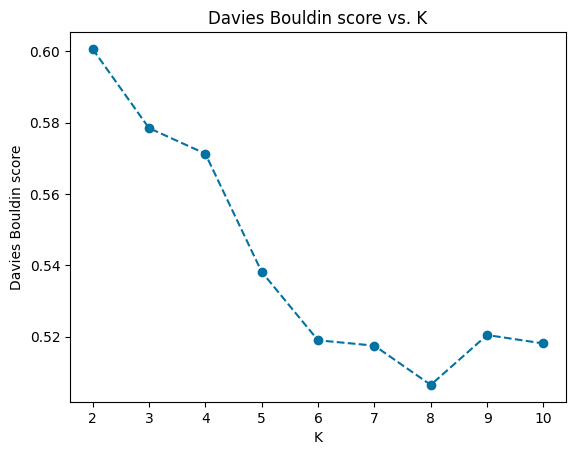

Final K parameter: 8


/home/netmon/.local/lib/python3.10/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


TOTAL ACC 0.961837217156366


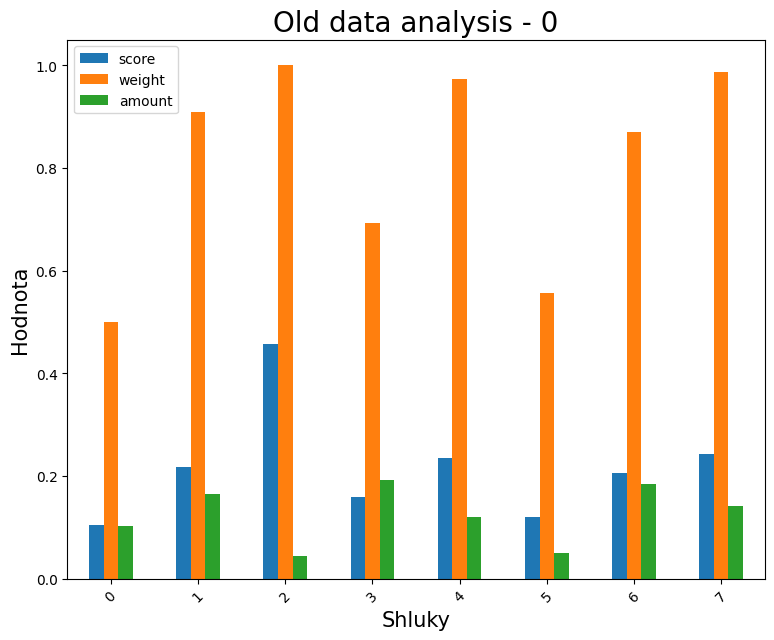

POTENTIAL AMOUNT 2438
REDUCED AMOUNT 296
Extracted data 0  -  296
(2959, 20)
(2959, 1)


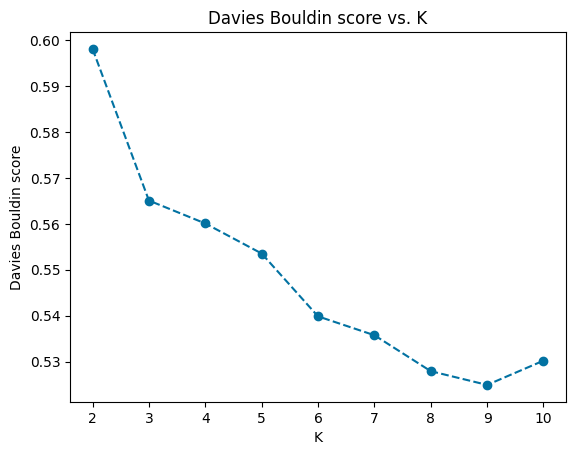

Final K parameter: 9


/home/netmon/.local/lib/python3.10/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


TOTAL ACC 0.9651909428861102


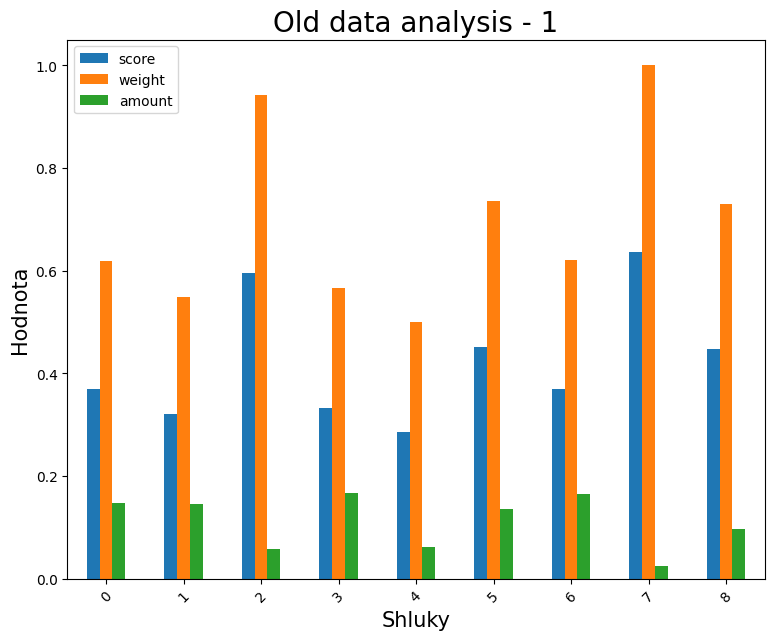

POTENTIAL AMOUNT 1916
REDUCED AMOUNT 296
Extracted data 1  -  296
CPU times: user 26.2 s, sys: 2.36 s, total: 28.5 s
Wall time: 5.2 s
Old data analysis - 0 To be extracted -  148
Old data analysis - 1 To be extracted -  148
(2961, 20)
(2961, 1)


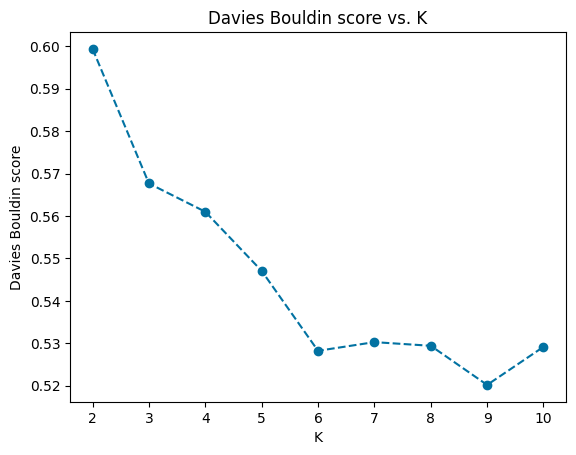

Final K parameter: 9


/home/netmon/.local/lib/python3.10/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


TOTAL ACC 0.961837217156366


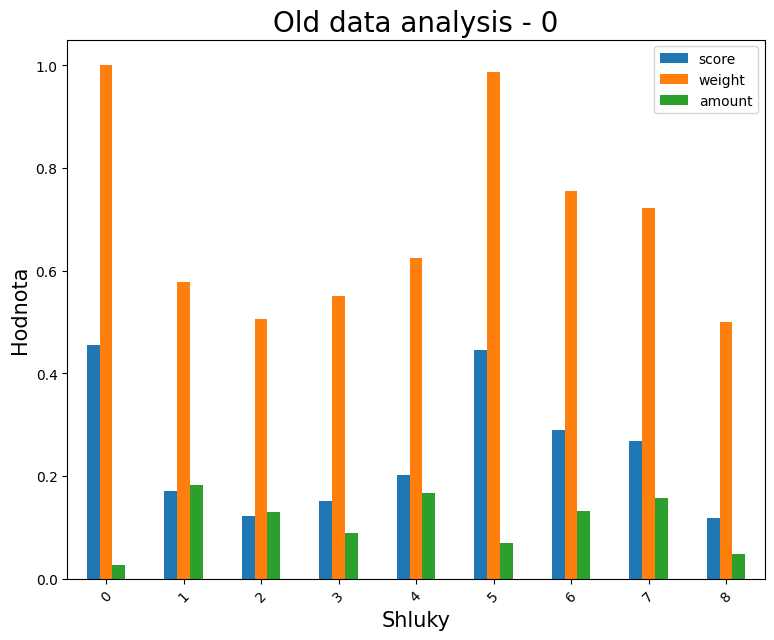

POTENTIAL AMOUNT 1940
REDUCED AMOUNT 148
Extracted data 0  -  148
(2959, 20)
(2959, 1)


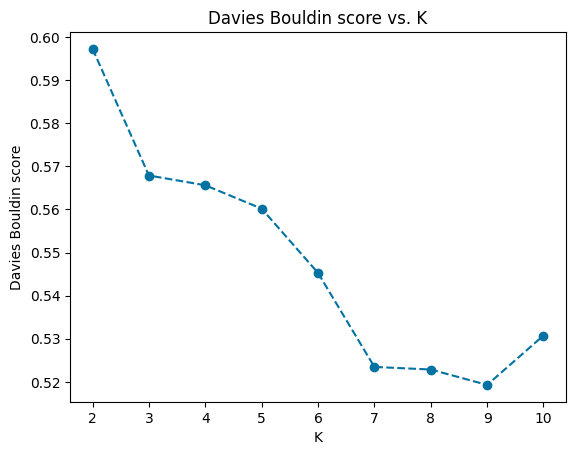

Final K parameter: 9


/home/netmon/.local/lib/python3.10/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


TOTAL ACC 0.9651909428861102


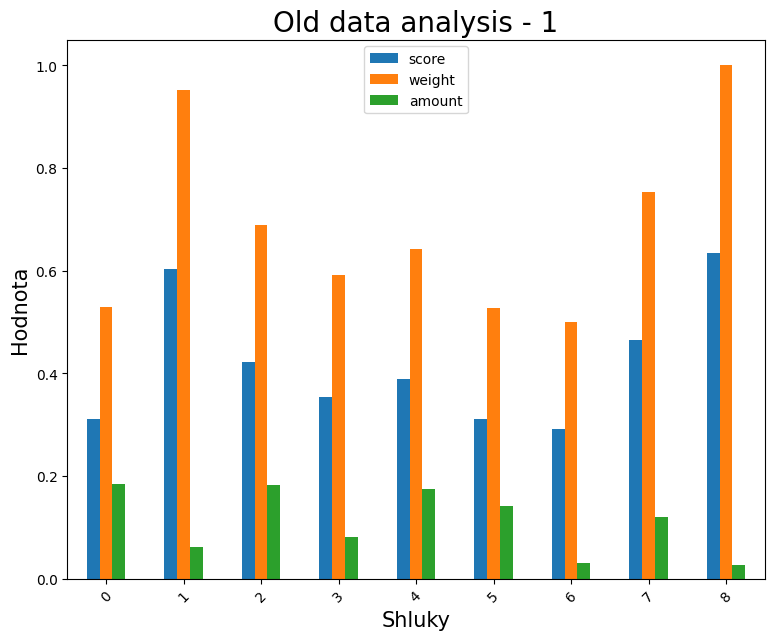

POTENTIAL AMOUNT 1914
REDUCED AMOUNT 148
Extracted data 1  -  148
CPU times: user 26.8 s, sys: 2.43 s, total: 29.2 s
Wall time: 5.26 s
{0: 3818, 1: 1586, 'all': 5404}
old               precision    recall  f1-score   support

           0     0.9139    0.9349    0.9242       783
           1     0.8179    0.7685    0.7924       298

    accuracy                         0.8890      1081
   macro avg     0.8659    0.8517    0.8583      1081
weighted avg     0.8874    0.8890    0.8879      1081

dumb               precision    recall  f1-score   support

           0     0.8480    0.8978    0.8722       783
           1     0.6825    0.5772    0.6255       298

    accuracy                         0.8094      1081
   macro avg     0.7653    0.7375    0.7488      1081
weighted avg     0.8024    0.8094    0.8042      1081

Old data analysis - 0 To be extracted -  1080
Old data analysis - 1 To be extracted -  1080
{0: 1080, 1: 1080}
nearmiss1
CPU times: user 499 ms, sys: 8.38 ms, total: 507 

/usr/local/lib/python3.10/dist-packages/imblearn/under_sampling/_prototype_selection/_nearmiss.py:203: UserWarning: The number of the samples to be selected is larger than the number of samples available. The balancing ratio cannot be ensure and all samples will be returned.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


CPU times: user 21.3 s, sys: 8.5 s, total: 29.8 s
Wall time: 11.7 s
Old data analysis - 0 To be extracted -  864
Old data analysis - 1 To be extracted -  864
{0: 864, 1: 864}
nearmiss1
CPU times: user 593 ms, sys: 14 ms, total: 607 ms
Wall time: 93.7 ms
nearmiss2
CPU times: user 9.71 s, sys: 125 ms, total: 9.83 s
Wall time: 1.48 s
nearmiss3
CPU times: user 437 ms, sys: 24.3 ms, total: 461 ms
Wall time: 120 ms
randomsampler
CPU times: user 13 ms, sys: 781 µs, total: 13.8 ms
Wall time: 14 ms
clustercentroids


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


CPU times: user 19 s, sys: 8.44 s, total: 27.4 s
Wall time: 9.43 s
Old data analysis - 0 To be extracted -  648
Old data analysis - 1 To be extracted -  648
{0: 648, 1: 648}
nearmiss1
CPU times: user 574 ms, sys: 13.8 ms, total: 588 ms
Wall time: 92 ms
nearmiss2
CPU times: user 5.69 s, sys: 98.5 ms, total: 5.79 s
Wall time: 1.13 s
nearmiss3
CPU times: user 716 ms, sys: 22.7 ms, total: 738 ms
Wall time: 151 ms
randomsampler
CPU times: user 12.8 ms, sys: 962 µs, total: 13.7 ms
Wall time: 13.9 ms
clustercentroids


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


CPU times: user 16.8 s, sys: 8.54 s, total: 25.4 s
Wall time: 7.19 s
Old data analysis - 0 To be extracted -  432
Old data analysis - 1 To be extracted -  432
{0: 432, 1: 432}
nearmiss1
CPU times: user 633 ms, sys: 8.06 ms, total: 641 ms
Wall time: 98.3 ms
nearmiss2
CPU times: user 6.26 s, sys: 116 ms, total: 6.38 s
Wall time: 1.18 s
nearmiss3
CPU times: user 505 ms, sys: 19.5 ms, total: 525 ms
Wall time: 122 ms
randomsampler
CPU times: user 7.92 ms, sys: 0 ns, total: 7.92 ms
Wall time: 8.01 ms
clustercentroids


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


CPU times: user 14 s, sys: 8.47 s, total: 22.5 s
Wall time: 4.82 s
Old data analysis - 0 To be extracted -  216
Old data analysis - 1 To be extracted -  216
{0: 216, 1: 216}
nearmiss1
CPU times: user 622 ms, sys: 7.51 ms, total: 629 ms
Wall time: 92.1 ms
nearmiss2
CPU times: user 7.44 s, sys: 85.9 ms, total: 7.52 s
Wall time: 1.26 s
nearmiss3
CPU times: user 276 ms, sys: 20.4 ms, total: 297 ms
Wall time: 100 ms
randomsampler
CPU times: user 10.5 ms, sys: 0 ns, total: 10.5 ms
Wall time: 10.6 ms
clustercentroids


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


CPU times: user 11.7 s, sys: 7.9 s, total: 19.6 s
Wall time: 2.63 s
Old data analysis - 0 To be extracted -  108
Old data analysis - 1 To be extracted -  108
{0: 108, 1: 108}
nearmiss1
CPU times: user 544 ms, sys: 11.6 ms, total: 555 ms
Wall time: 91.5 ms
nearmiss2
CPU times: user 7.74 s, sys: 89.3 ms, total: 7.82 s
Wall time: 1.32 s
nearmiss3
CPU times: user 332 ms, sys: 19.8 ms, total: 352 ms
Wall time: 110 ms
randomsampler
CPU times: user 12.2 ms, sys: 0 ns, total: 12.2 ms
Wall time: 12.4 ms
clustercentroids


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


CPU times: user 13.2 s, sys: 6.61 s, total: 19.8 s
Wall time: 2.18 s
kmeans
bouldin
Old data analysis - 0 To be extracted -  1080
Old data analysis - 1 To be extracted -  1080
(3035, 5)
(3035, 4)


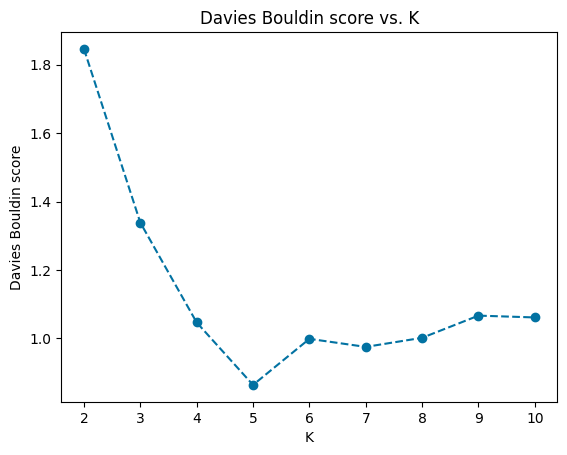

Final K parameter: 5


/home/netmon/.local/lib/python3.10/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


TOTAL ACC 0.9110378912685337


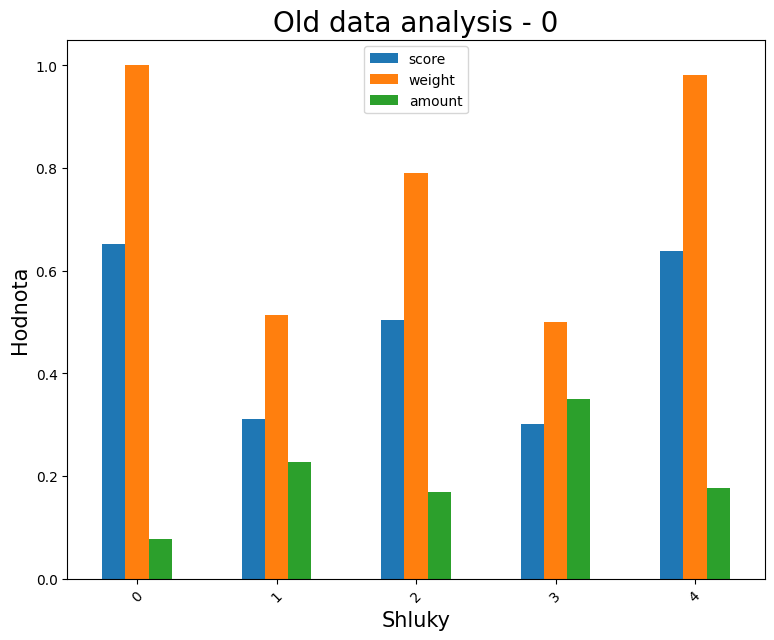

POTENTIAL AMOUNT 2047
REDUCED AMOUNT 1080
Extracted data 0  -  1081
(1288, 5)
(1288, 4)


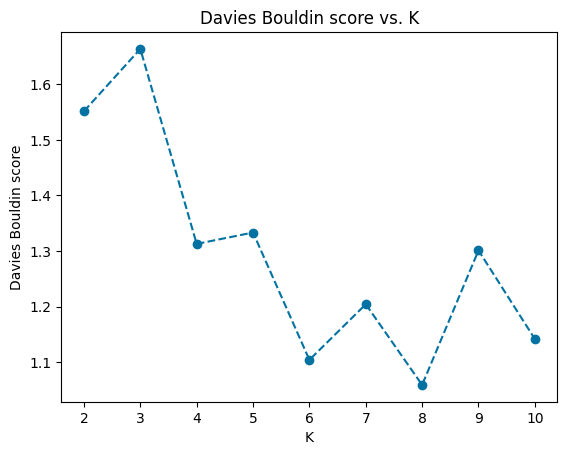

Final K parameter: 8


/home/netmon/.local/lib/python3.10/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


TOTAL ACC 0.6809006211180124


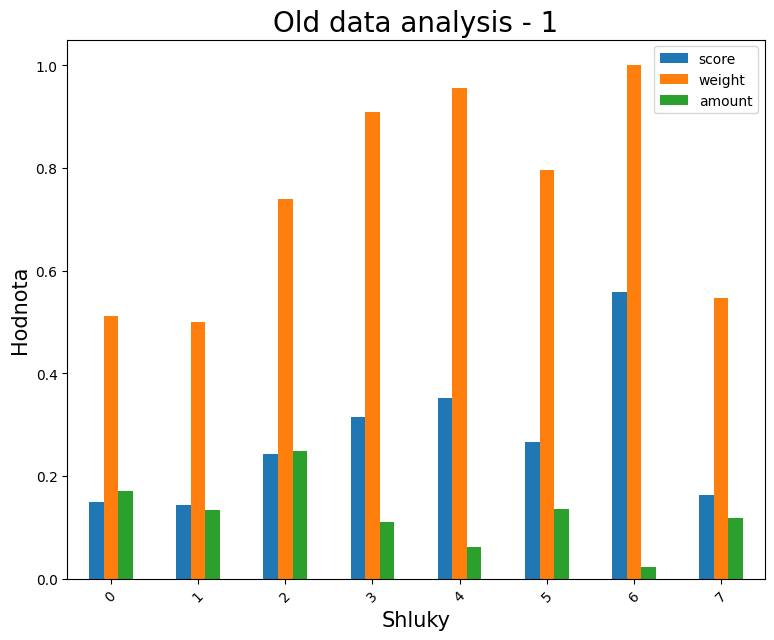

POTENTIAL AMOUNT 1121
REDUCED AMOUNT 1080
Extracted data 1  -  1082
CPU times: user 38.3 s, sys: 8.32 s, total: 46.7 s
Wall time: 6.45 s
Old data analysis - 0 To be extracted -  864
Old data analysis - 1 To be extracted -  864
(3035, 5)
(3035, 4)


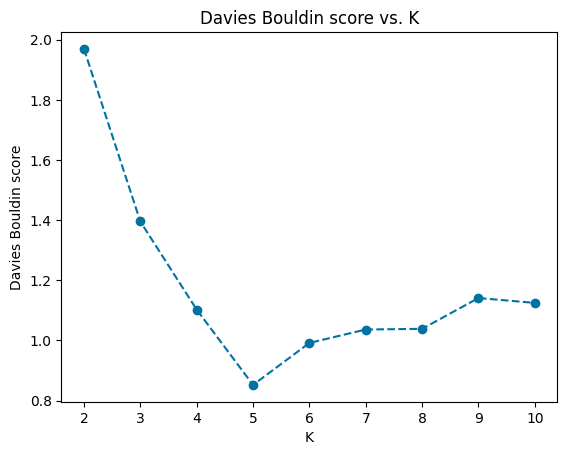

Final K parameter: 5


/home/netmon/.local/lib/python3.10/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


TOTAL ACC 0.9110378912685337


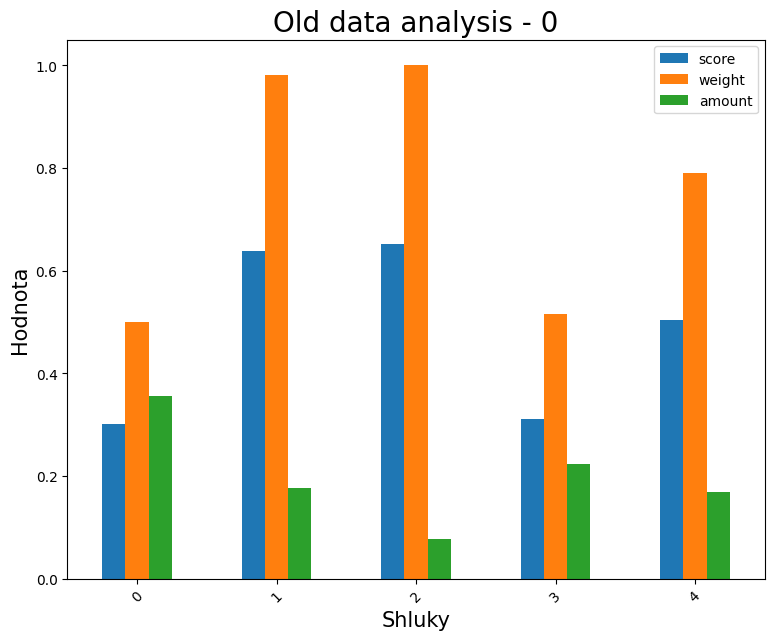

POTENTIAL AMOUNT 2048
REDUCED AMOUNT 864
Extracted data 0  -  863
(1288, 5)
(1288, 4)


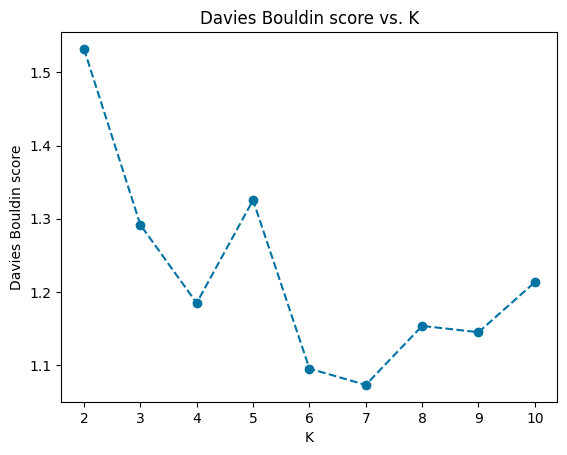

Final K parameter: 7


/home/netmon/.local/lib/python3.10/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


TOTAL ACC 0.6809006211180124


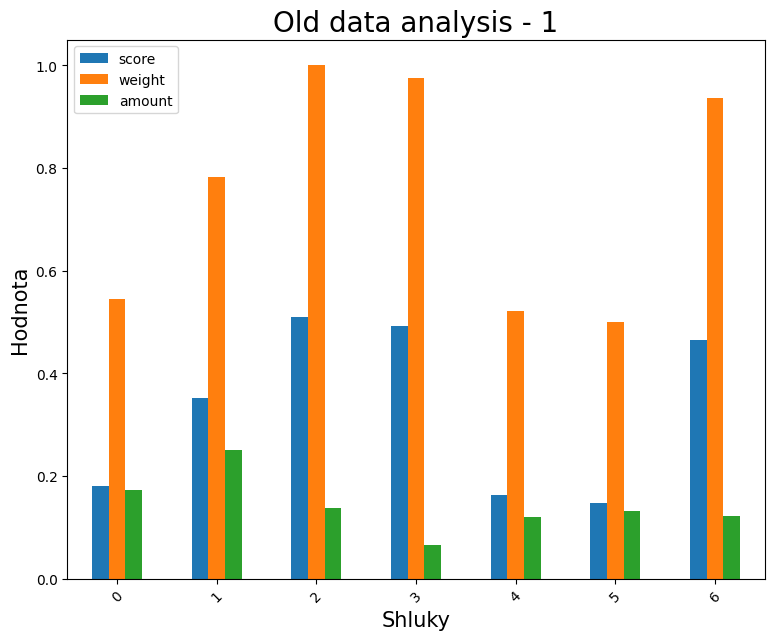

POTENTIAL AMOUNT 945
REDUCED AMOUNT 864
Extracted data 1  -  865
CPU times: user 37.7 s, sys: 7.88 s, total: 45.6 s
Wall time: 6.29 s
Old data analysis - 0 To be extracted -  648
Old data analysis - 1 To be extracted -  648
(3035, 5)
(3035, 4)


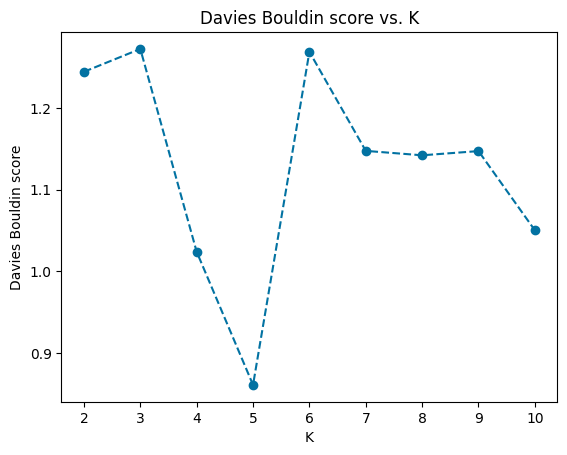

Final K parameter: 5


/home/netmon/.local/lib/python3.10/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


TOTAL ACC 0.9110378912685337


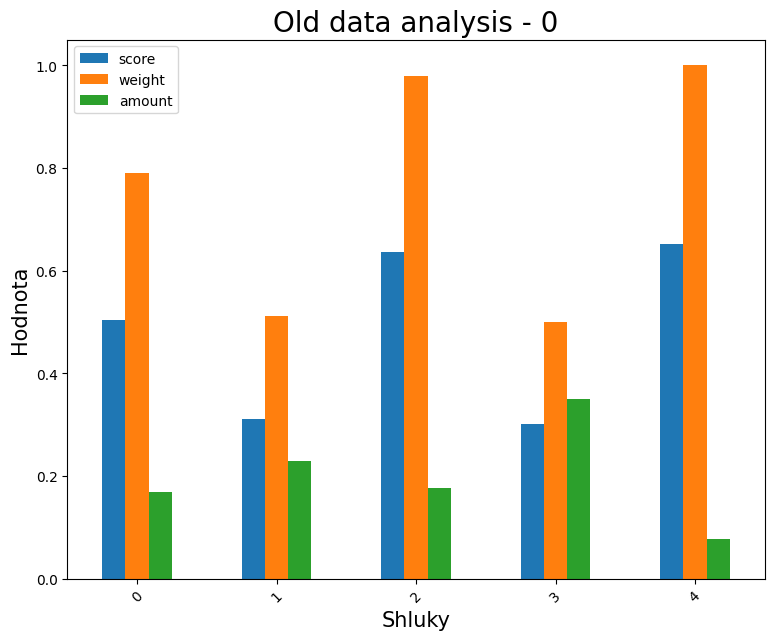

POTENTIAL AMOUNT 2046
REDUCED AMOUNT 648
Extracted data 0  -  648
(1288, 5)
(1288, 4)


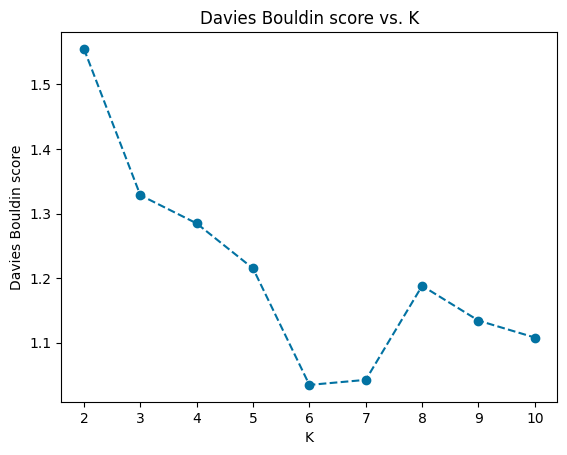

Final K parameter: 6


/home/netmon/.local/lib/python3.10/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


TOTAL ACC 0.6809006211180124


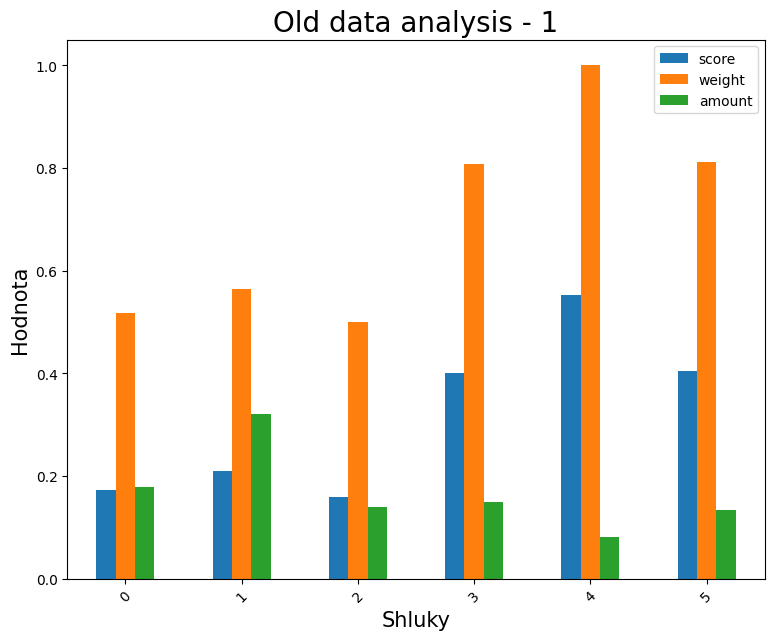

POTENTIAL AMOUNT 838
REDUCED AMOUNT 648
Extracted data 1  -  648
CPU times: user 39.1 s, sys: 7.94 s, total: 47 s
Wall time: 6.57 s
Old data analysis - 0 To be extracted -  432
Old data analysis - 1 To be extracted -  432
(3035, 5)
(3035, 4)


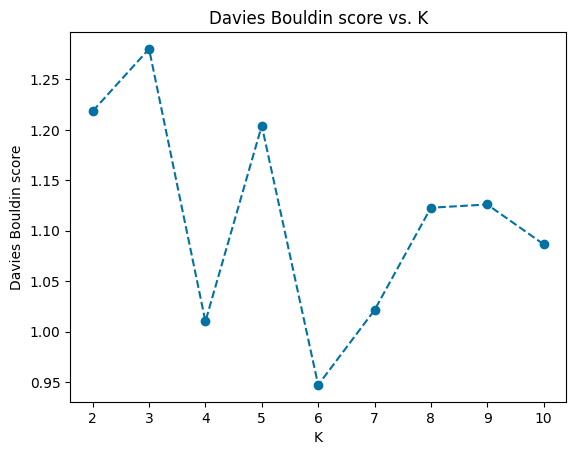

Final K parameter: 6


/home/netmon/.local/lib/python3.10/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


TOTAL ACC 0.9110378912685337


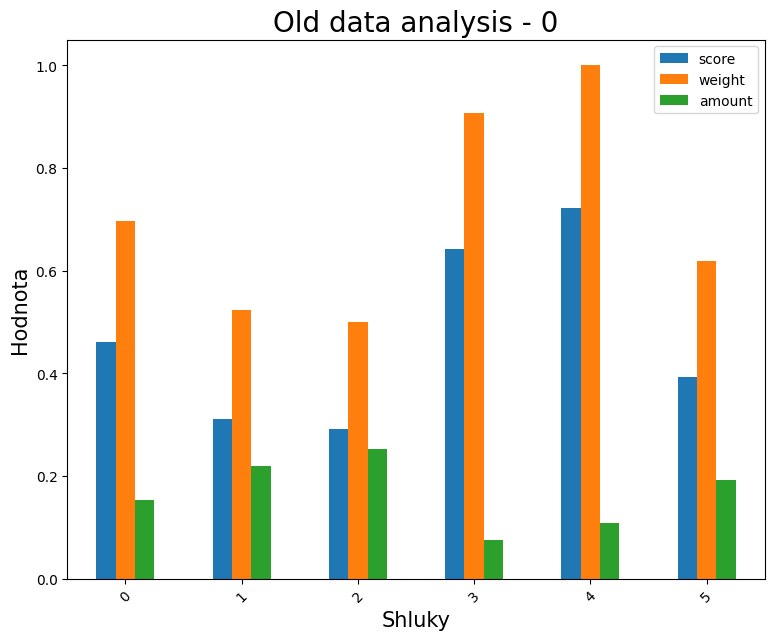

POTENTIAL AMOUNT 1950
REDUCED AMOUNT 432
Extracted data 0  -  432
(1288, 5)
(1288, 4)


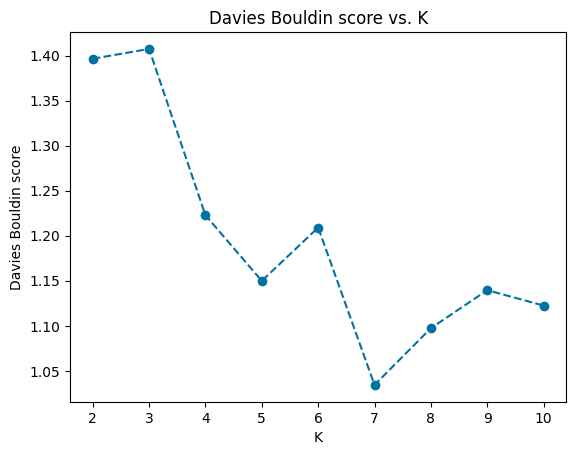

Final K parameter: 7


/home/netmon/.local/lib/python3.10/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


TOTAL ACC 0.6809006211180124


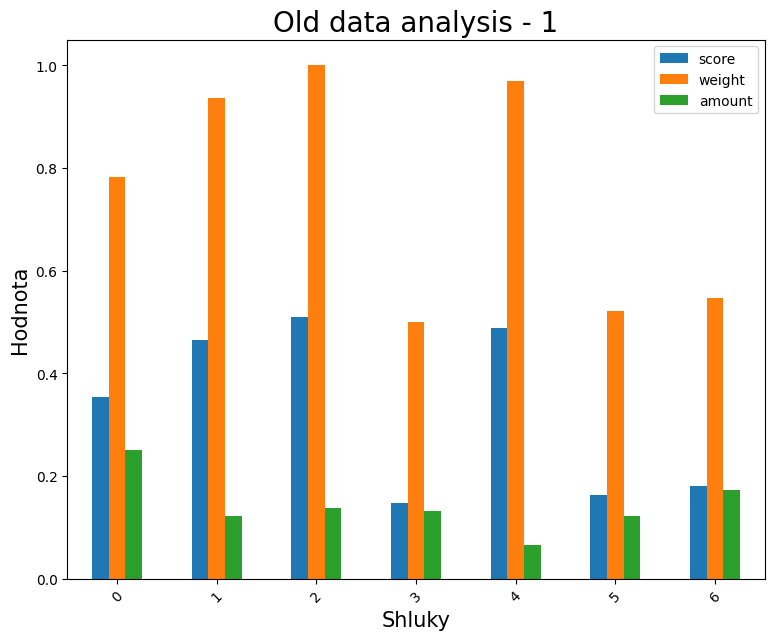

POTENTIAL AMOUNT 945
REDUCED AMOUNT 432
Extracted data 1  -  432
CPU times: user 38.8 s, sys: 8.01 s, total: 46.9 s
Wall time: 6.49 s
Old data analysis - 0 To be extracted -  216
Old data analysis - 1 To be extracted -  216
(3035, 5)
(3035, 4)


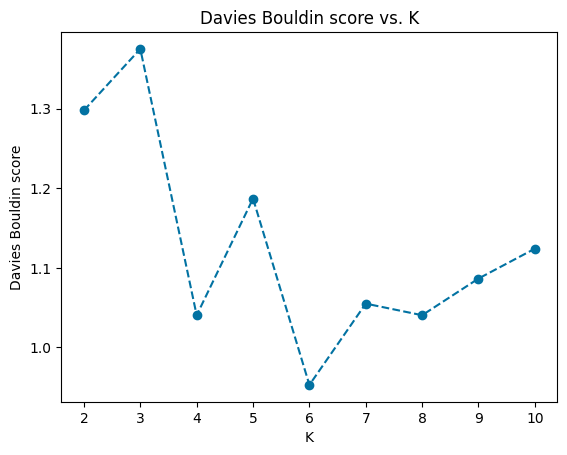

Final K parameter: 6


/home/netmon/.local/lib/python3.10/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


TOTAL ACC 0.9110378912685337


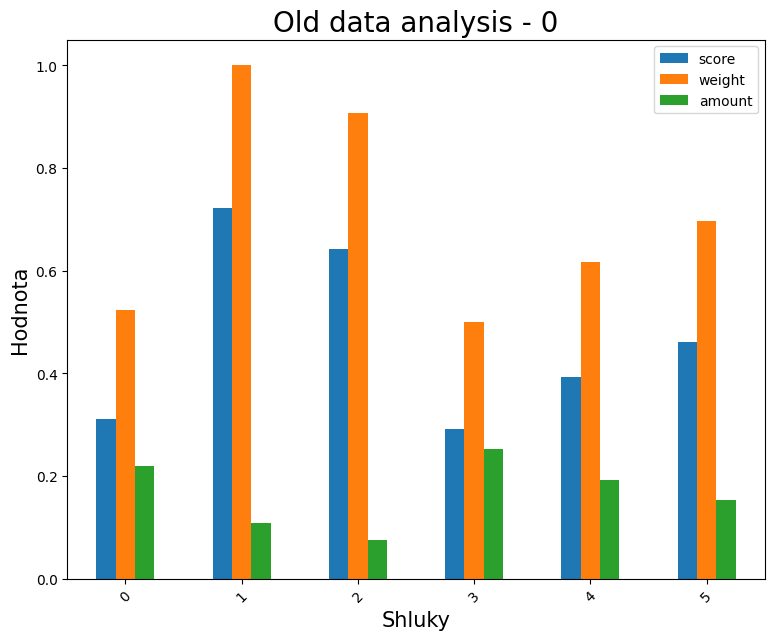

POTENTIAL AMOUNT 1950
REDUCED AMOUNT 216
Extracted data 0  -  217
(1288, 5)
(1288, 4)


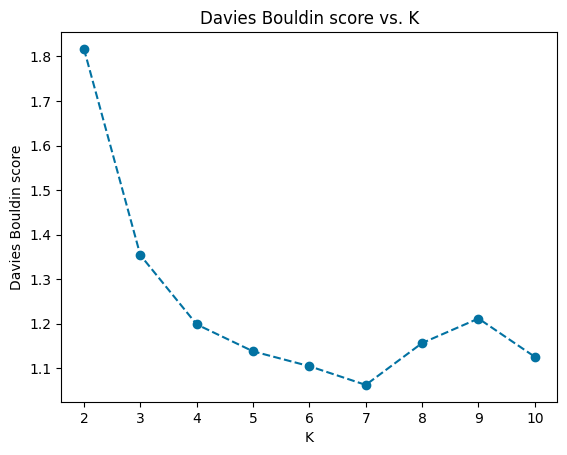

Final K parameter: 7


/home/netmon/.local/lib/python3.10/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


TOTAL ACC 0.6809006211180124


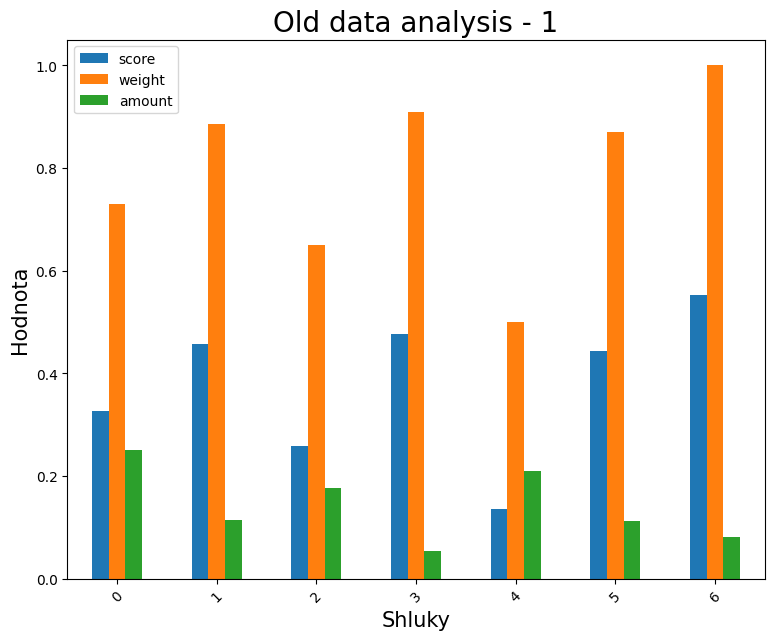

POTENTIAL AMOUNT 943
REDUCED AMOUNT 216
Extracted data 1  -  217
CPU times: user 37.3 s, sys: 8.09 s, total: 45.4 s
Wall time: 6.36 s
Old data analysis - 0 To be extracted -  108
Old data analysis - 1 To be extracted -  108
(3035, 5)
(3035, 4)


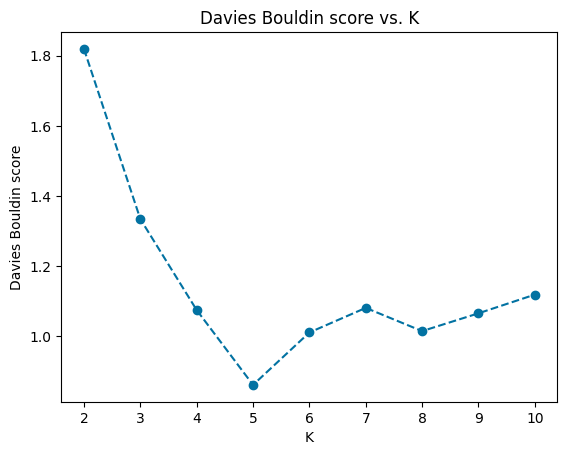

Final K parameter: 5


/home/netmon/.local/lib/python3.10/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


TOTAL ACC 0.9110378912685337


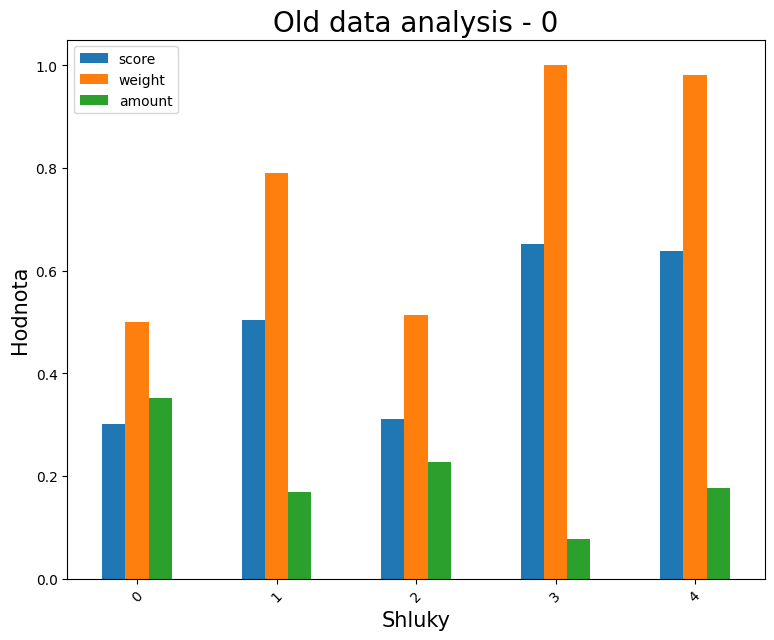

POTENTIAL AMOUNT 2047
REDUCED AMOUNT 108
Extracted data 0  -  108
(1288, 5)
(1288, 4)


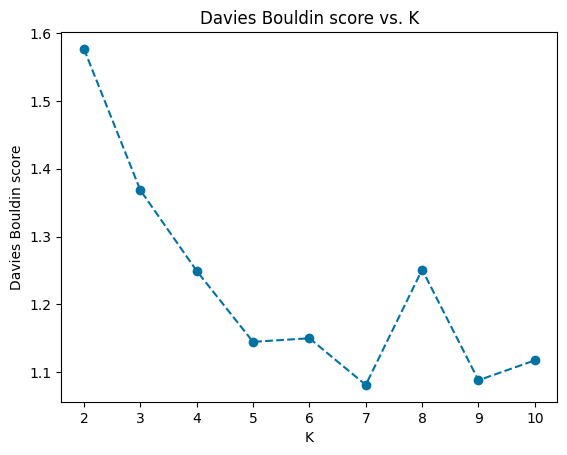

Final K parameter: 7


/home/netmon/.local/lib/python3.10/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


TOTAL ACC 0.6809006211180124


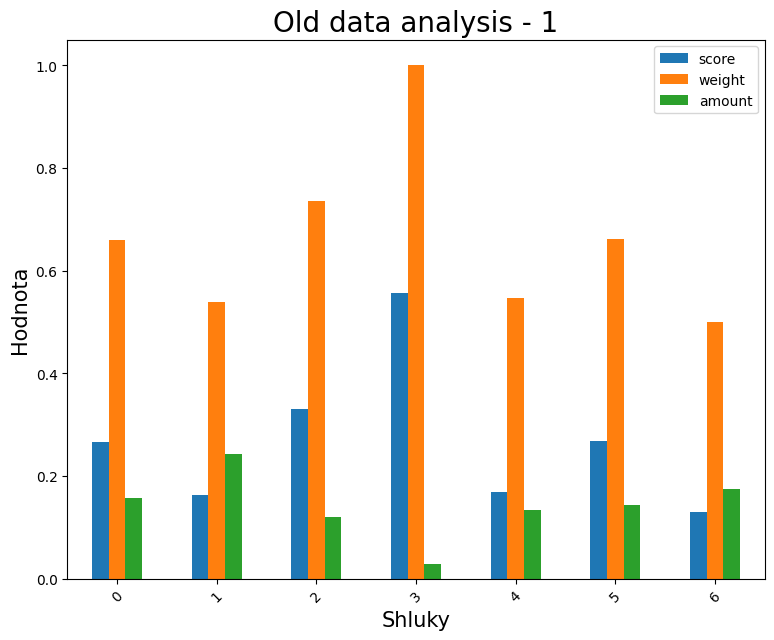

POTENTIAL AMOUNT 780
REDUCED AMOUNT 108
Extracted data 1  -  108
CPU times: user 41.5 s, sys: 8.15 s, total: 49.6 s
Wall time: 6.58 s


<Figure size 640x480 with 0 Axes>

In [99]:
framework_result=pd.DataFrame()
use_case="REFDAT"
datasets=[#("banana",(1,-1)),
        #("breast-cancer",("recurrence-events","no-recurrence-events")),
        ("bupa",(2,1)),
        # ("EEG",(1,0)),
        ("magic",("g","h")),
        ("monk-2",(1,0)),
        ("pima",("tested_positive","tested_negative")),
        ("ring",(1,0)),
        ("twonorm",(1,0)),
        ("phoneme",(1,0))
        ]
with Parallel(n_jobs=1,backend="multiprocessing") as parallel:
    for data in datasets:
        use_case=data[0]
        old_data,test_data,indexs=prep_data(use_case=use_case,data=data,label="Class")
        original_data=old_data.csv_data.copy()
        if old_data.csv_data.shape[0] < 500:
            dumb_ratio=0.6
        else: 
            dumb_ratio=0.8
        for index in indexs:
            old_data.csv_data=original_data.filter(items=index[0],axis=0)
            test_data.csv_data=original_data.filter(items=index[1],axis=0)
            #old_data.save(f"{output_directory}old_{use_case}_0.0.csv")
            for i in range(3,4):
                model_type="knn"
                clfs,res=prep_models(old_data,test_data,use_case,dumb_ratio=dumb_ratio,knn=i,model_type=model_type)
                #framework_result=pd.concat([framework_result,res])
                res=imbl_comp(old_data,test_data,clfs,use_case,i)
                #framework_result=pd.concat([framework_result,res])
                # Choose modification and K estimation method 
                for alg in ["kmeans"]:#kmeans
                    print(alg)
                    if alg== 'h2o':
                        k_methods=['default']
                        h2o.init()
                    else:
                        k_methods=["bouldin"]#,'calinski_harabasz','silhouette','elbow','bouldin','PRE']:
                    for metric in k_methods:
                        print(metric)
                        for red in [0.5,0.4,0.3,0.2,0.1,0.05]:#,0.04,0.03,0.02,0.01]:#[0.04,0.03,0.02,0.01]:#[0.8,0.7,0.6,0.5,0.4]:#0.3,0.2,0.1,0.05
                            #try: 
                            input_vector,jobs,reduction=get_params(red,old_data=old_data,clfs=clfs)
                            %time results=parallel([delayed(modification_one)(label=i[0],data=i[1],clf=i[2],undersample=i[3],metric=metric,alg=alg,desc=i[4]) for i in input_vector])
                            
                            old_data.newdata=pd.concat(results)
                            ## random sampled res
                            # fin_red=red/5
                            # backup=old_data.csv_data
                            # old_data.update_csv()
                            # vec,_,reduction=get_params(0.17,old_data=old_data,clfs=clfs)
                            # fin_balance_dict={0:vec[0][3],1:vec[1][3]}
                            
                            # old_data.apply_imbalanced_lib(RandomUnderSampler(sampling_strategy=fin_balance_dict))
                            # old_data.set_data(backup)
                            #print(old_data.newdata)
                            #vizualize(old_data.newdata,test_data.csv_data)
                            old_data.save_new(f"{output_directory}grouped_mixed_data_{use_case}_{red}.csv",append=True)
                            #print(test_data.csv_data)
                            

                            # clustered_result=old_data.compare_models(clfs['old'],clfs['clustered'],test_data)
                            # tmp=old_d ata.prepare_model_result(clustered_result,text+" "+str(reduction),use_case,alg+'_'+metric+" "+str(i))
                            # framework_result=pd.concat([framework_result,tmp])
                            # except:
                            #     pass
                            #old_data.save_new(output_directory+use_case+"_new_data_"+alg+"_"+metric+"_"+str(reduction)+".csv")
                        #test_data.save(f"xsetin00/Data/reduced_datasets/test_{use_case}.csv")     
                    if alg == 'h2o':
                        h2o.cluster().shutdown()
            break    
        

#### Show results

In [39]:
# Print results
framework_result#['Acc'].mean()

Dataset       Method Metric       Acc  Precision    Recall        F1  Impr   
0    ring  reduction 1  old 3  0.727027   0.820644  0.727027  0.700572     0  \
0    ring  reduction 1  old 3  0.694595   0.811879  0.694595  0.665646     0   
0    ring  reduction 1  old 3  0.716216   0.817654  0.716216  0.689235     0   
0    ring  reduction 1  old 3  0.697973   0.811423  0.697973  0.667166     0   
0    ring  reduction 1  old 3  0.706081   0.814986  0.706081  0.678441     0   

  Support_0 Support_1  
0      2958      2962  
0      2909      3011  
0      2939      2981  
0      2927      2993  
0      2923      2997

In [40]:
framework_result.to_csv(f"{output_directory}inc_scaled_res.csv",index=False,mode="a")

In [80]:
print("OLD",framework_result[framework_result["Metric"]=='old']["Acc"].mean())
print("Clustered",framework_result[framework_result["Metric"]=='kmeans_elbow']["Acc"].mean())
print("Clustered",framework_result[framework_result["Metric"]=='kmeans_bouldin']["Acc"].mean())

OLD 0.6318840579710144
Clustered nan
Clustered 0.6000000000000001


In [182]:
print("OLD",framework_result[framework_result["Metric"]=='old']["Acc"].mean())
print("Clustered",framework_result[framework_result["Metric"]=='kmeans_elbow']["Acc"].mean())
print("Clustered",framework_result[framework_result["Metric"]=='kmeans_bouldin']["Acc"].mean())

OLD 0.8666037735849056
Clustered 0.8615094339622642
Clustered nan


In [66]:
# Save results
framework_result.to_csv(f"{output_directory}{use_case}_{text}_result.csv",mode='a',index=False)

# Comparation

In [97]:
def imbl_comp(old_data,test_data,clfs,use_case,knn):
    result=pd.DataFrame()
    # Comaration with imbalanced learn library which implements various methods of data modification
    for reduction in [0.5,0.4,0.3,0.2,0.1,0.05]:#,0.02,0.01]:#,0.04,0.03,0.02,0.01]:#,0.7,0.6,0.5,0.4]:#[1,0.8,0.7,0.6,0.5,0.4,0.3,0.2,0.1,0.05]:
        vec,_,red=get_params(reduction,old_data=old_data,clfs=clfs)
        
        balance_dict={0:vec[0][3],1:vec[1][3]}
        print(balance_dict)
        imbl=[(NearMiss(sampling_strategy=balance_dict,version=1,n_jobs=-1),"nearmiss1"),###########
                (NearMiss(sampling_strategy=balance_dict,version=2,n_jobs=-1),"nearmiss2"),
                (NearMiss(sampling_strategy=balance_dict,version=3,n_jobs=-1),"nearmiss3"),
                # (NearMiss(sampling_strategy=balance_dict,n_neighbors=4,version=1,n_jobs=-1),"4nn-nearmiss1"),###########
                # (NearMiss(sampling_strategy=balance_dict,n_neighbors=4,version=2,n_jobs=-1),"4nn-nearmiss2"),############
                # (NearMiss(sampling_strategy=balance_dict,n_neighbors=4,version=3,n_jobs=-1),"4nn-3nearmiss3"),
                # (NearMiss(sampling_strategy=balance_dict,n_neighbors=5,version=1,n_jobs=-1),"4nn-nearmiss1"),###########
                # (NearMiss(sampling_strategy=balance_dict,n_neighbors=5,version=2,n_jobs=-1),"4nn-nearmiss2"),############
                # (NearMiss(sampling_strategy=balance_dict,n_neighbors=5,version=3,n_jobs=-1),"4nn-3nearmiss3"),
                # (NearMiss(sampling_strategy=balance_dict,n_neighbors=3,n_neighbors_ver3=2,version=3,n_jobs=-1),"3nn-2nearmiss3"),###########
                # (NearMiss(sampling_strategy=balance_dict,n_neighbors=4,n_neighbors_ver3=2,version=3,n_jobs=-1),"4nn-2nearmiss3"),############
                # (NearMiss(sampling_strategy=balance_dict,n_neighbors=5,n_neighbors_ver3=2,version=3,n_jobs=-1),"5nn-2nearmiss3"),
                # (NearMiss(sampling_strategy=balance_dict,n_neighbors=3,n_neighbors_ver3=4,version=3,n_jobs=-1),"3nn-4nearmiss3"),###########
                # (NearMiss(sampling_strategy=balance_dict,n_neighbors=4,n_neighbors_ver3=4,version=3,n_jobs=-1),"4nn-4nearmiss3"),############
                # (NearMiss(sampling_strategy=balance_dict,n_neighbors=5,n_neighbors_ver3=4,version=3,n_jobs=-1),"5nn-4nearmiss3"),
                # (NearMiss(sampling_strategy=balance_dict,n_neighbors=3,n_neighbors_ver3=5,version=3,n_jobs=-1),"3nn-5nearmiss3"),###########
                # (NearMiss(sampling_strategy=balance_dict,n_neighbors=4,n_neighbors_ver3=5,version=3,n_jobs=-1),"4nn-5nearmiss3"),############
                # (NearMiss(sampling_strategy=balance_dict,n_neighbors=5,n_neighbors_ver3=5,version=3,n_jobs=-1),"5nn-5nearmiss3"),
                #(CondensedNearestNeighbour(random_state=42,sampling_strategy='all',n_jobs=-1),"condensed_NN"),
                #(EditedNearestNeighbours(),"edited_NN"),
                #(RepeatedEditedNearestNeighbours(sampling_strategy='all',n_jobs=-1),"rep_edited__NN"),
                #(InstanceHardnessThreshold(sampling_strategy=balance_dict,random_state=42, estimator=LogisticRegression(solver='lbfgs', max_iter=200)),"inst_hard_tresh"),########
                #(NeighbourhoodCleaningRule(sampling_strategy='all',n_jobs=-1),"neigh_clean_rule"),
                #(OneSidedSelection(sampling_strategy='all',n_jobs=-1,random_state=42),"one_sided_sel"),
                (RandomUnderSampler(sampling_strategy=balance_dict),"randomsampler"),#ranmagic random_state=1
                #(TomekLinks(sampling_strategy='all',n_jobs=-1),"tomek_links"),
                #(AllKNN(sampling_strategy='all',n_jobs=-1,n_neighbors=7),"allKNN7"),
                (ClusterCentroids(sampling_strategy=balance_dict),"clustercentroids"),#########
                #(ClusterCentroids(sampling_strategy=balance_dict,random_state=42,estimator=KMeans(n_clusters=cluster_model.size)),"cluster_centroids_est_k")
                ]
        
        #final_red=reduction/5
        
        mixed_data=pd.DataFrame()
        for sampler in imbl:
            print(sampler[1])
            %time old_data.apply_imbalanced_lib(sampler[0])
            ## random sampled union
            # backup=old_data.csv_data
            # old_data.update_csv()
            # vec,_,red=get_params(0.17,old_data=old_data,clfs=clfs)
            # fin_balance_dict={0:vec[0][3],1:vec[1][3]}
            
            # old_data.apply_imbalanced_lib(RandomUnderSampler(sampling_strategy=fin_balance_dict))
            # kdtree = cKDTree(backup.values)
            # _, idx = kdtree.query(old_data.newdata.values, k=1)
            # old_data.newdata=backup.iloc[idx.flatten()]
            # old_data.set_data(backup)
            ##
            mixed_data=pd.concat([mixed_data,old_data.newdata])
            #old_data.save_new(f"{output_directory}{sampler[1]}_{use_case}_{red}.csv")
            #vizualize(old_data.newdata,test_data.csv_data)
            #imbl_result=old_data.compare_models(clfs['old'],clfs['compare'],test_data,sampler[1])
            #reduce=1-old_data.cnt_new['all']/old_data.cnt_old['all']
            #tmp=old_data.prepare_model_result(imbl_result,sampler[1]+" "+str(red),use_case,sampler[1]+" "+str(knn))
            #result=pd.concat([result,tmp])
        old_data.newdata=mixed_data
        old_data.save_new(f"{output_directory}grouped_mixed_data_{use_case}_{reduction}.csv")
    return result

Old data analysis - 0 To be extracted -  270020
Old data analysis - 1 To be extracted -  114437
New data analysis - 0 To be extracted -  283424
New data analysis - 1 To be extracted -  439007
{0: 553444, 1: 553444}
random sampler
CPU times: user 3.15 s, sys: 1.48 s, total: 4.64 s
Wall time: 4.67 s
Old dataset balance {0: 2246333, 1: 1390893, 'all': 3637226}


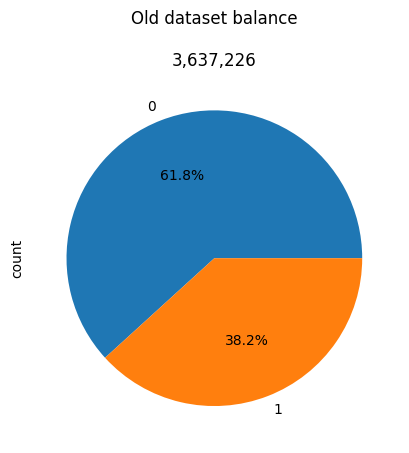

random sampler dataset balance {0: 553444, 1: 553444, 'all': 1106888}


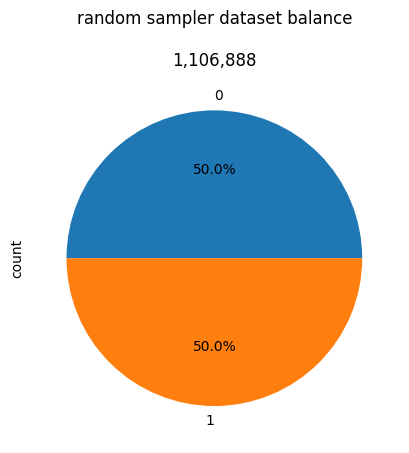

Reduction ratio 69.56779699694218


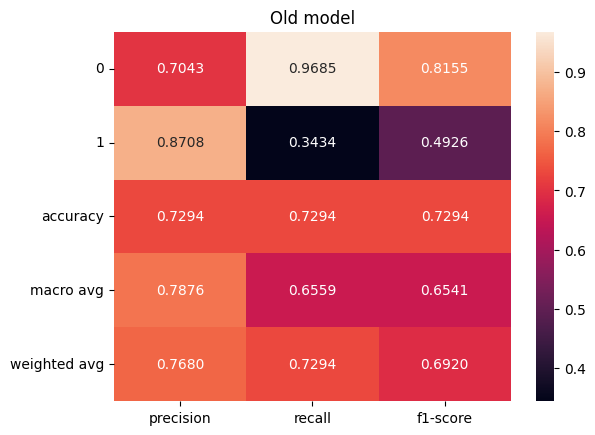

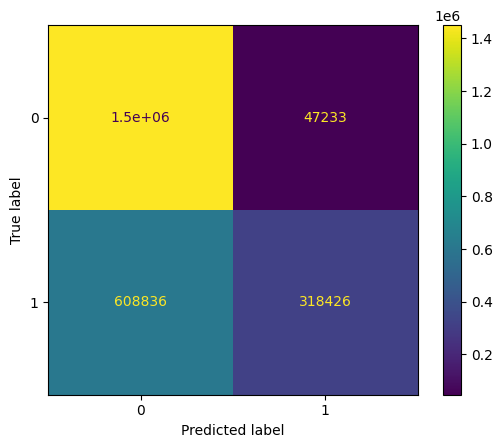

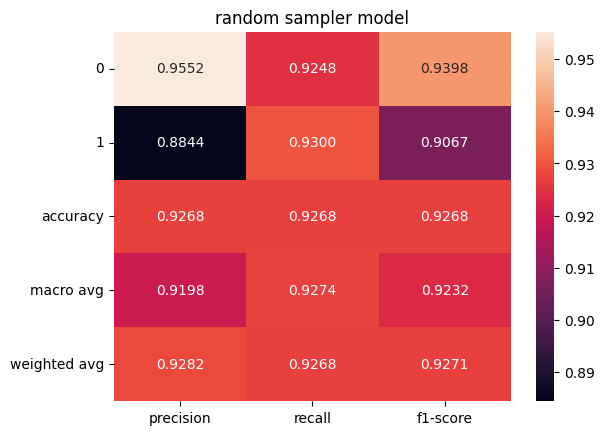

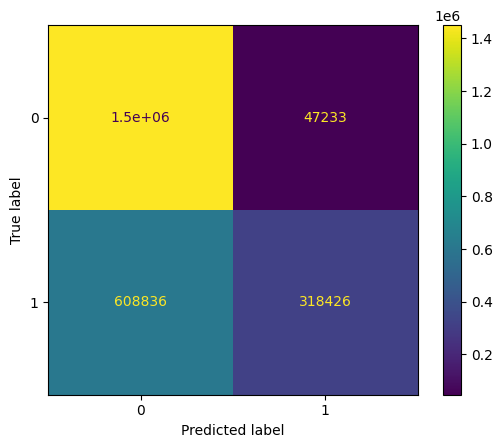

Improvement 76.32632059322863


Dataset              Method          Metric       Acc  Precision    Recall   
0     DOH             merging             old  0.729436   0.767998  0.729436  \
0     DOH             merging             new  0.852488   0.866056  0.852488   
0     DOH         merging 0.7     h2o_default  0.938132   0.939977  0.938132   
0     DOH         merging 0.7     h2o_default  0.938132   0.939977  0.938132   
0     DOH         merging 0.7     h2o_default  0.938132   0.939977  0.938132   
0     DOH         merging 0.7     h2o_default  0.936845   0.939268  0.936845   
0     DOH  random sampler 0.7  random sampler  0.926767   0.928161  0.926767   

         F1       Impr Support_0 Support_1  
0  0.692035   0.000000   1352542    228729  
0  0.854321   0.000000   1352542    228729  
0  0.938468  80.019865    553444    553445  
0  0.938468  80.019865    553444    553445  
0  0.938468  80.019865    553444    553445  
0  0.937241  79.621410    553444    553445  
0  0.927093  76.326321    553444    553444

In [67]:
# Comaration with imbalanced learn library which implements various methods of data modification
for reduction in [0.7]:#,0.7,0.6,0.5,0.4]:#[1,0.8,0.7,0.6,0.5,0.4,0.3,0.2,0.1,0.05]:
  vec,_,red=get_params(reduction)
  if merging:
    balance_dict={0:vec[0][3]+vec[2][3],1:vec[1][3]+vec[3][3]}
  else:
    balance_dict={0:vec[0][3],1:vec[1][3]}
  print(balance_dict)
  imbl=[#(NearMiss(sampling_strategy=balance_dict,version=1,n_jobs=-1),"near miss1"),###########
        #(NearMiss(sampling_strategy=balance_dict,version=2,n_jobs=-1),"near miss2"),############
        #(NearMiss(sampling_strategy=balance_dict,version=3,n_jobs=-1),"near miss3"),
        #(CondensedNearestNeighbour(random_state=42,sampling_strategy='all',n_jobs=-1),"condensed_NN"),
        #(EditedNearestNeighbours(),"edited_NN"),
        #(RepeatedEditedNearestNeighbours(sampling_strategy='all',n_jobs=-1),"rep_edited__NN"),
        #(InstanceHardnessThreshold(sampling_strategy=balance_dict,random_state=42, estimator=LogisticRegression(solver='lbfgs', max_iter=200)),"inst_hard_tresh"),########
        #(NeighbourhoodCleaningRule(sampling_strategy='all',n_jobs=-1),"neigh_clean_rule"),
        #(OneSidedSelection(sampling_strategy='all',n_jobs=-1,random_state=42),"one_sided_sel"),
        (RandomUnderSampler(sampling_strategy=balance_dict),"random sampler"),#ranmagic random_state=1
        #(TomekLinks(sampling_strategy='all',n_jobs=-1),"tomek_links"),
        #(AllKNN(sampling_strategy='all',n_jobs=-1),"allKNN"),
        #(ClusterCentroids(sampling_strategy=balance_dict,n_jobs=-1),"cluster centroids"),#########
        #(ClusterCentroids(sampling_strategy=balance_dict,random_state=42,estimator=KMeans(n_clusters=cluster_model.size)),"cluster_centroids_est_k")
        ]

  if merging:
    backup=old_data.csv_data
    old_data.csv_data=pd.concat([old_data.csv_data,new_data.csv_data],axis=0)
  for sampler in imbl:
    print(sampler[1])
    %time old_data.apply_imbalanced_lib(sampler[0])
    imbl_result=old_data.compare_models(clfs['old'],clfs['compare'],test_data,sampler[1])
    tmp=old_data.prepare_model_result(imbl_result,sampler[1]+" "+str(red),use_case,sampler[1])
    framework_result=pd.concat([framework_result,tmp])

  if merging:
    old_data.csv_data=backup
framework_result